# Análise Discriminante
<p>Aplicação da técnica de análise discriminante para prever a qual gênero um filme pertence</p>

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import levene
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import PowerTransformer
from scipy.stats import chi2

In [3]:
df = pd.read_csv("Dataset.csv")

In [12]:
def chooseGenre(genres):
    lista_generos = [g.strip() for g in genres.split(',')]
    if len(lista_generos) == 0:
        return None
    else:
        contagem = {g: lista_generos.count(g) for g in set(lista_generos)}
        return max(contagem, key=contagem.get)
df['genero_representativo'] = df['genero'].apply(chooseGenre)
df['popularidade'] = pd.read_csv("../T2/Transform.csv")['popularidade']
def mapping_category(genre):
    if genre in ['Action', 'Adventure']:
        return 'Ação e Aventura'
    elif genre in ['Drama', 'Horror', 'Thriller']:
        return 'Drama e Suspense'
    elif genre in ['Crime', 'Sci-Fi', 'Fantasy']:
        return 'Crime e Ficção Científica'
    elif genre in ['Comedy', 'Family', 'Biography', 'Romance', 'History', 'War']:
        return 'Comédia, Família, Romance e História'
    else:
        return 'Outro'
df['genero_categoria'] = df['genero_representativo'].apply(mapping_category)
print(df['genero_categoria'].value_counts())

genero_categoria
Drama e Suspense                        201
Crime e Ficção Científica               165
Ação e Aventura                         158
Comédia, Família, Romance e História     82
Name: count, dtype: int64


In [14]:
X = df.drop(columns=['genero', 'genero_representativo', 'genero_categoria', 'id', 'titulo', 'ano', 'diretor', 'pais', 'produtoras'])
X = X.astype({col: 'int' for col in X.select_dtypes('bool').columns})
Y = df['genero_categoria']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

## Verificação de suposições da Análise Discriminante

In [15]:
X.dtypes

popularidade            float64
voto_popular            float64
orcamento               float64
receita                 float64
duracao                 float64
avaliacao_da_critica    float64
total_streaming         float64
total_countries         float64
total_awards            float64
total_nominations       float64
oscar_wins                int64
total_languages         float64
dtype: object

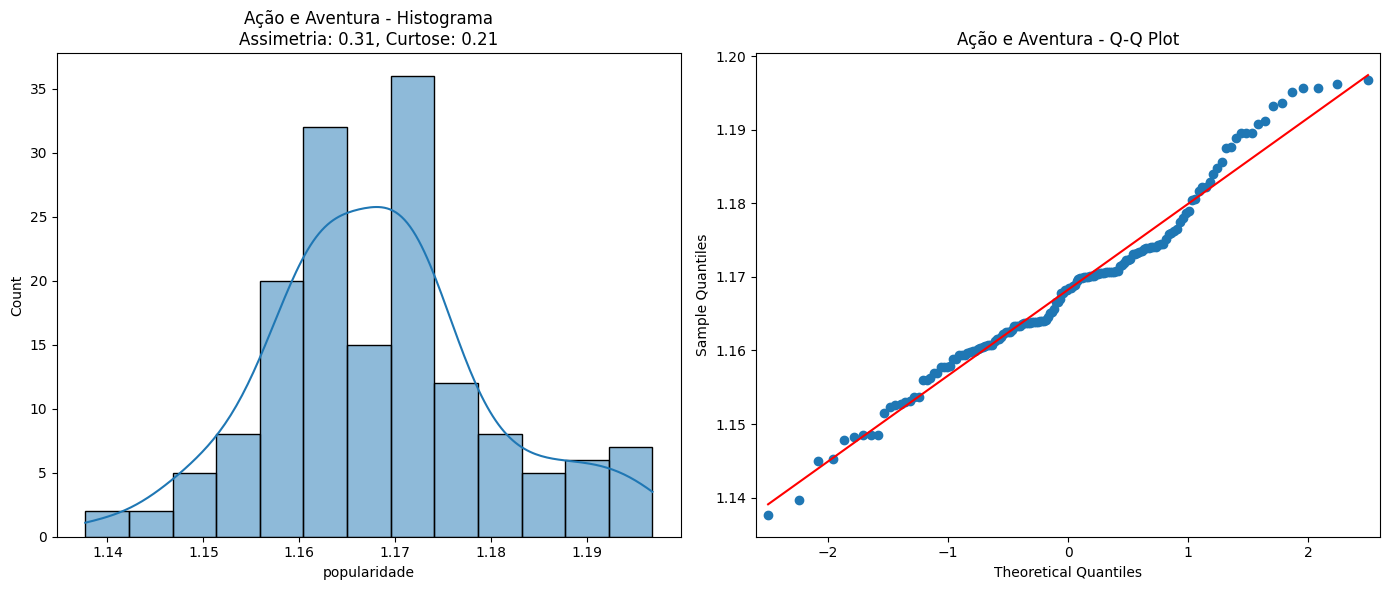

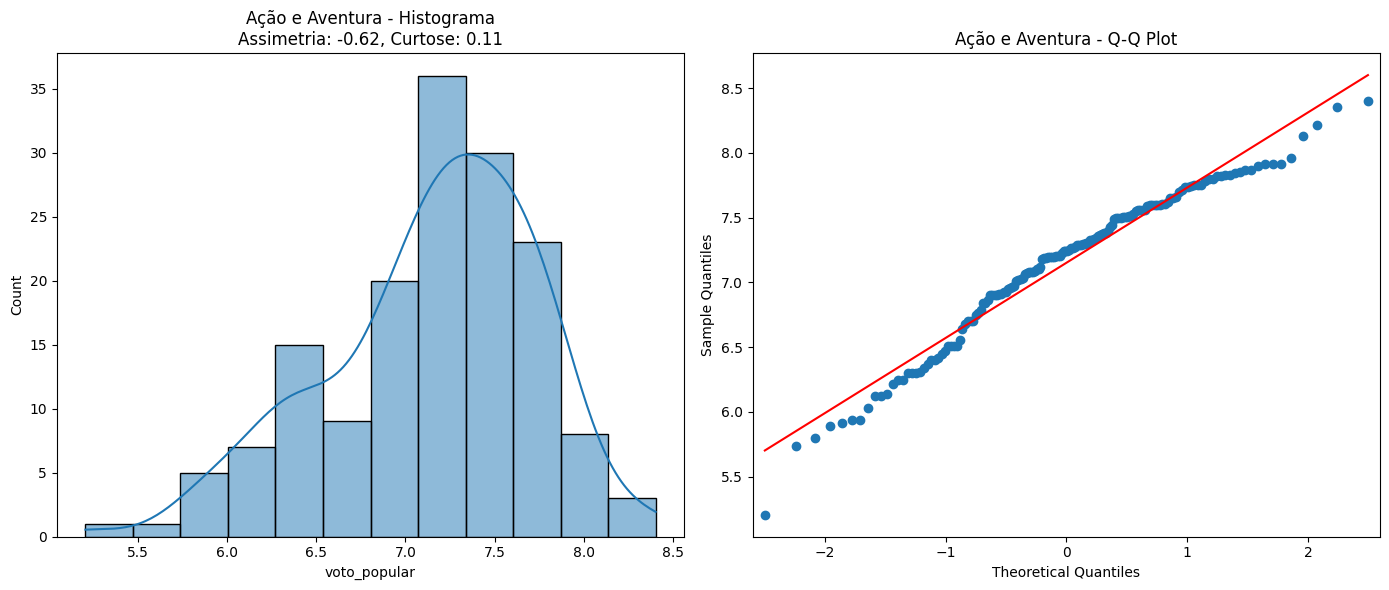

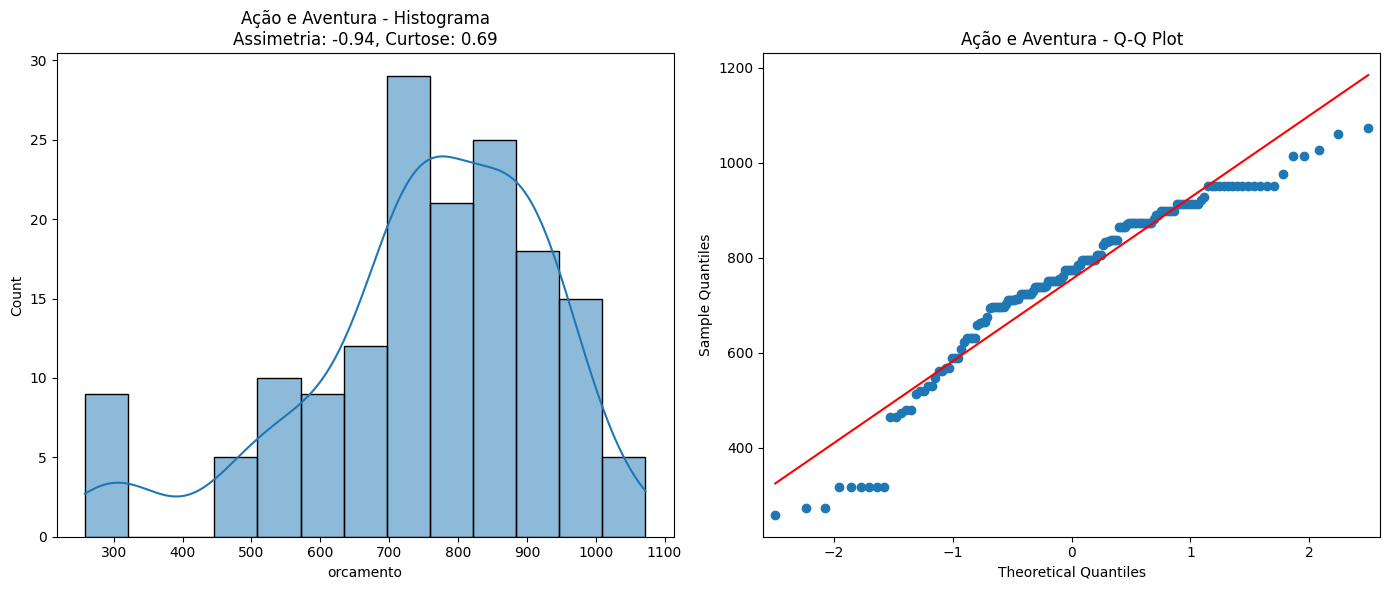

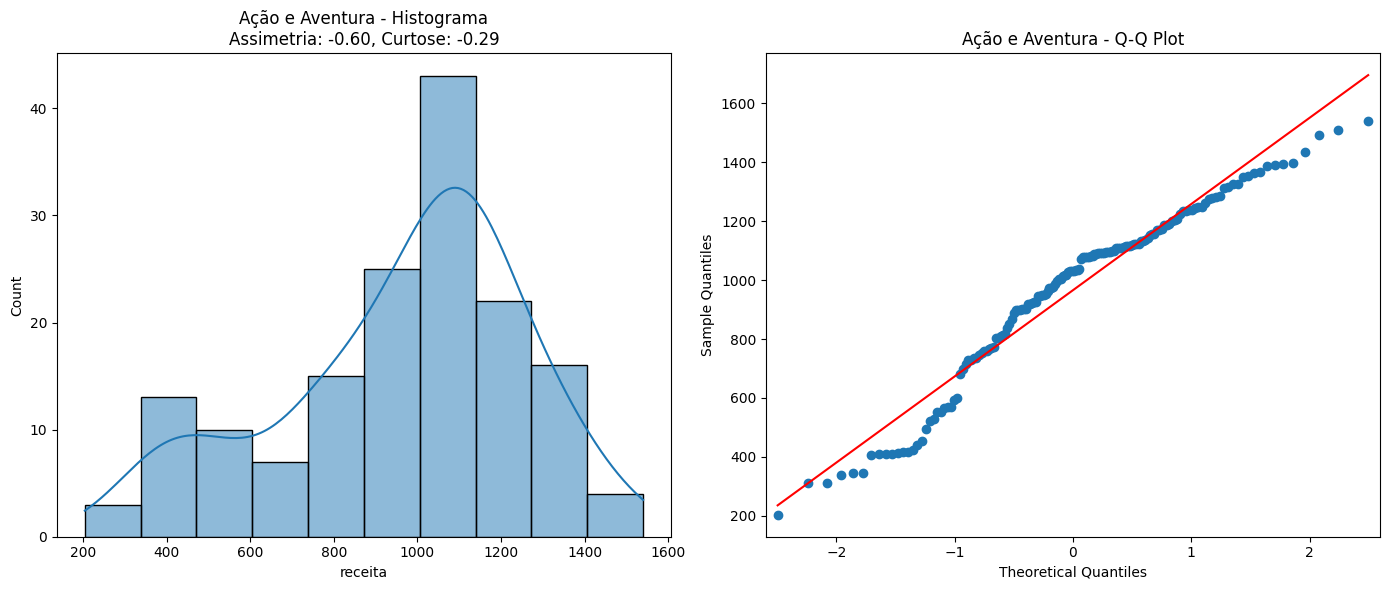

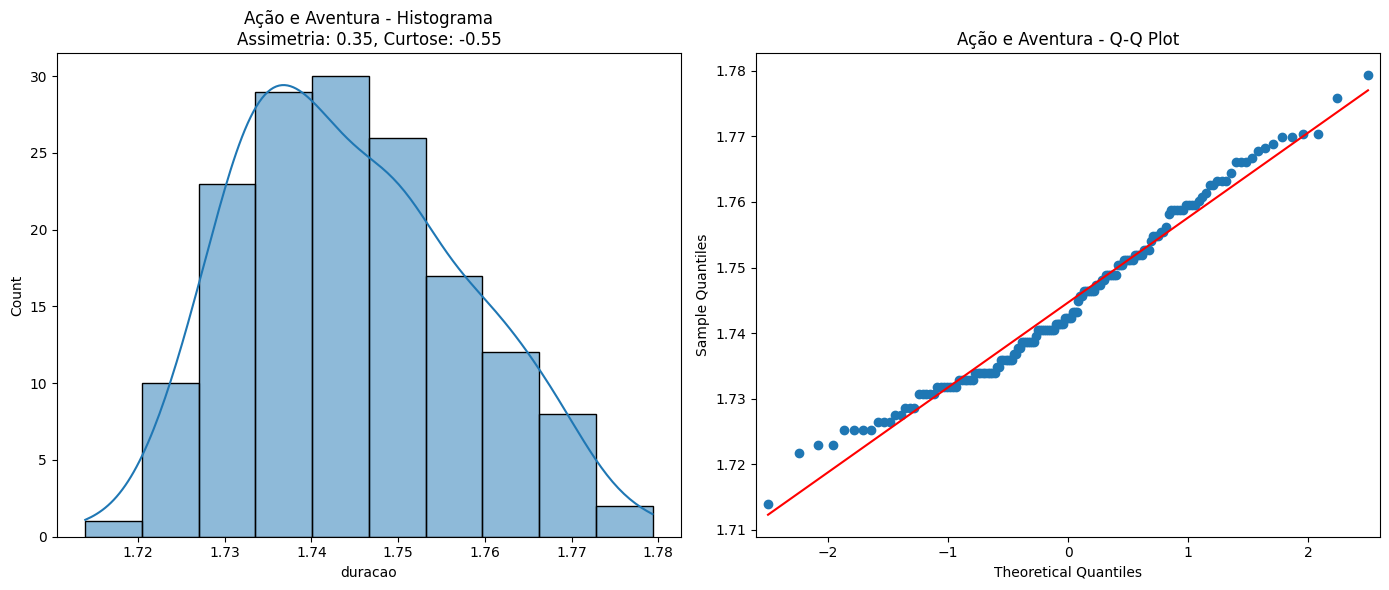

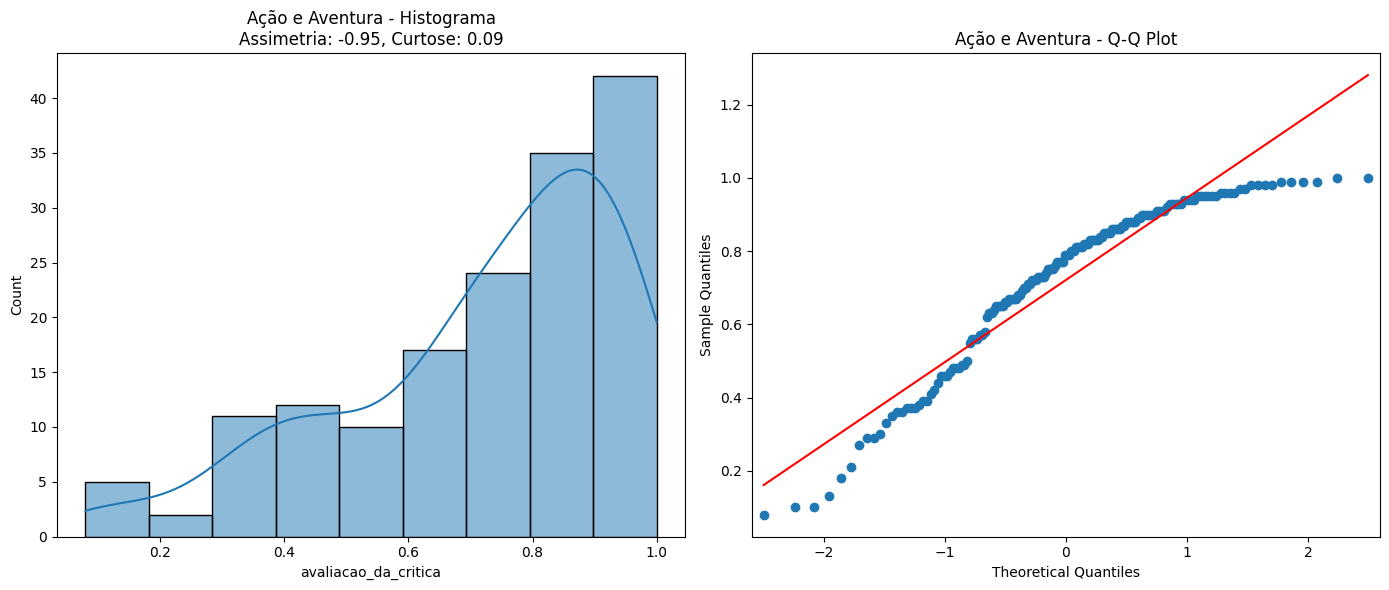

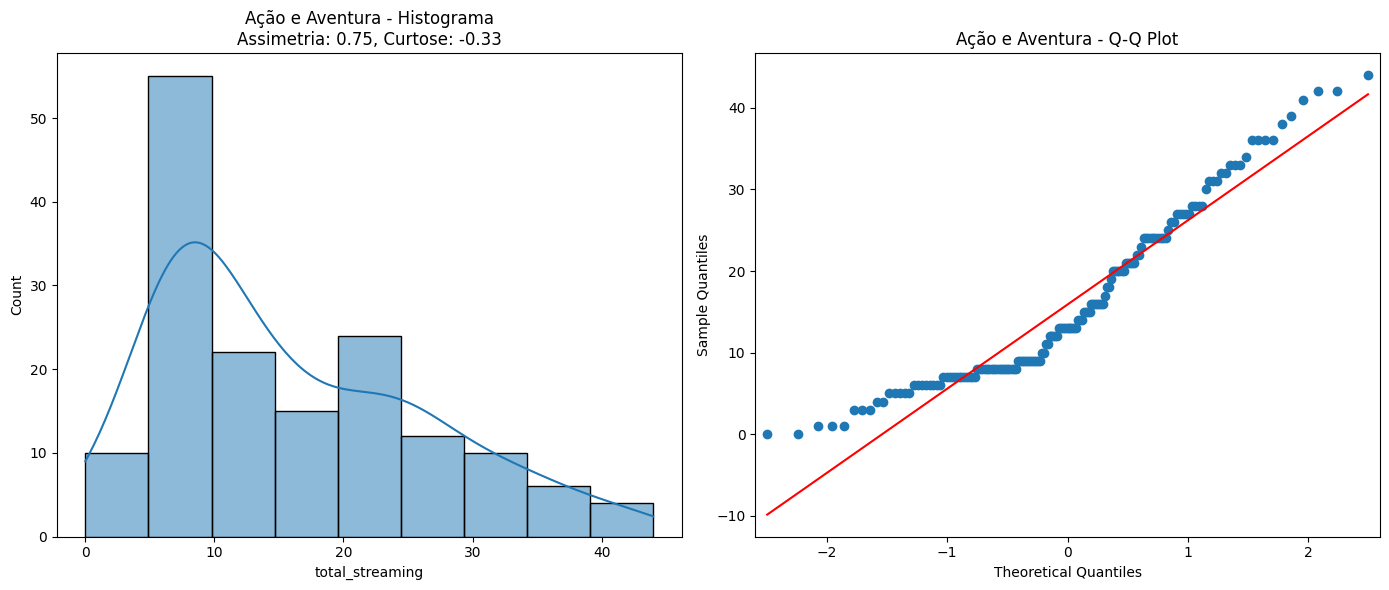

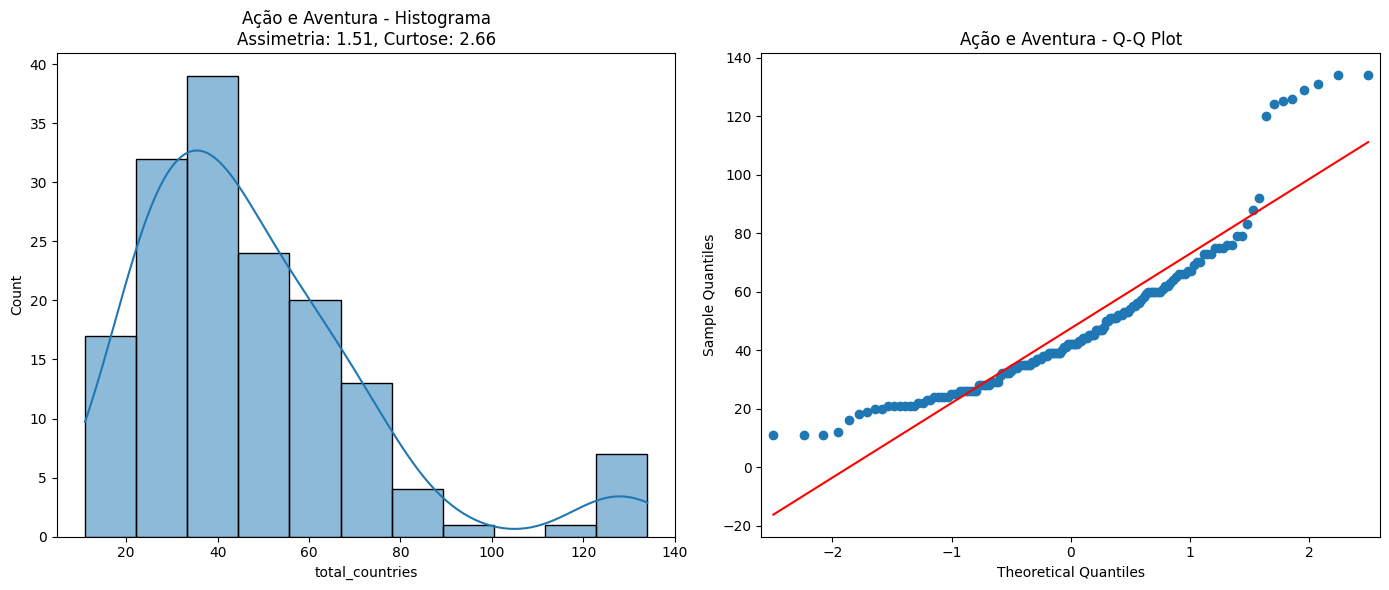

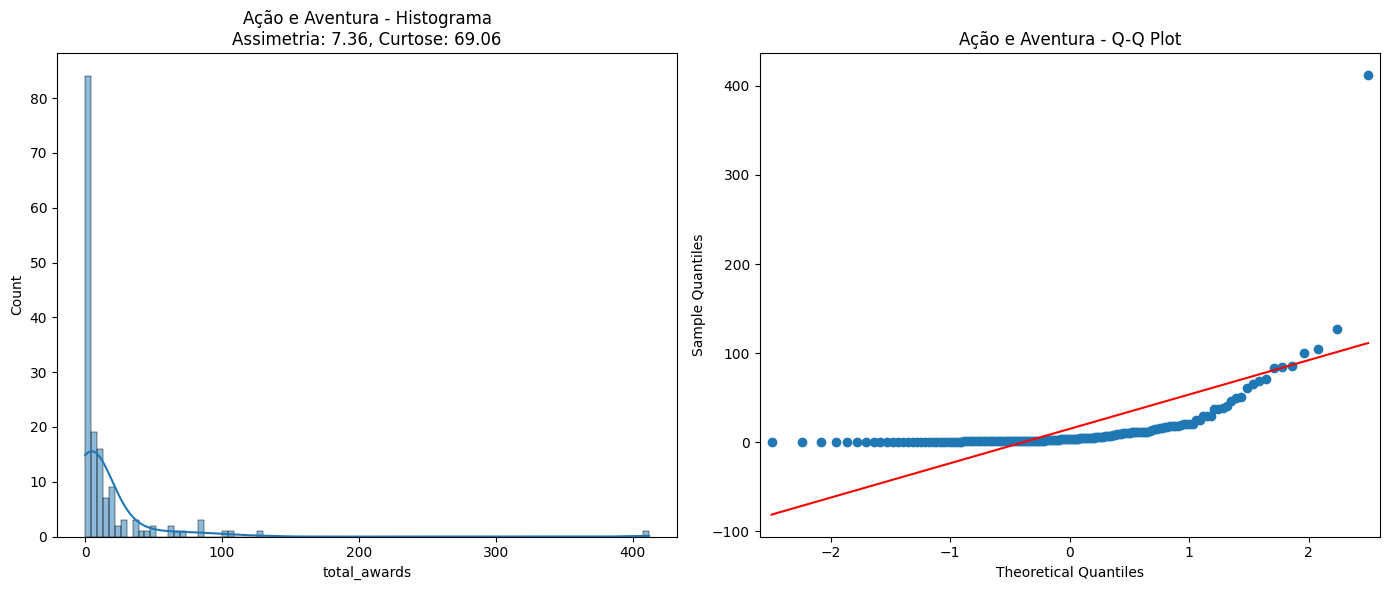

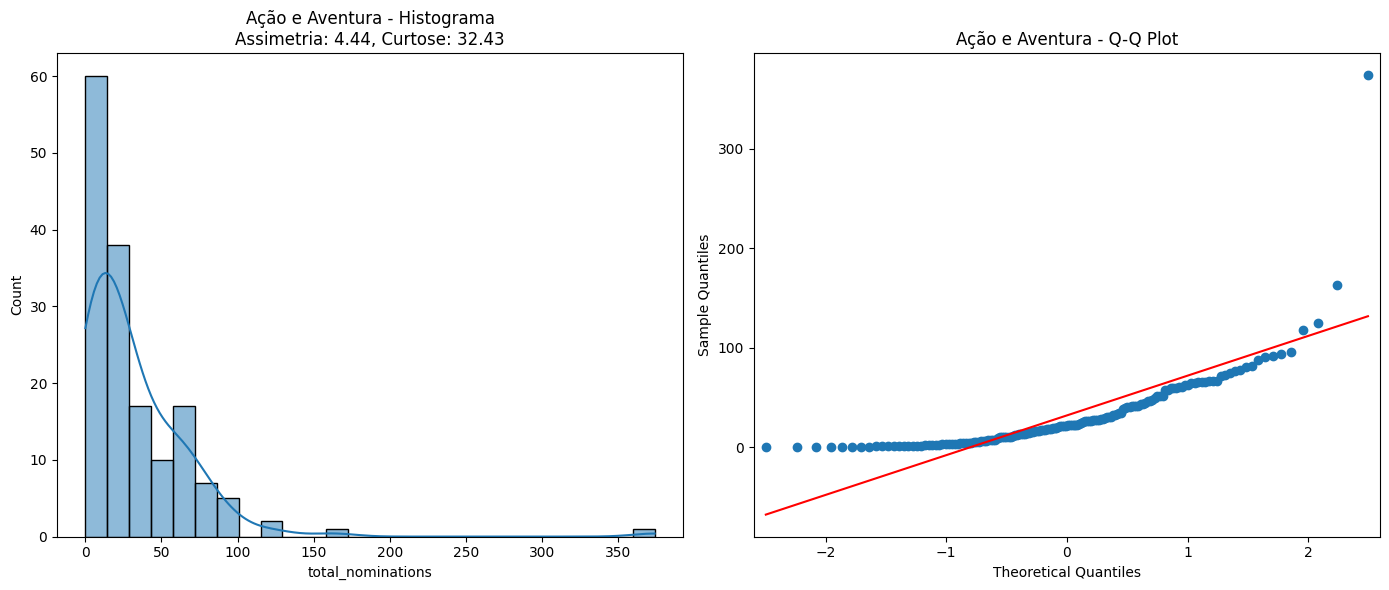

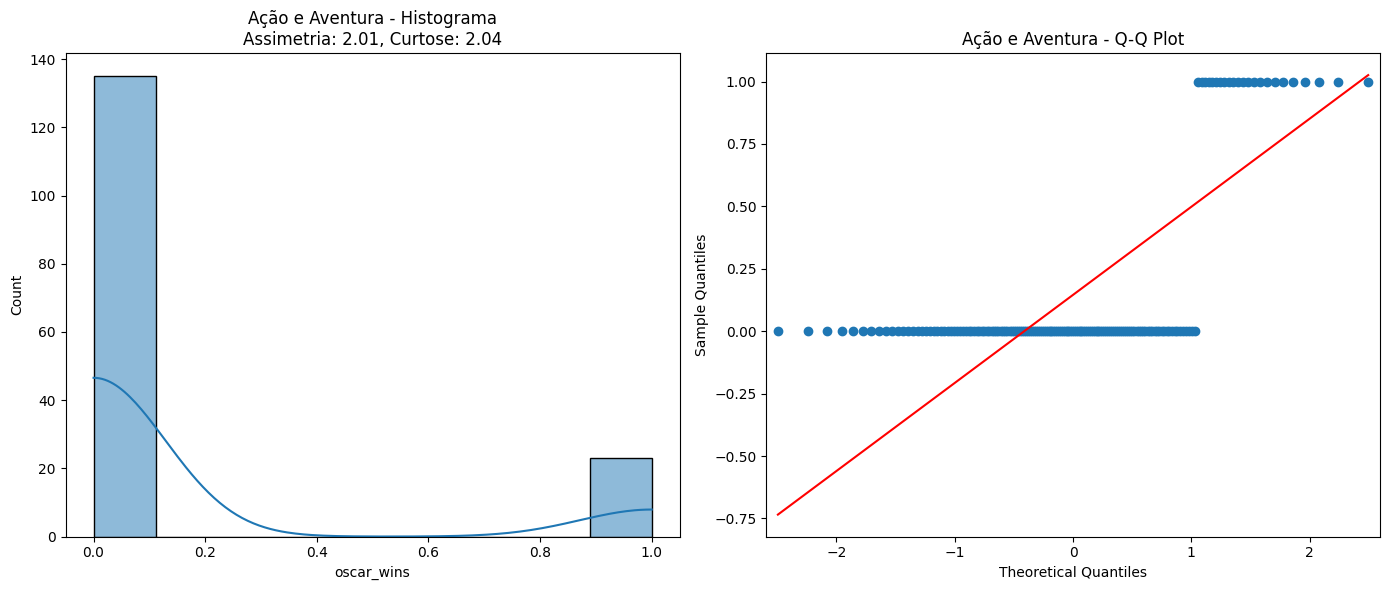

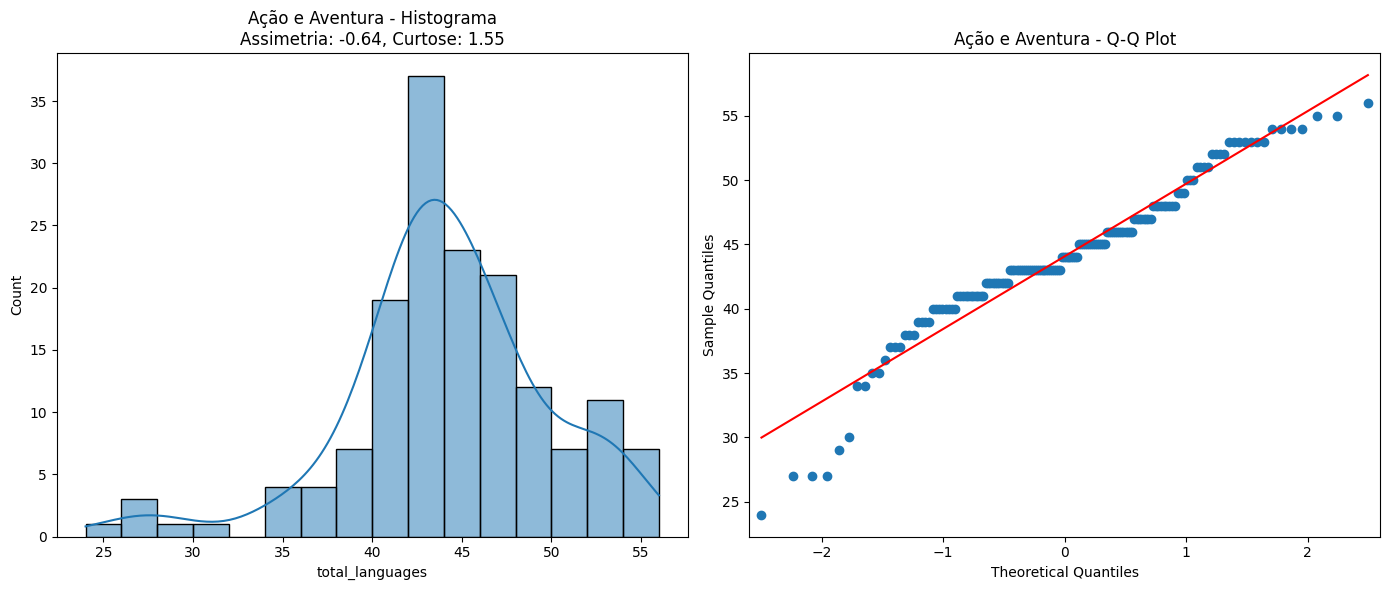

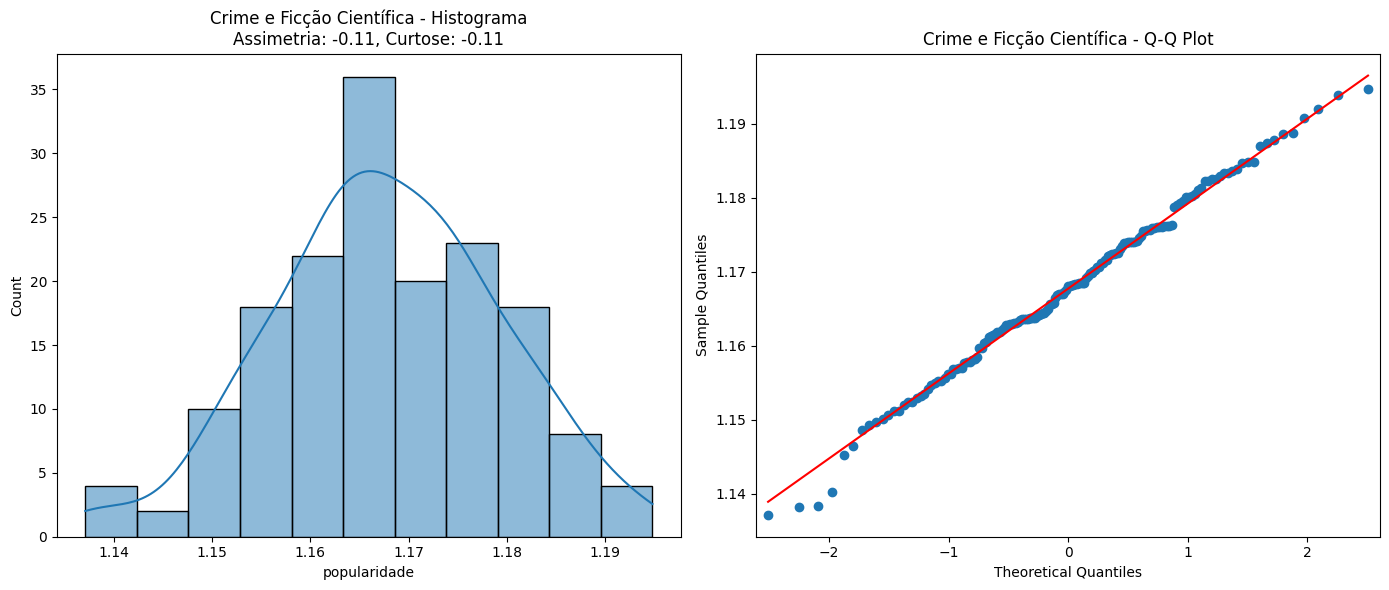

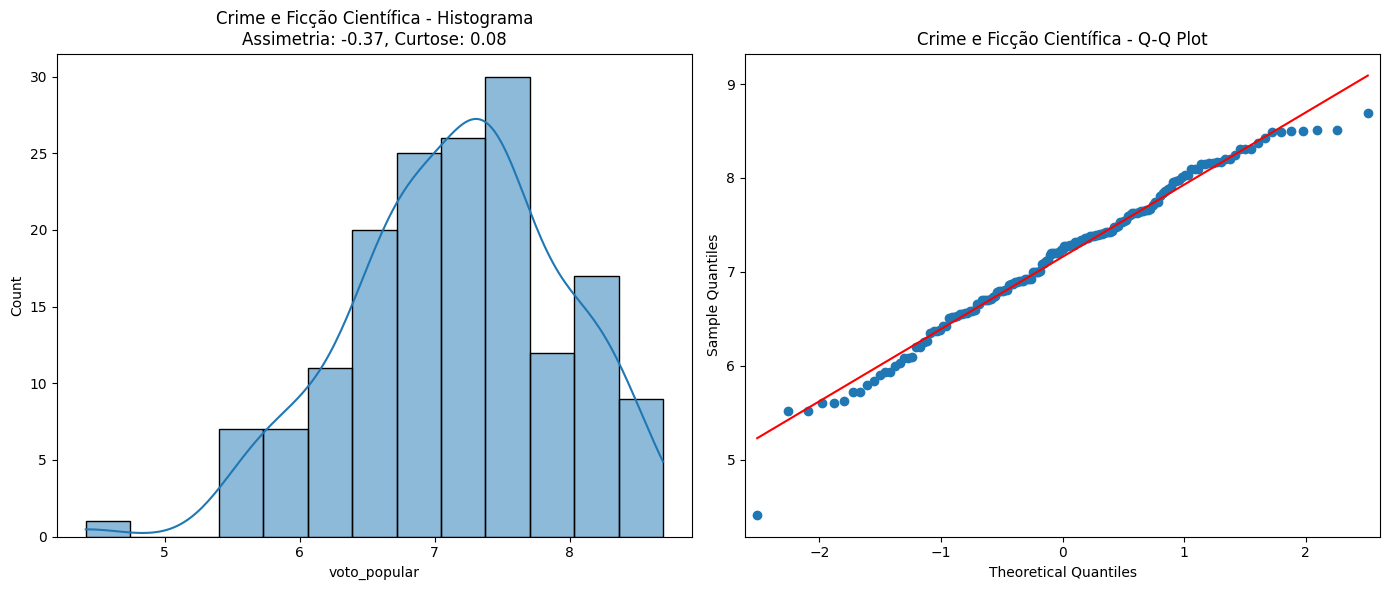

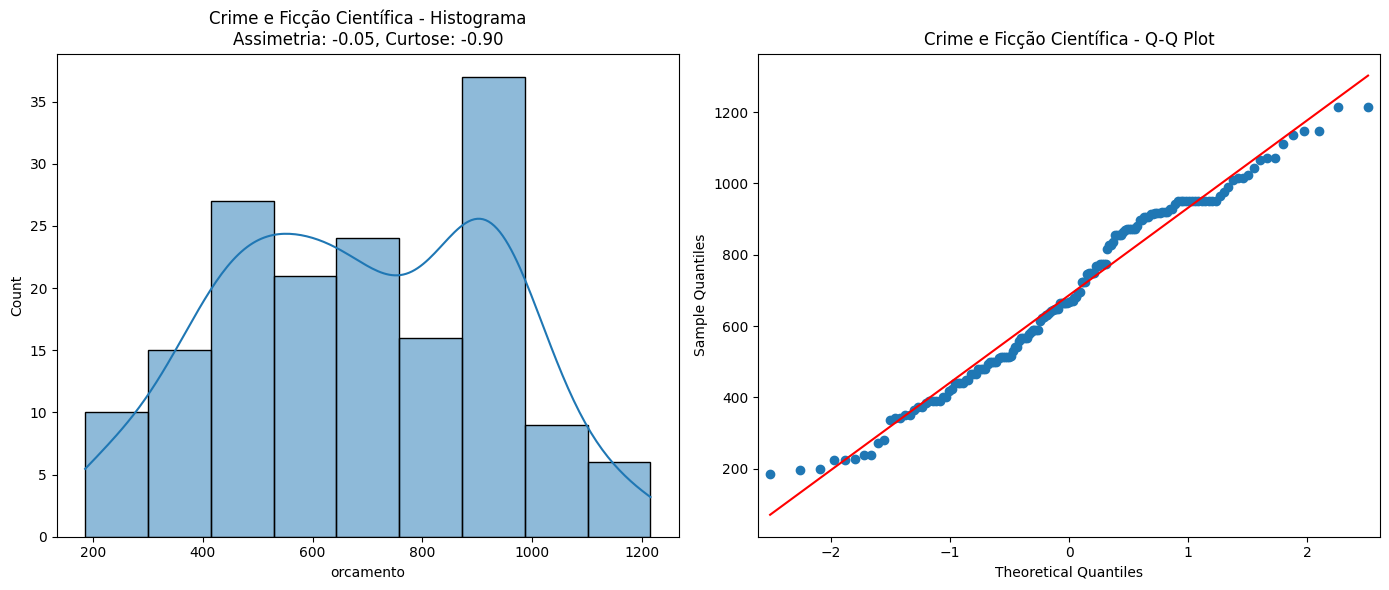

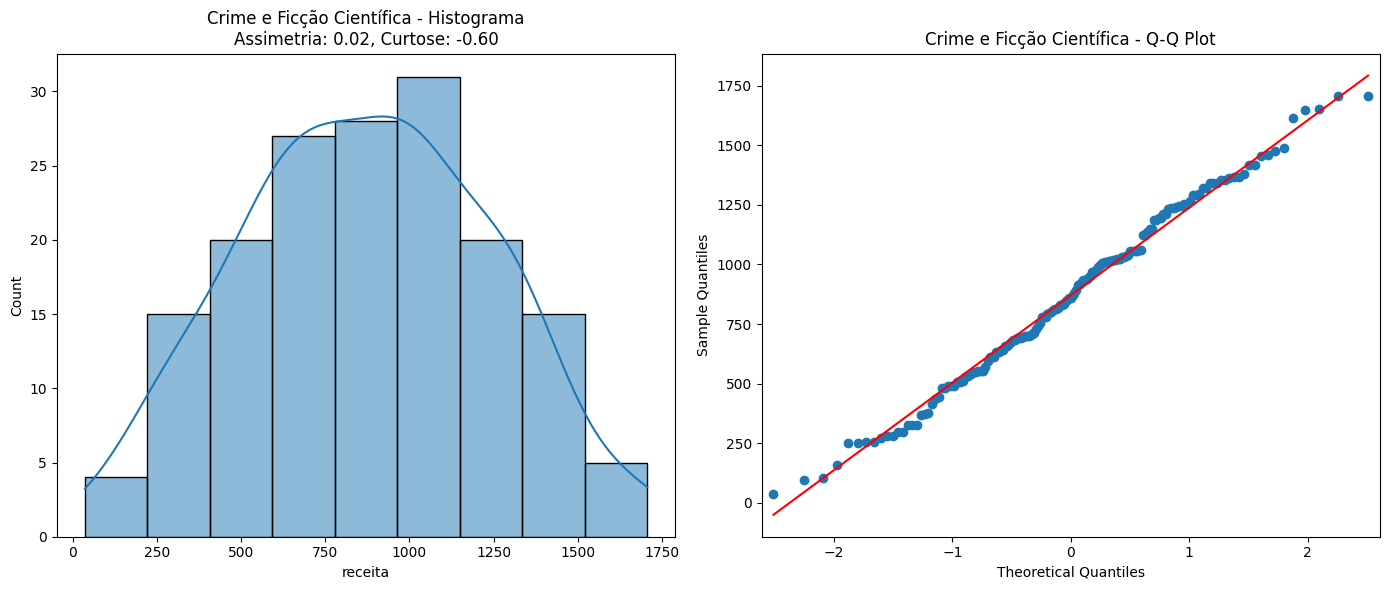

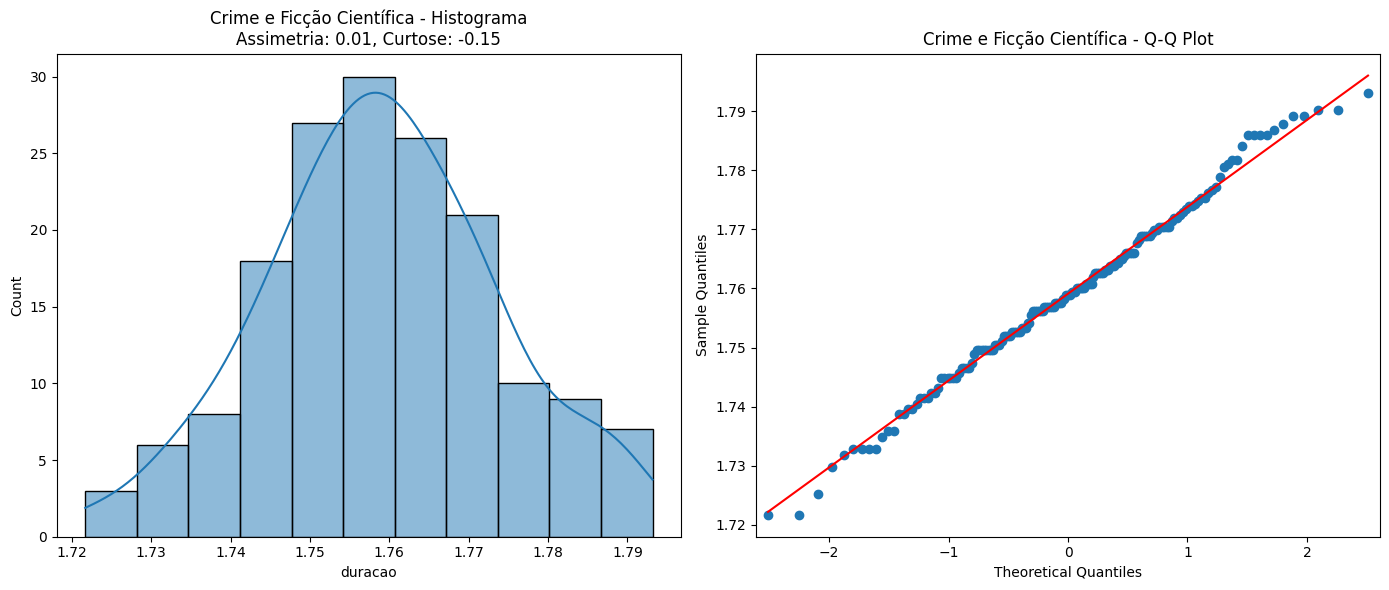

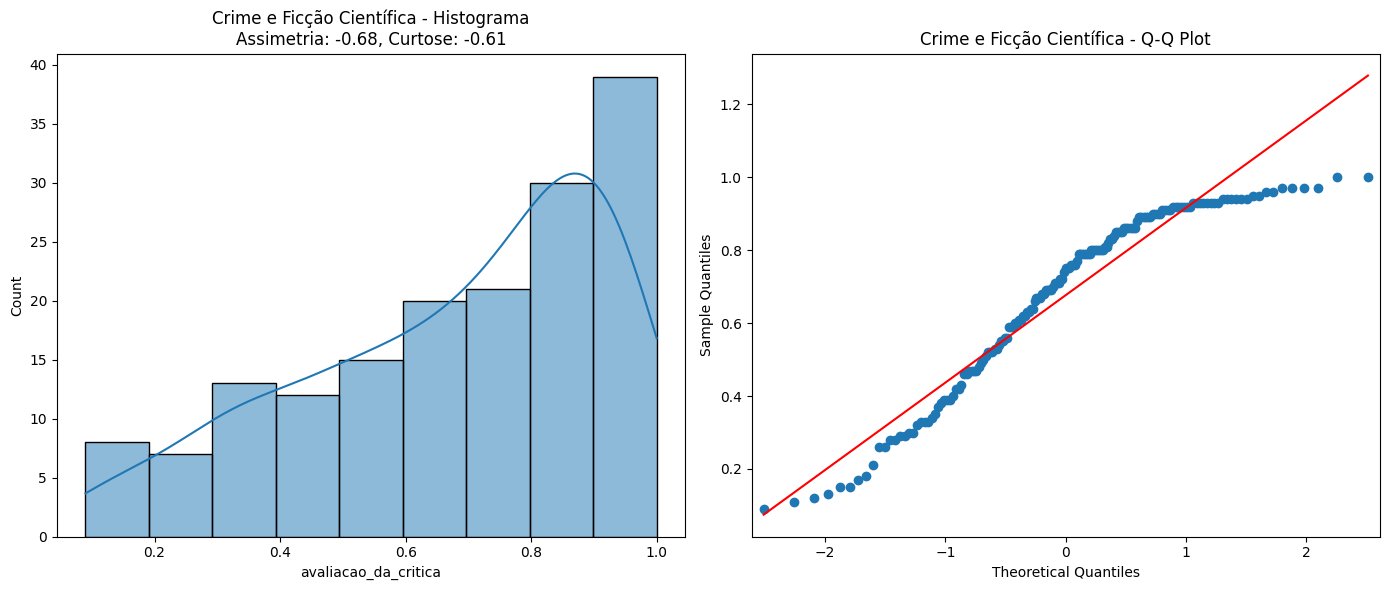

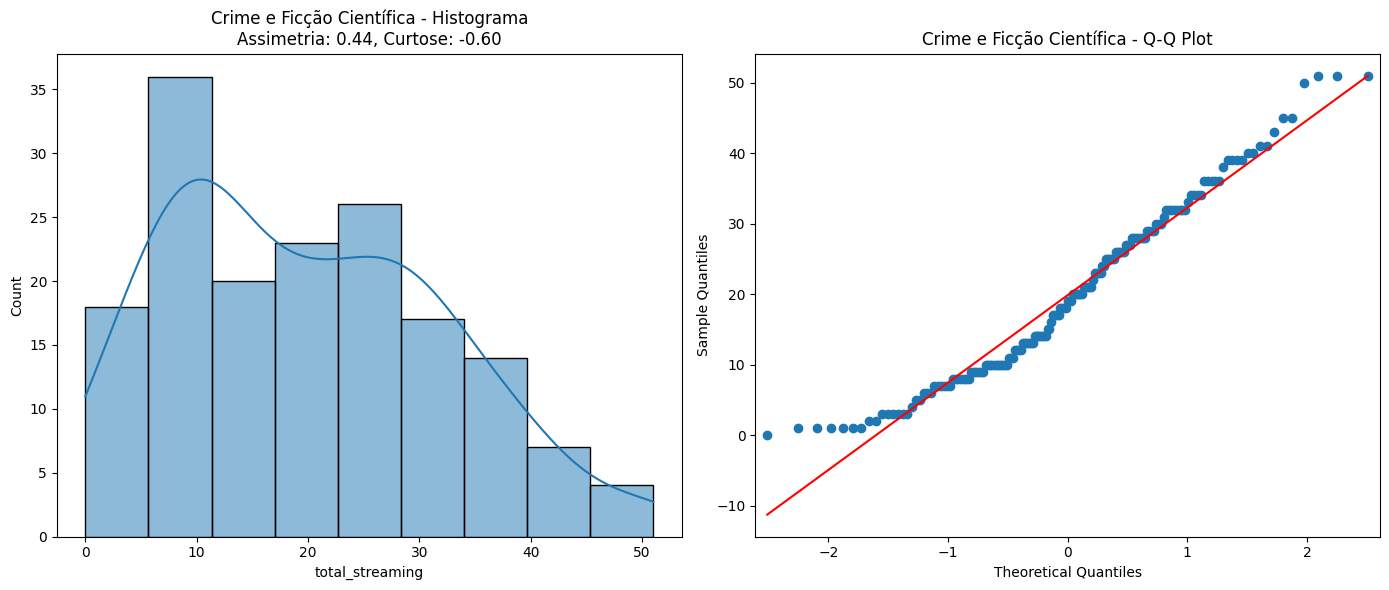

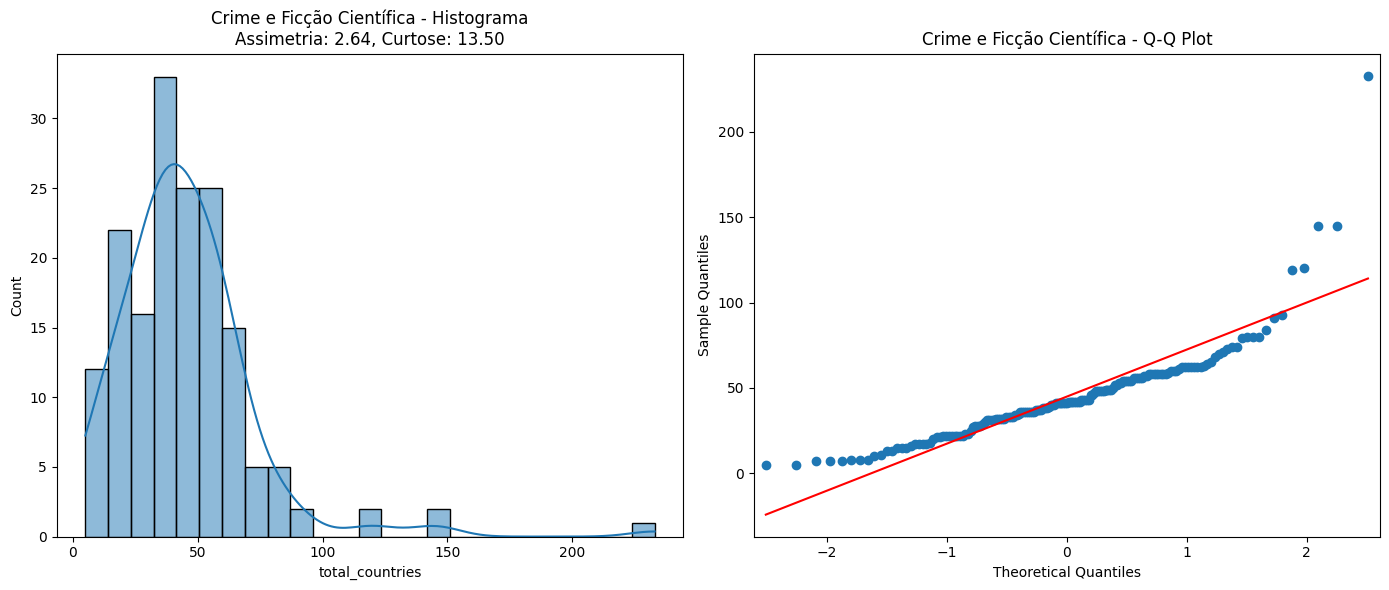

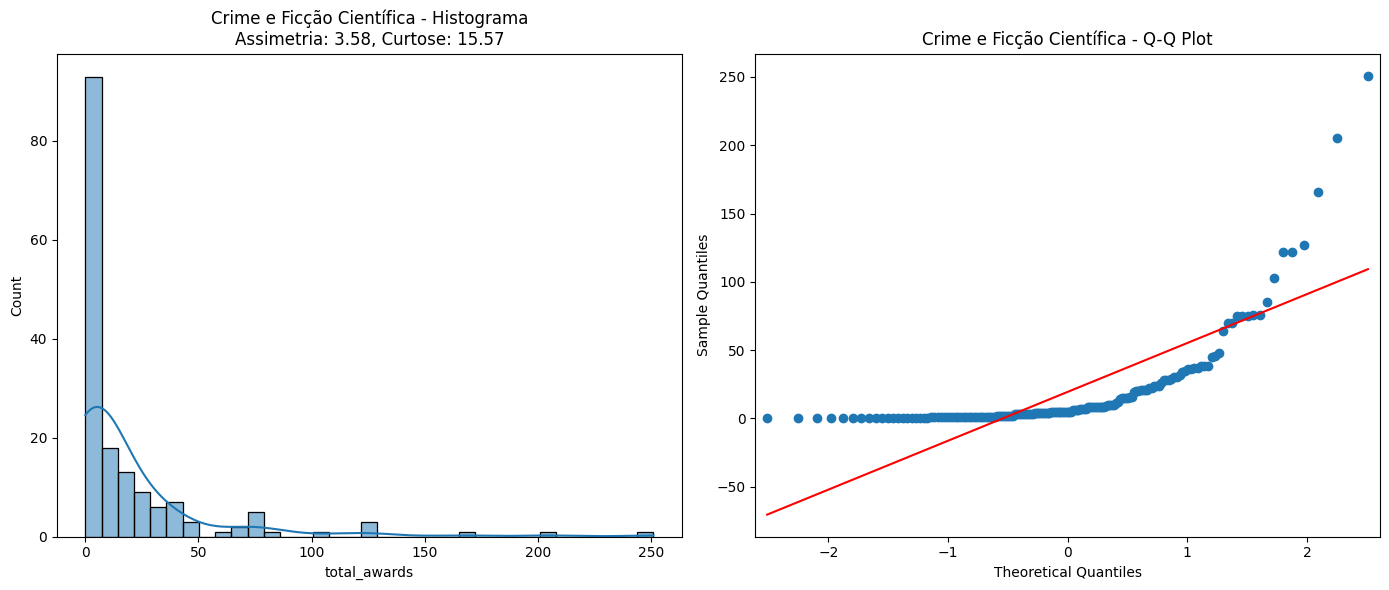

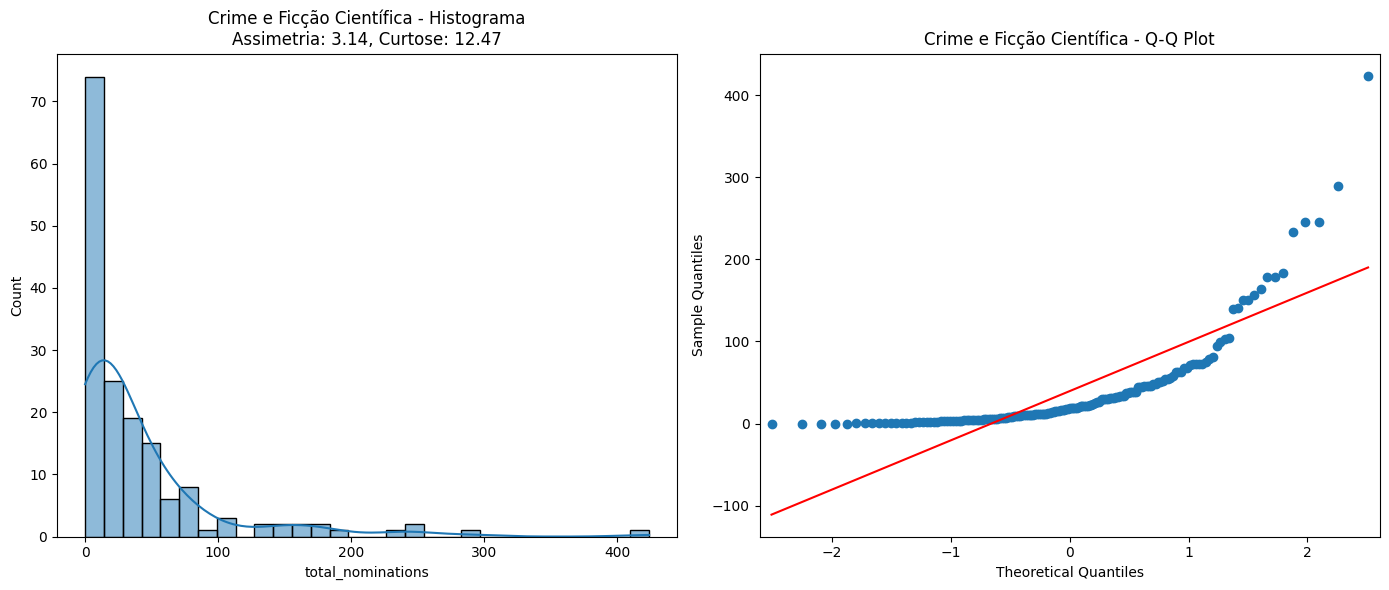

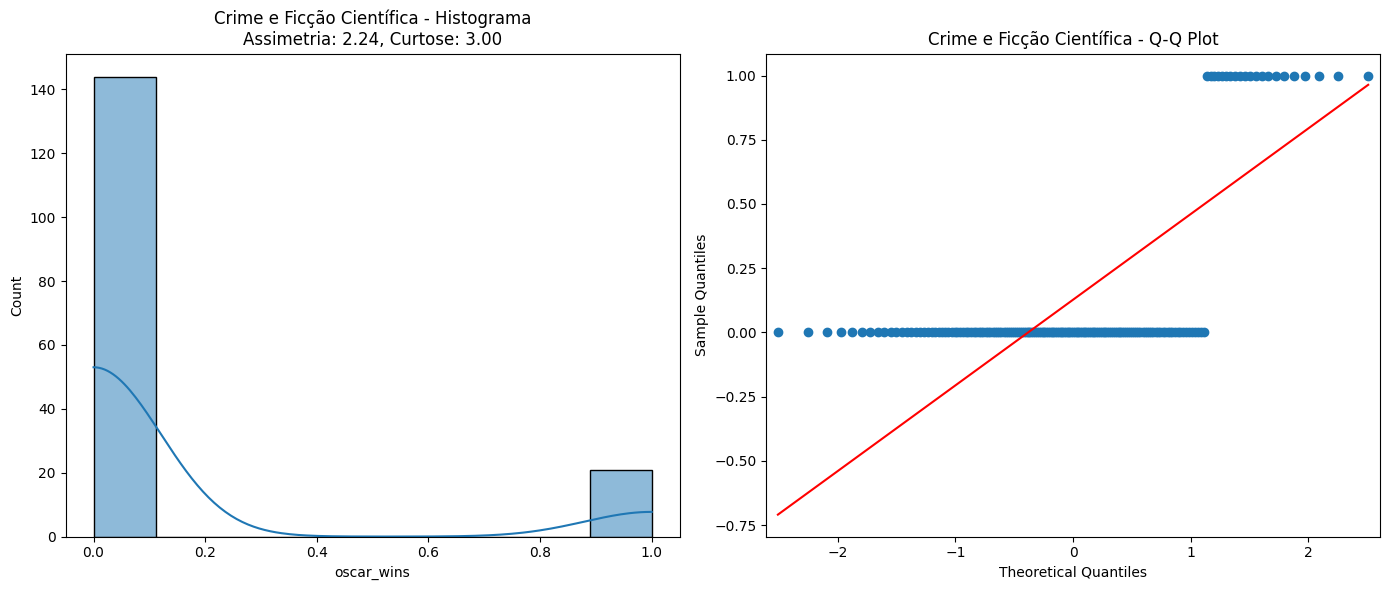

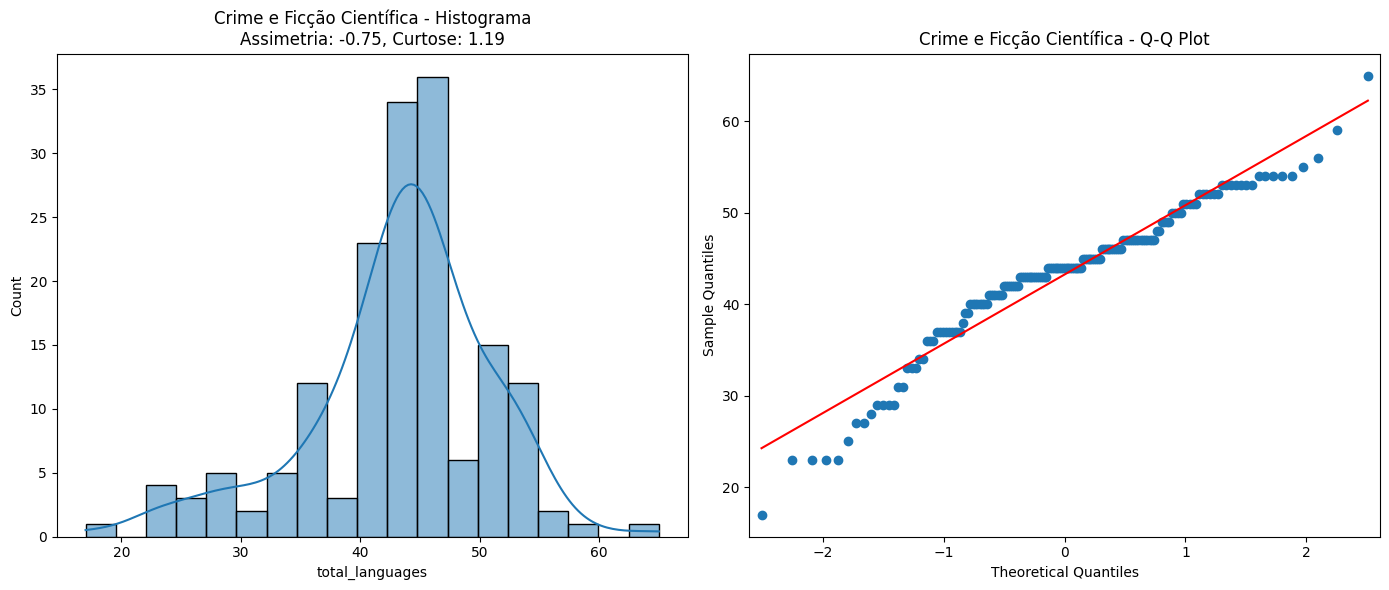

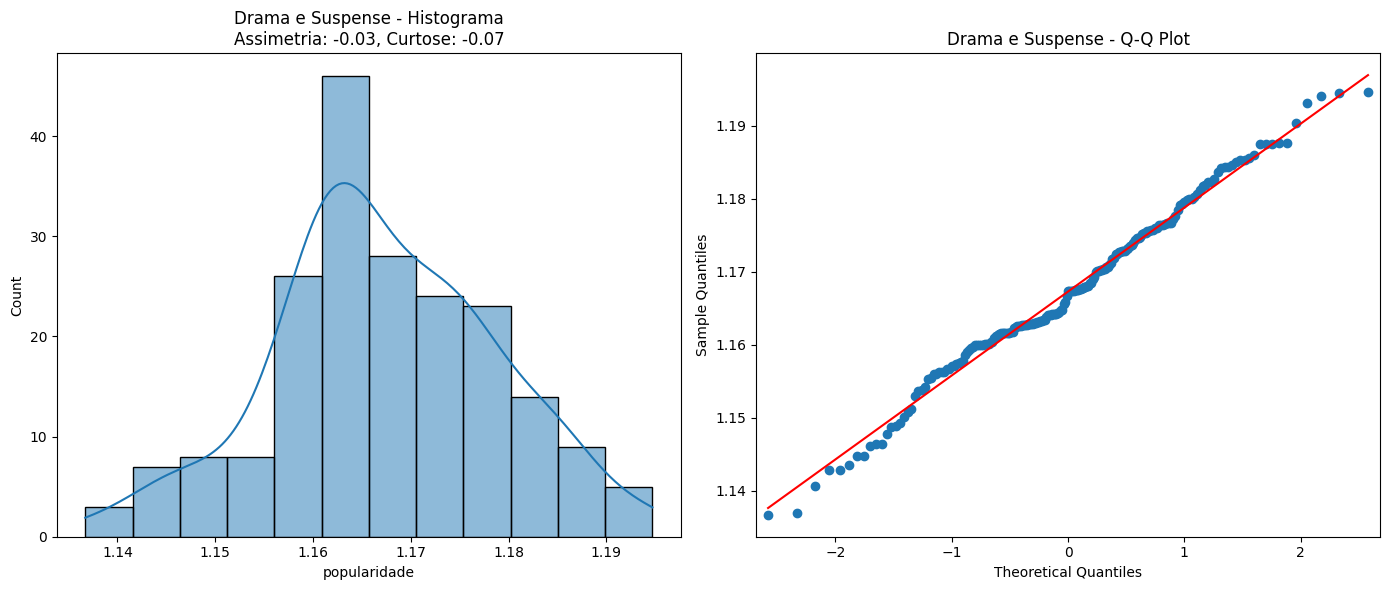

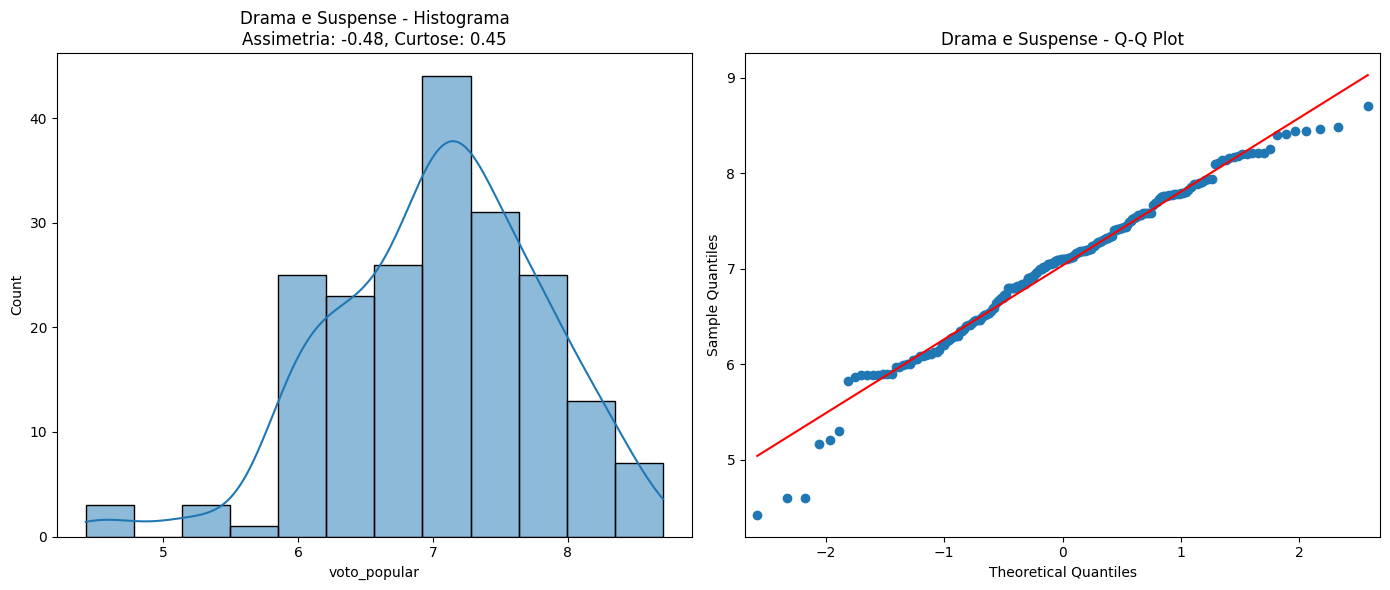

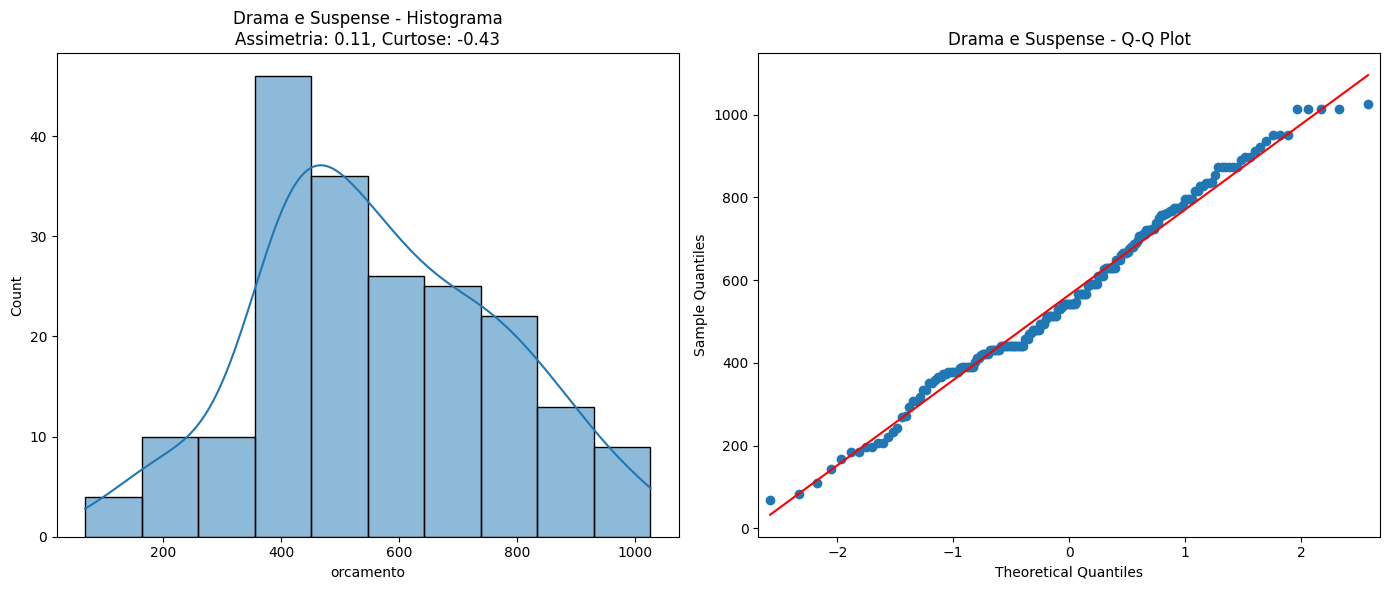

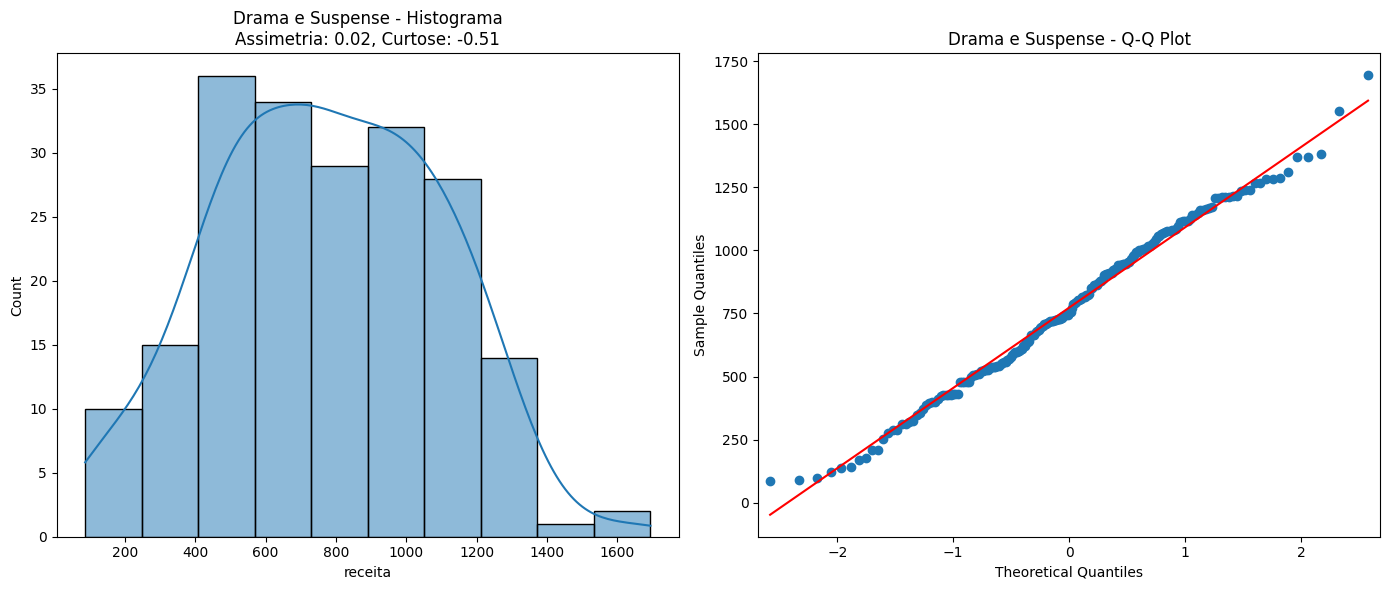

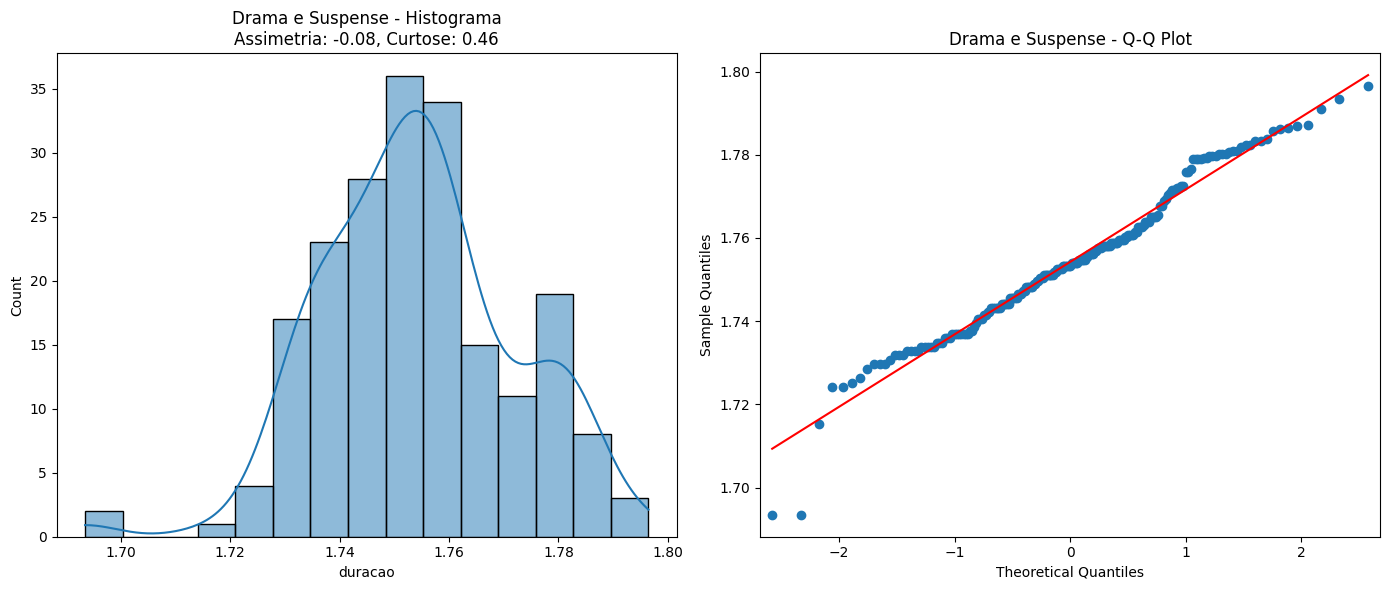

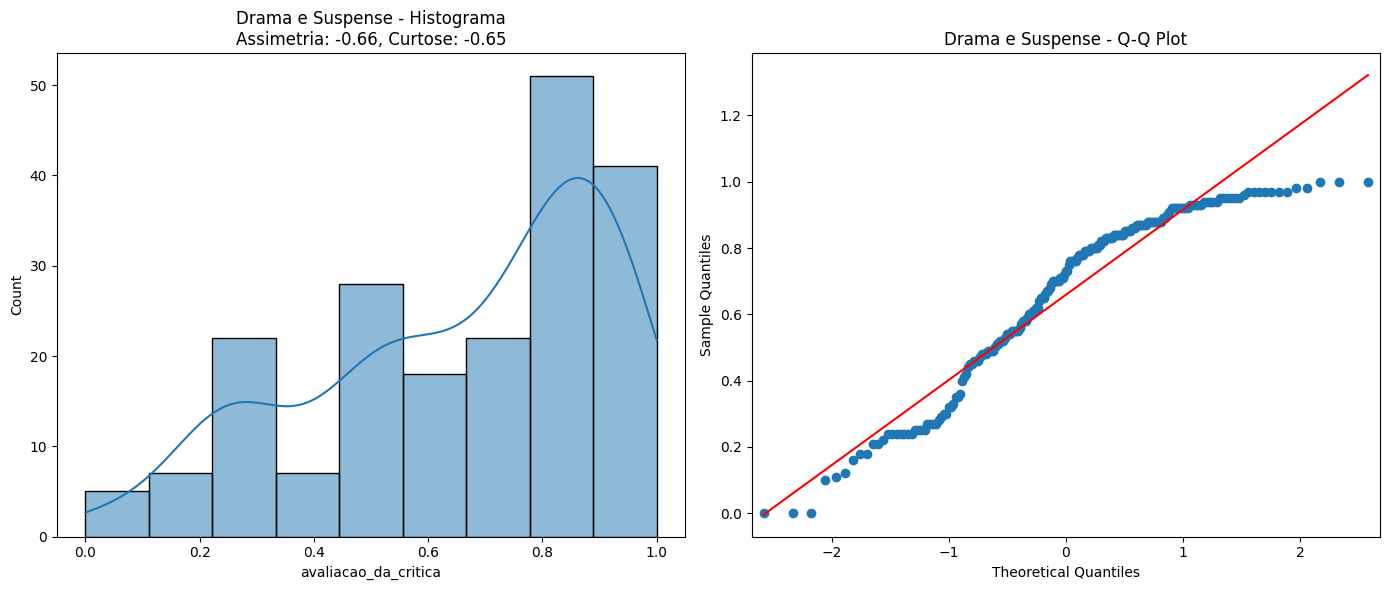

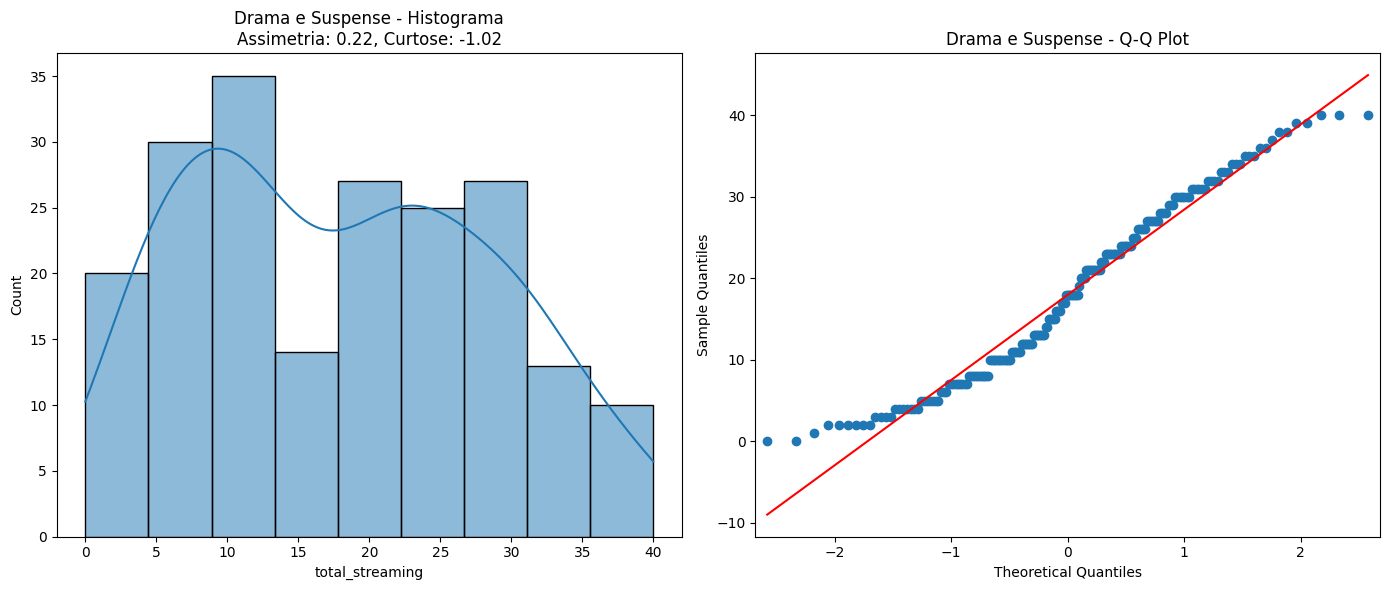

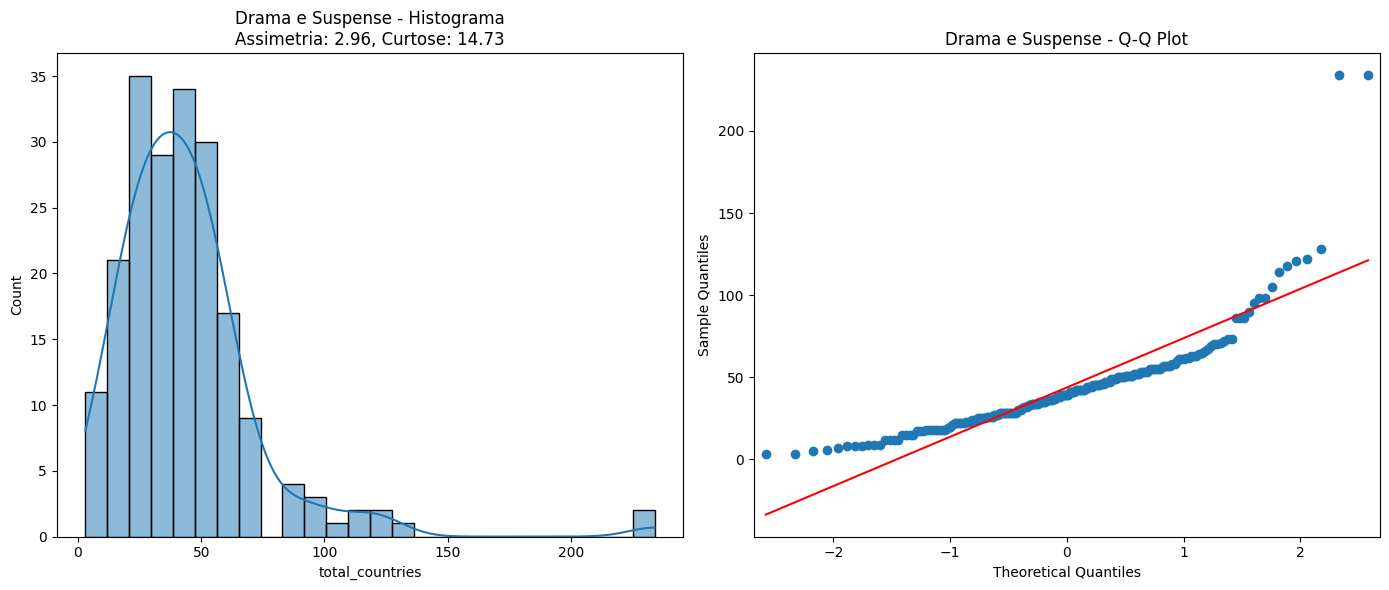

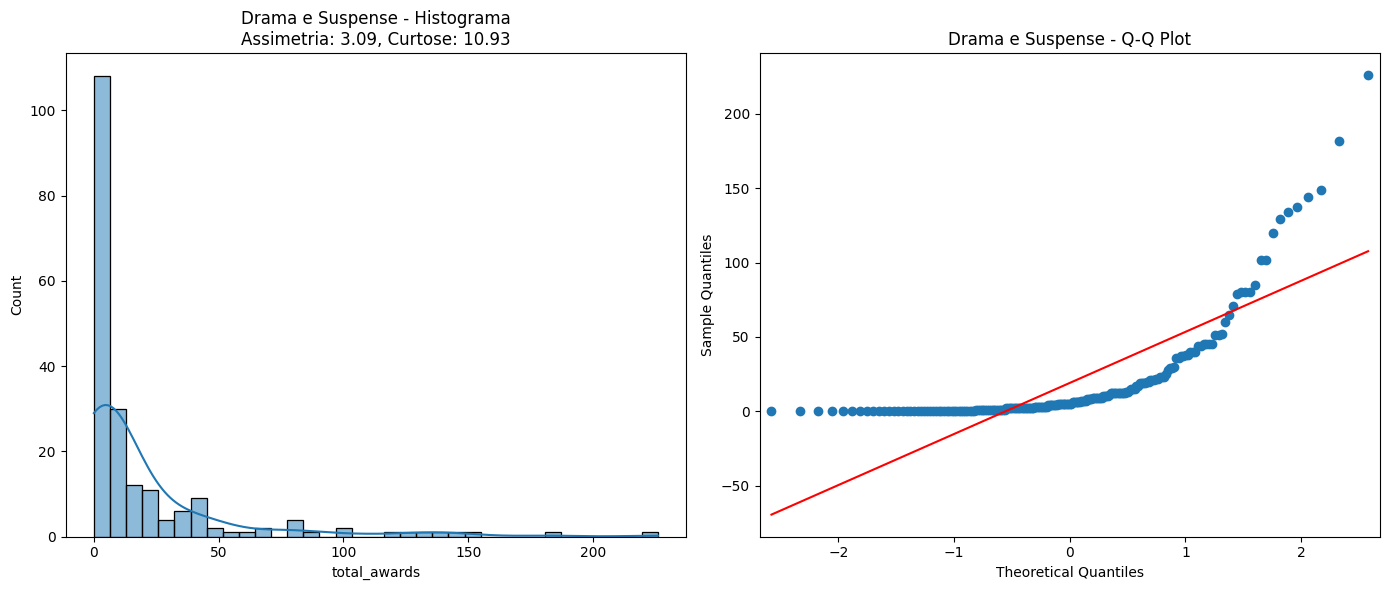

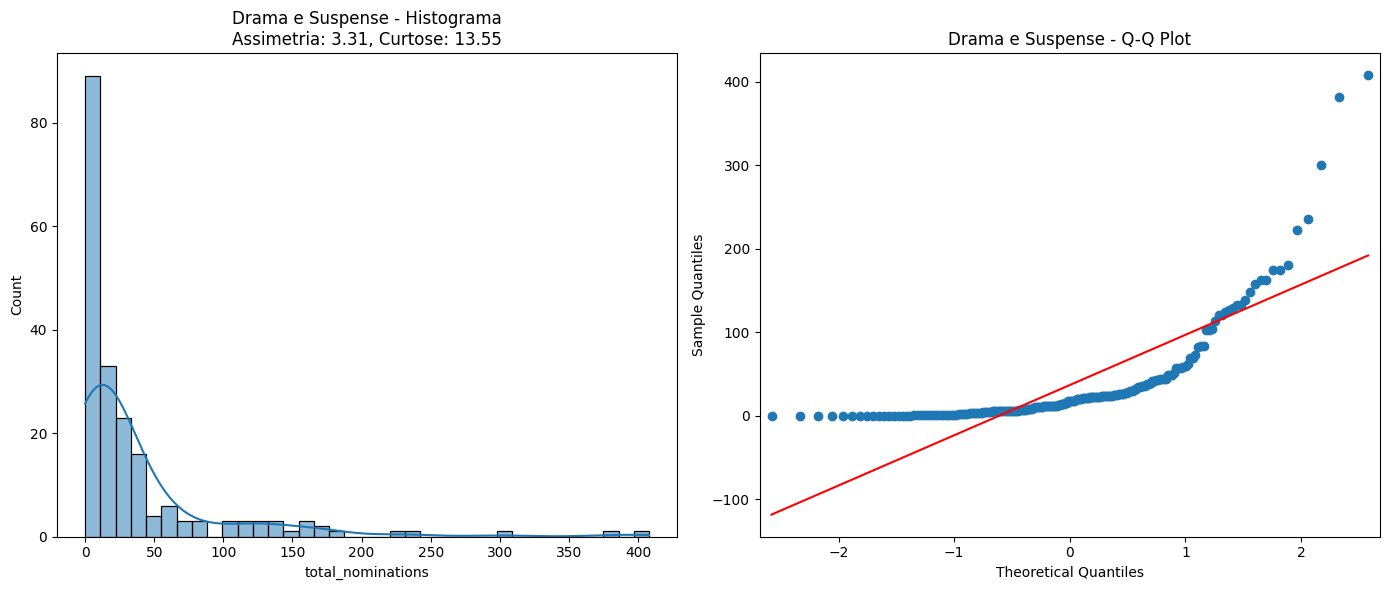

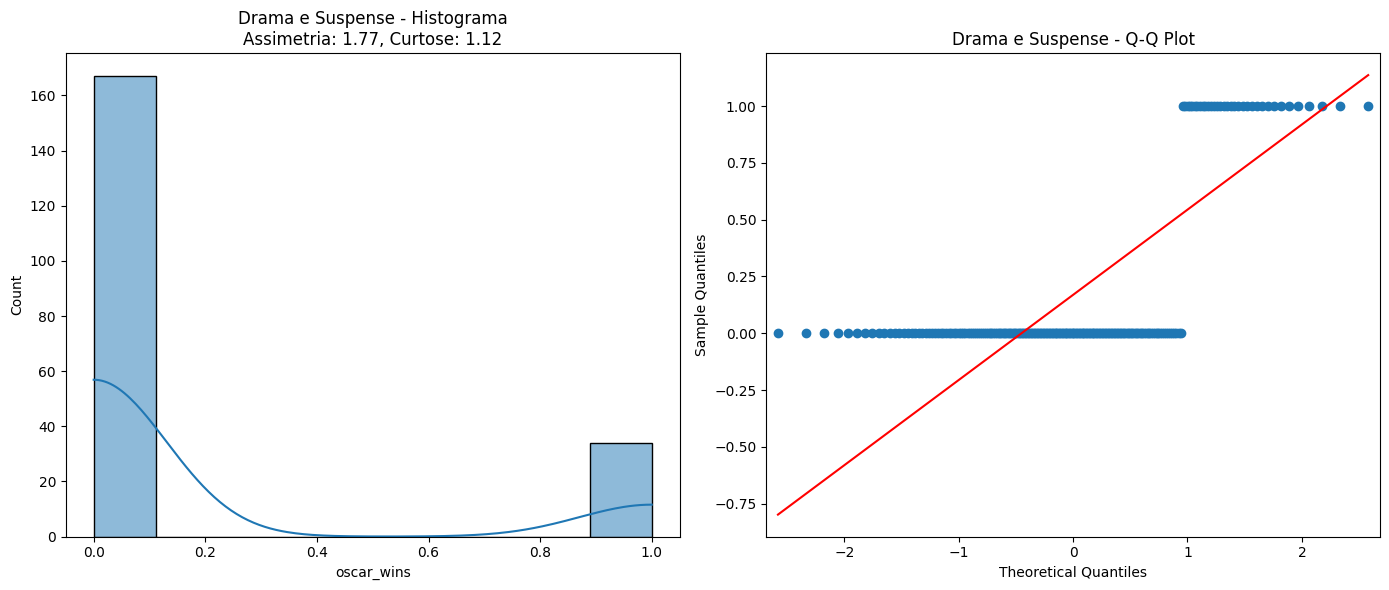

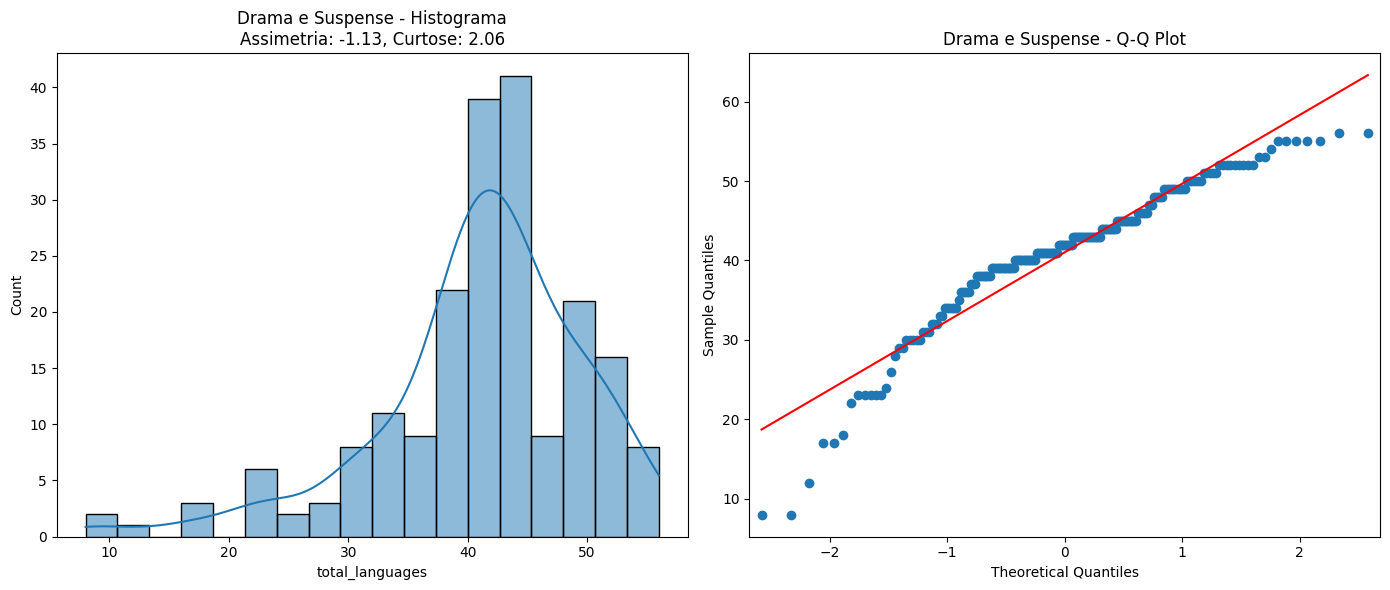

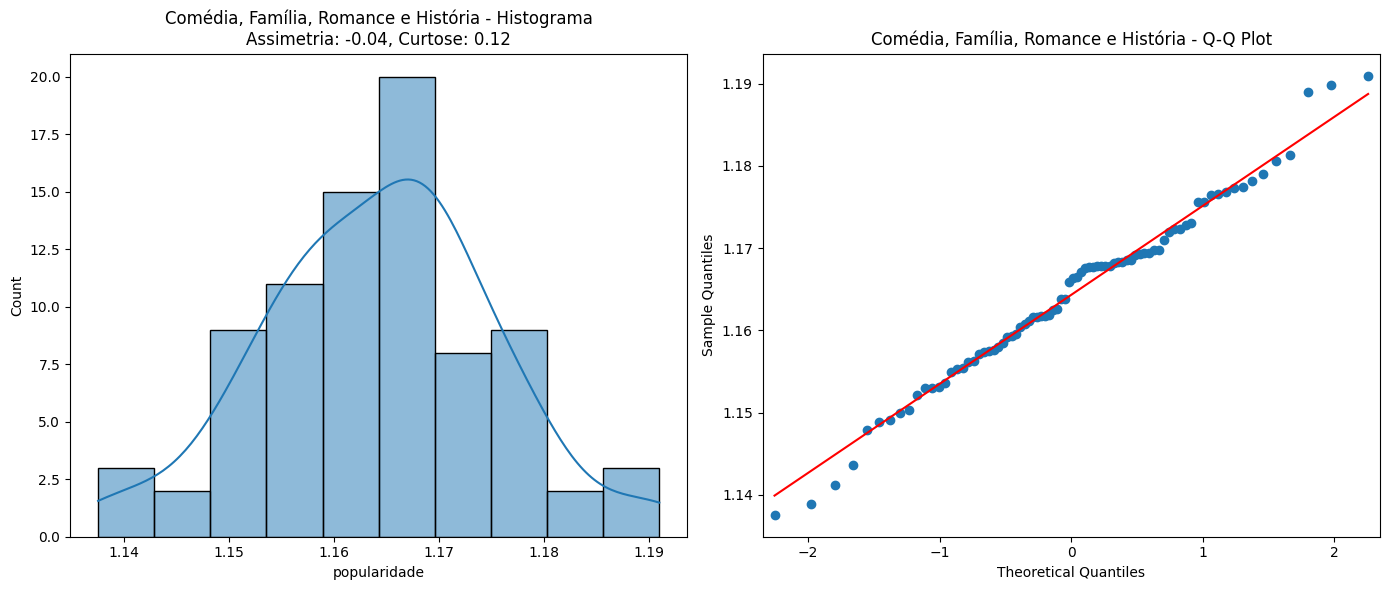

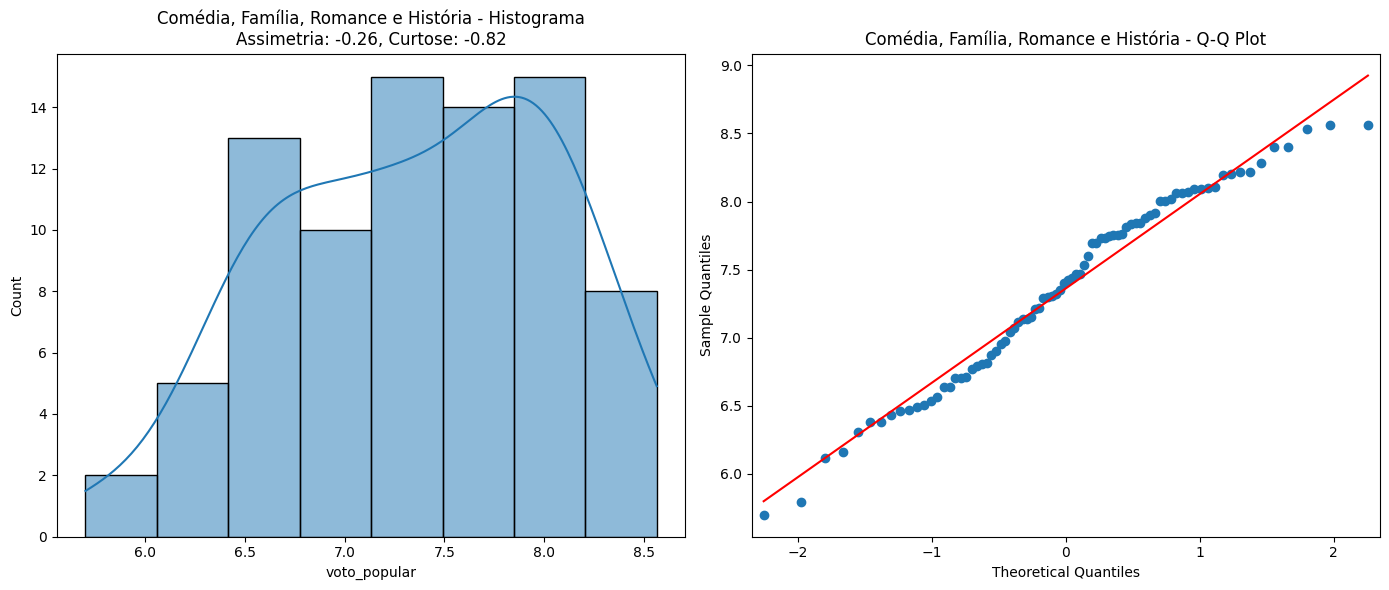

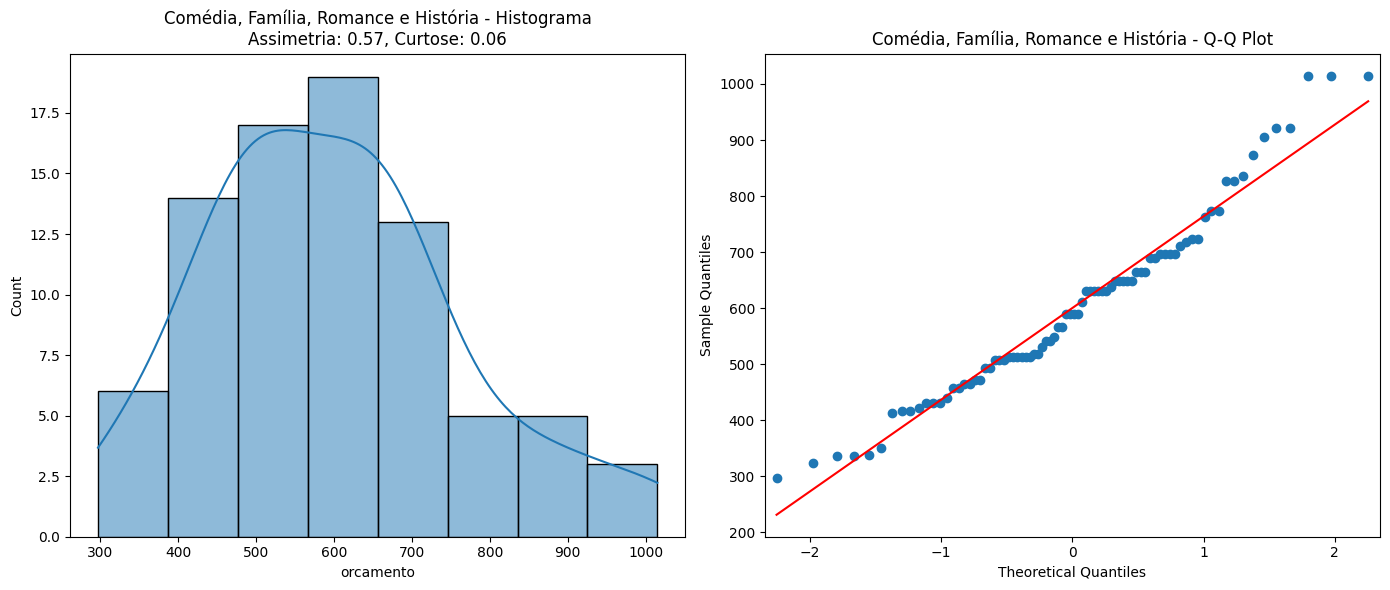

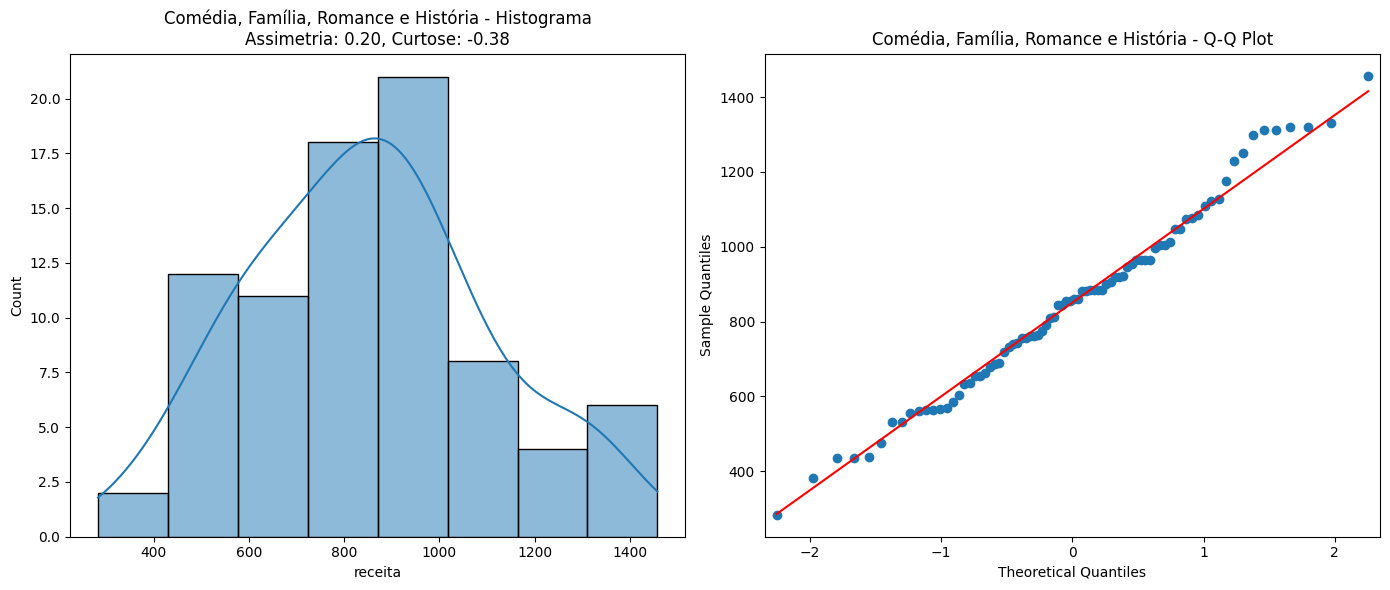

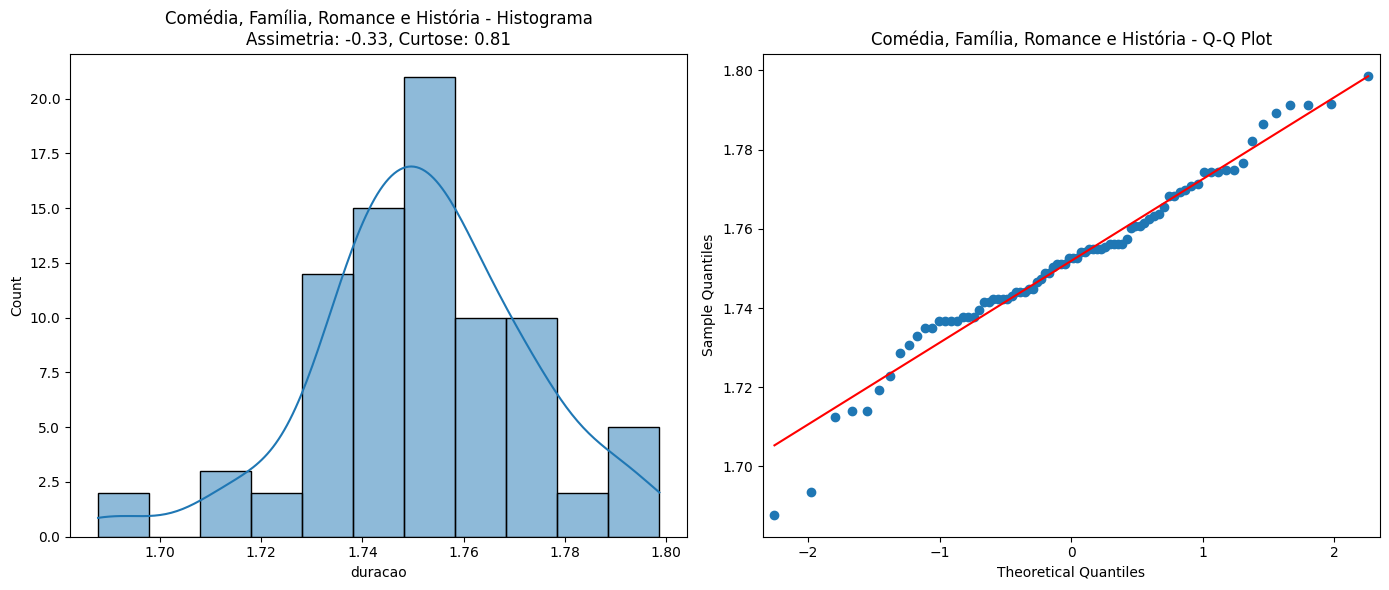

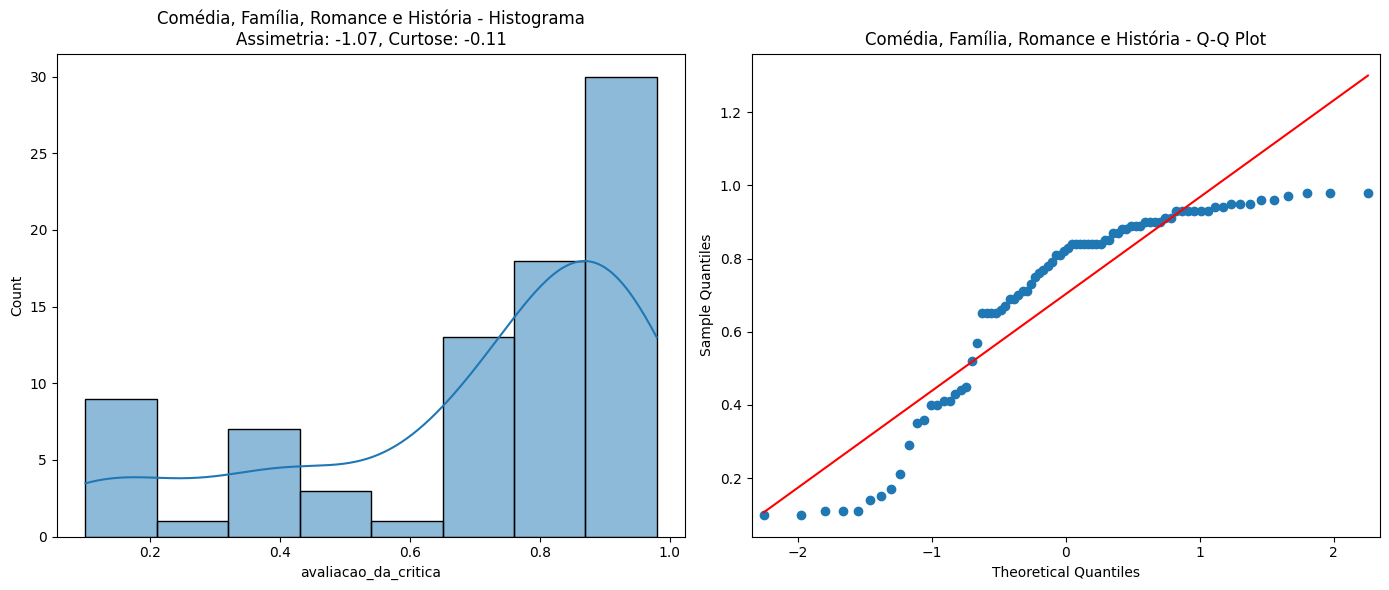

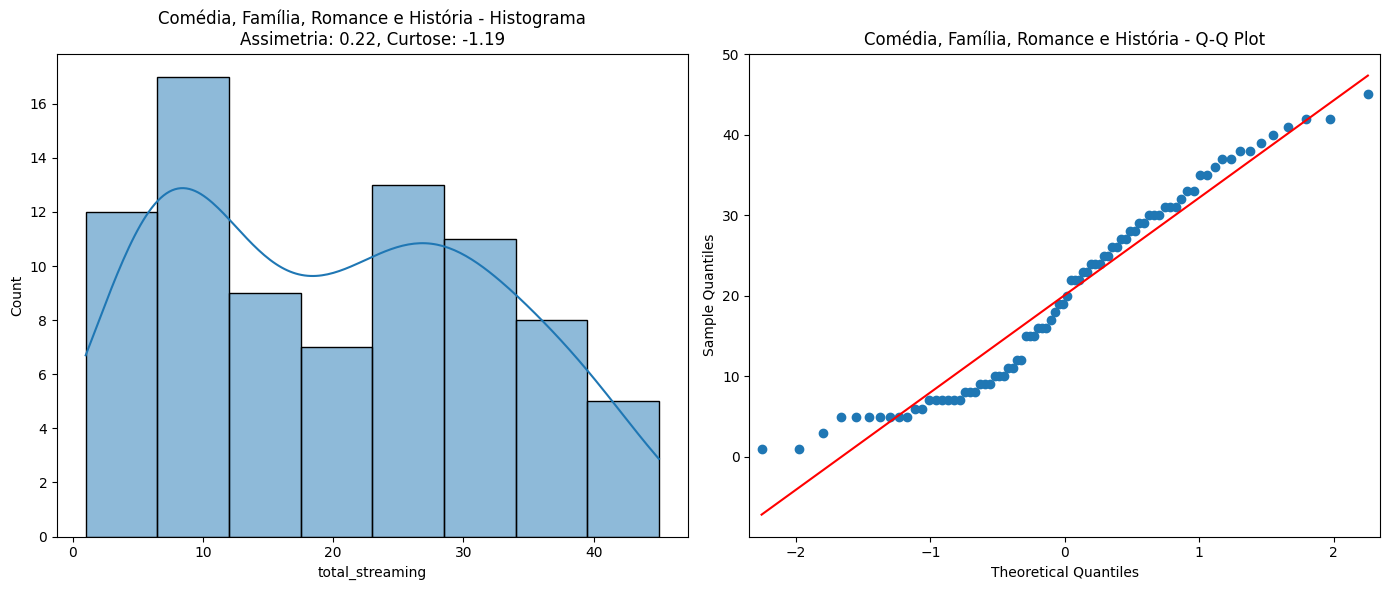

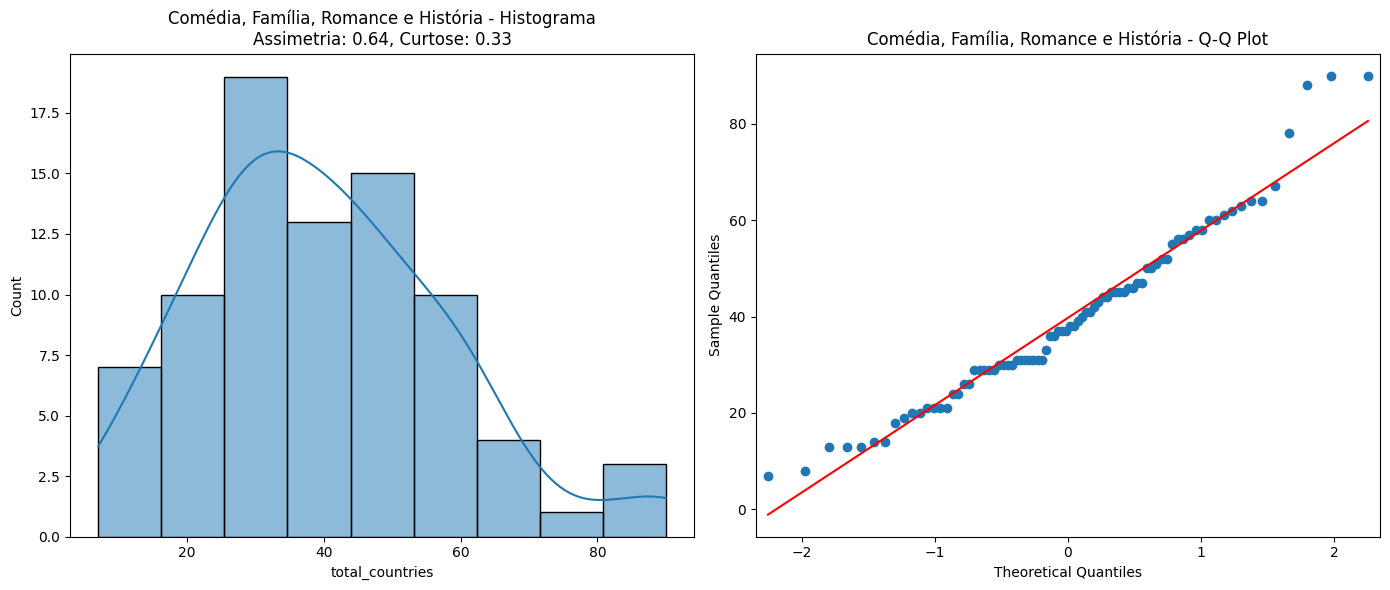

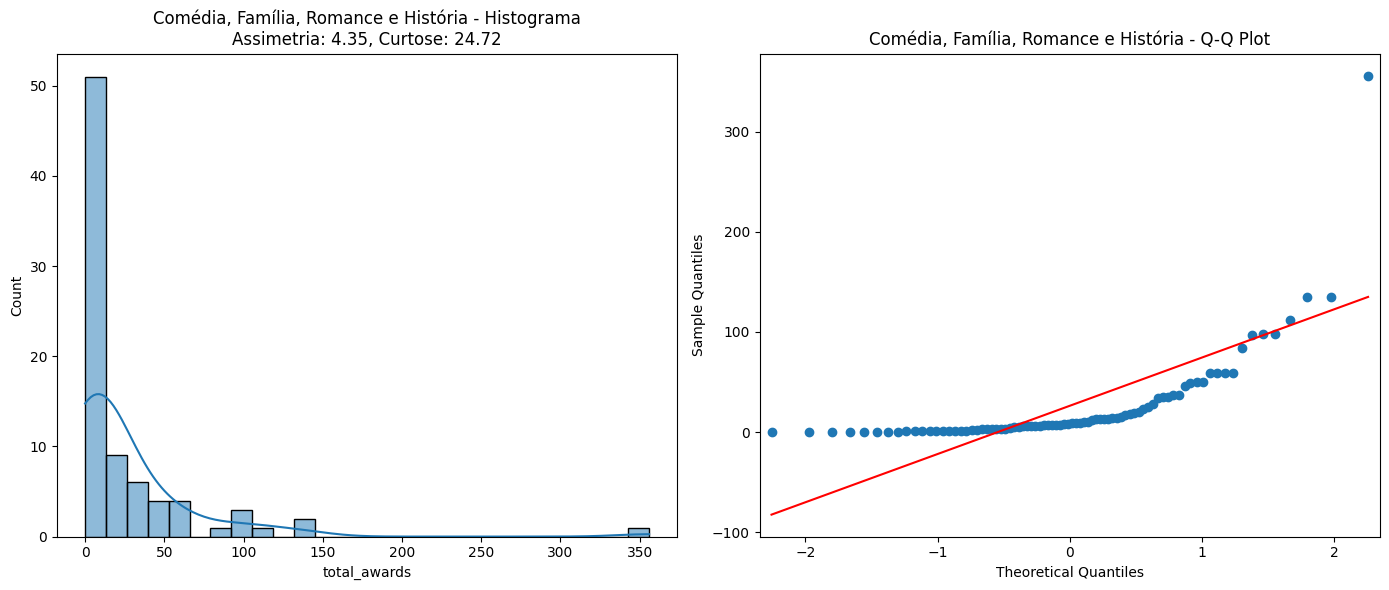

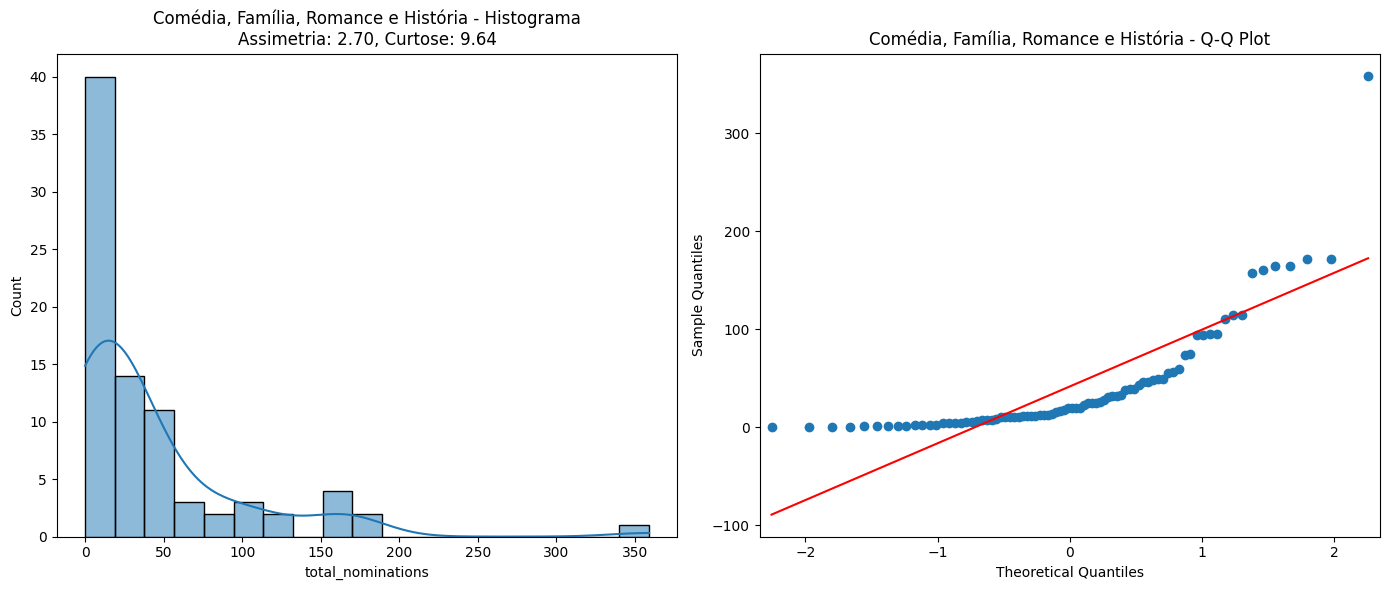

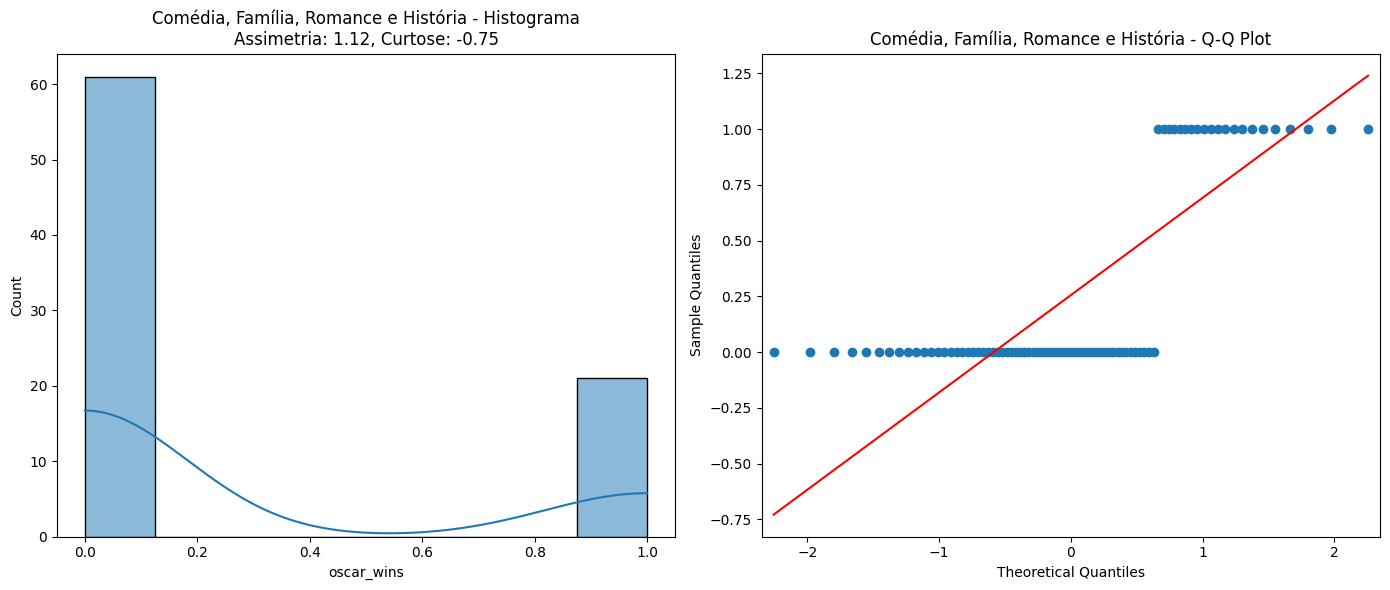

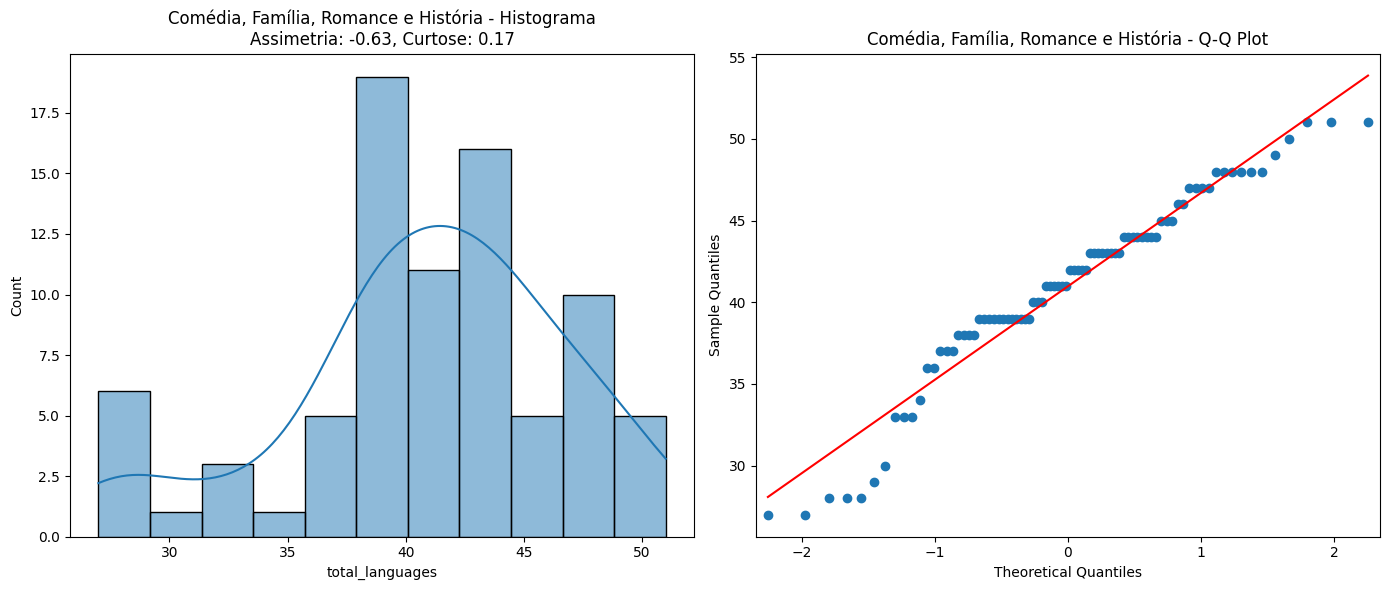

In [16]:
def normalAnalysis(data, column):
    skewness = skew(data[column])
    kurt = kurtosis(data[column], fisher=True) ##normal-kurtosis=0
    return skewness, kurt

def plot(data, column, category):
    skewness, kurt = normalAnalysis(data, column)
    _, axs = plt.subplots(1, 2, figsize=(14,6))
    sns.histplot(data[column], kde=True, ax=axs[0])
    axs[0].set_title(f'{category} - Histograma\nAssimetria: {skewness:.2f}, Curtose: {kurt:.2f}')
    sm.qqplot(data[column], line='s', ax=axs[1])
    axs[1].set_title(f'{category} - Q-Q Plot')
    plt.tight_layout()
    plt.show()

for category in Y.unique():
    for column in X.columns:
        aux = X[Y == category]
        plot(aux, column, category)

## Realiza-se o tratamento de normalidade para as varíaveis que não se encontram em tal estado

In [21]:
pt = PowerTransformer(method='yeo-johnson')
df[['total_awards', 'total_countries', 'total_nominations']] = pt.fit_transform(
    df[['total_awards', 'total_countries', 'total_nominations']]
)

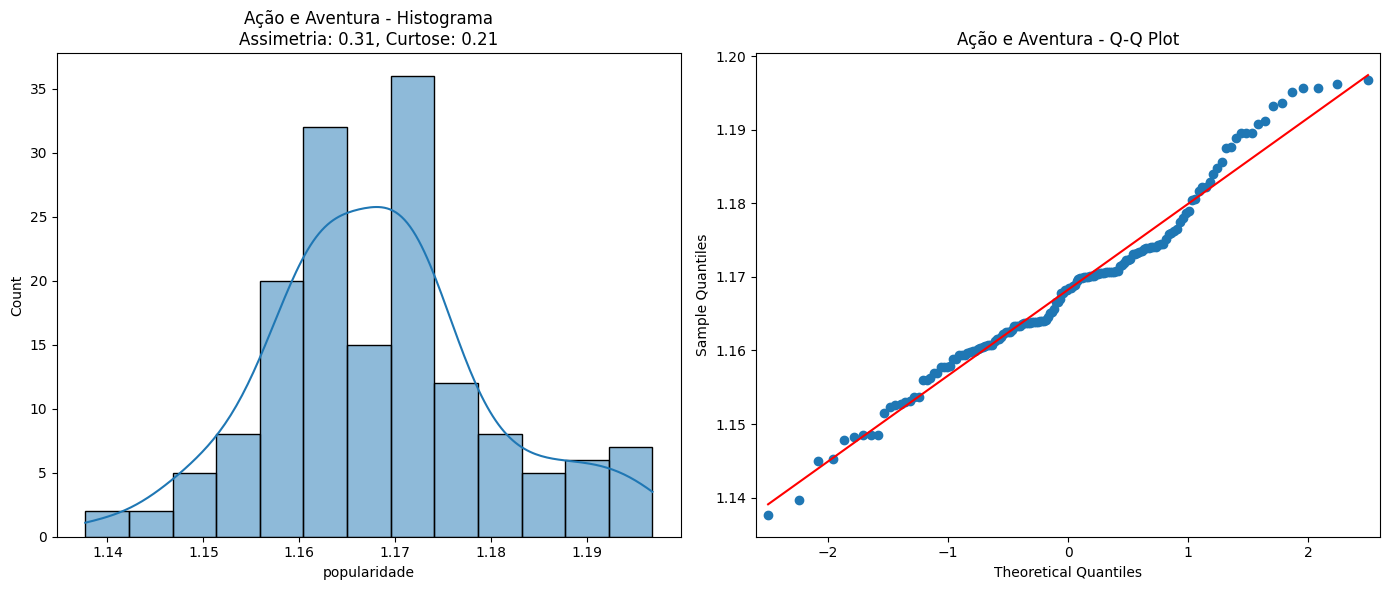

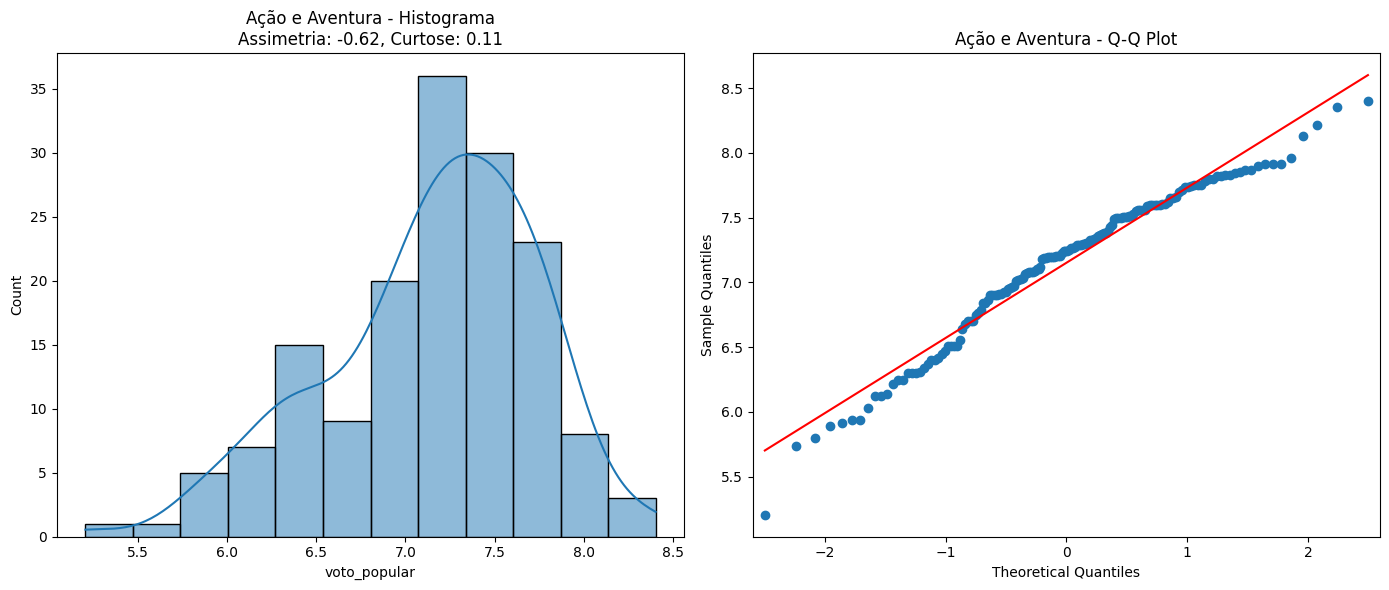

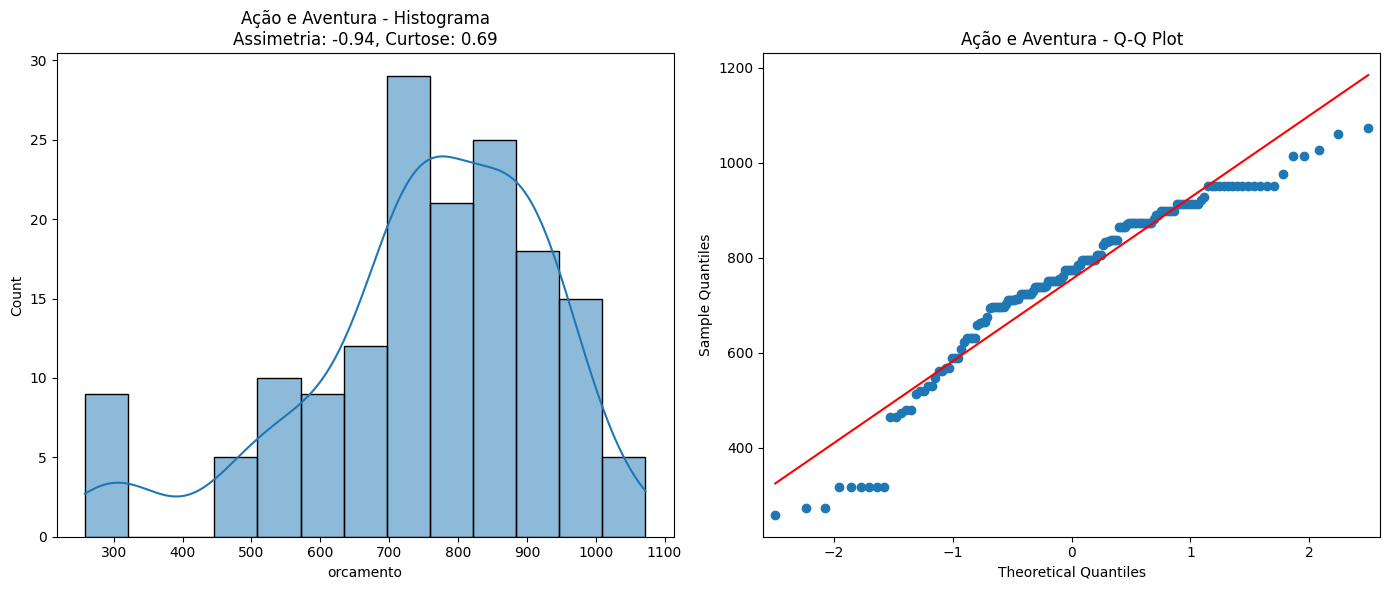

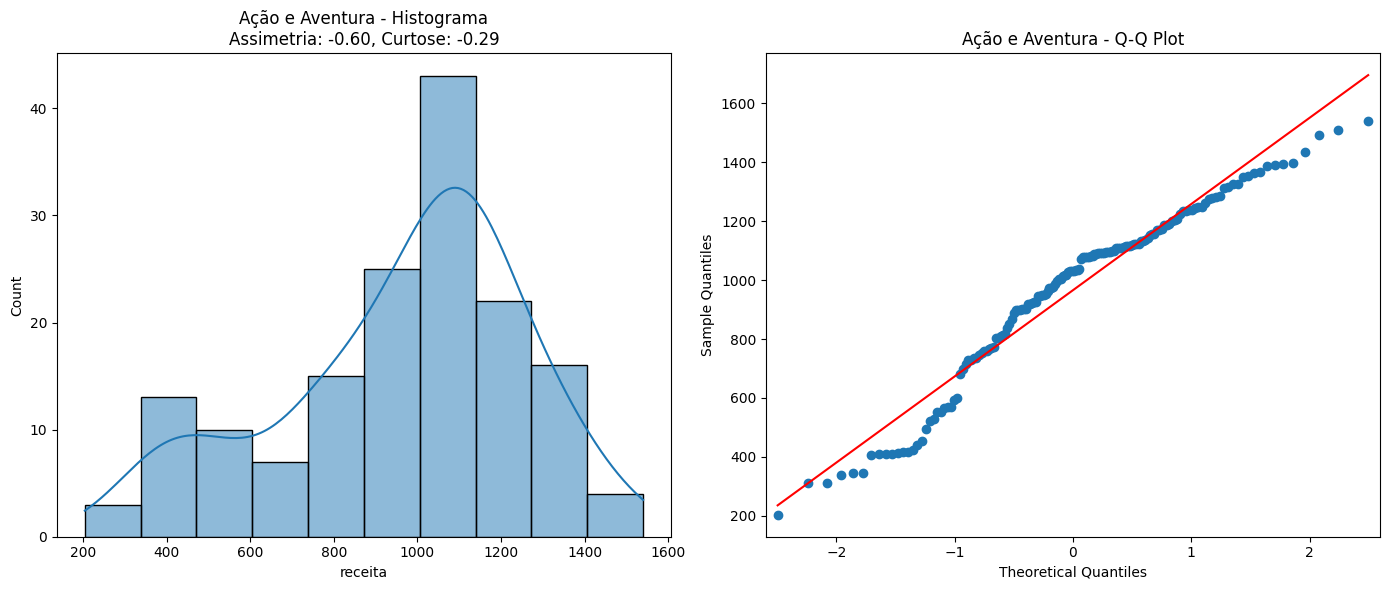

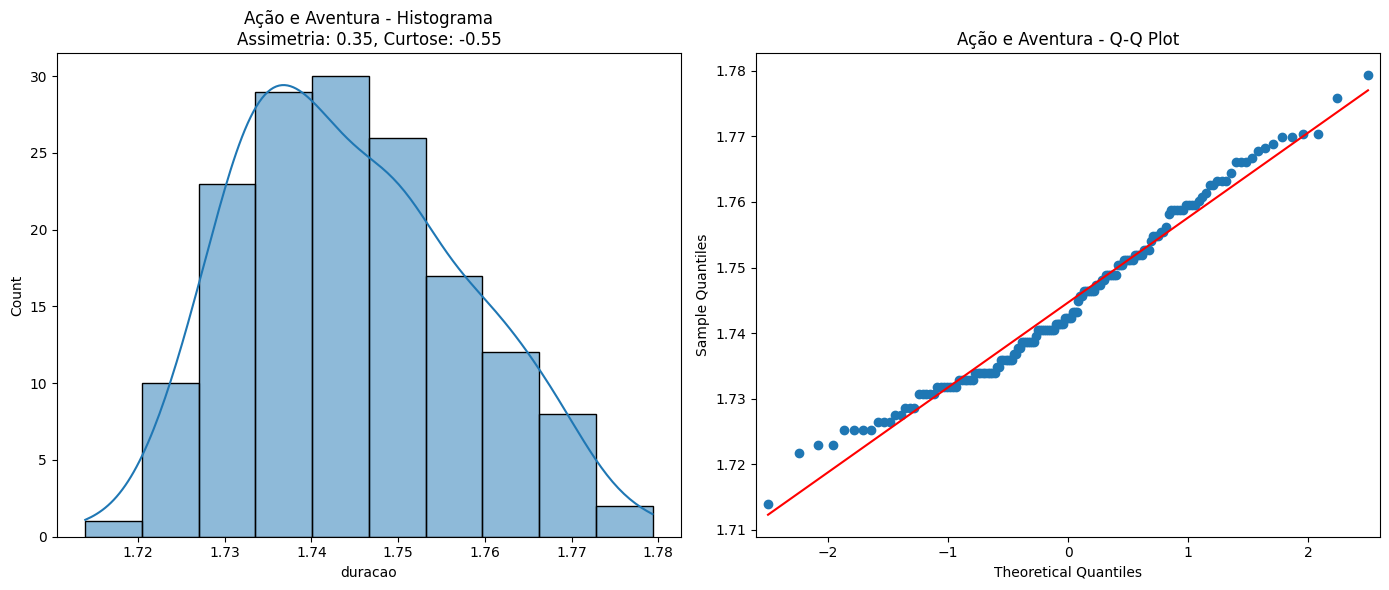

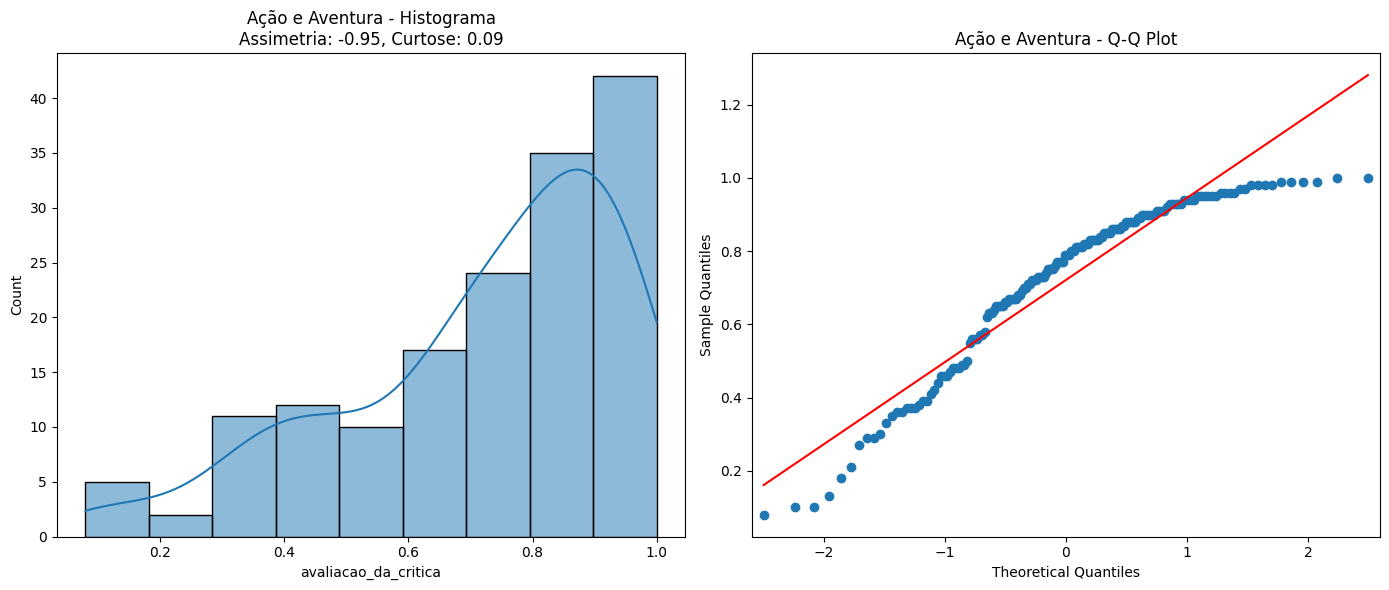

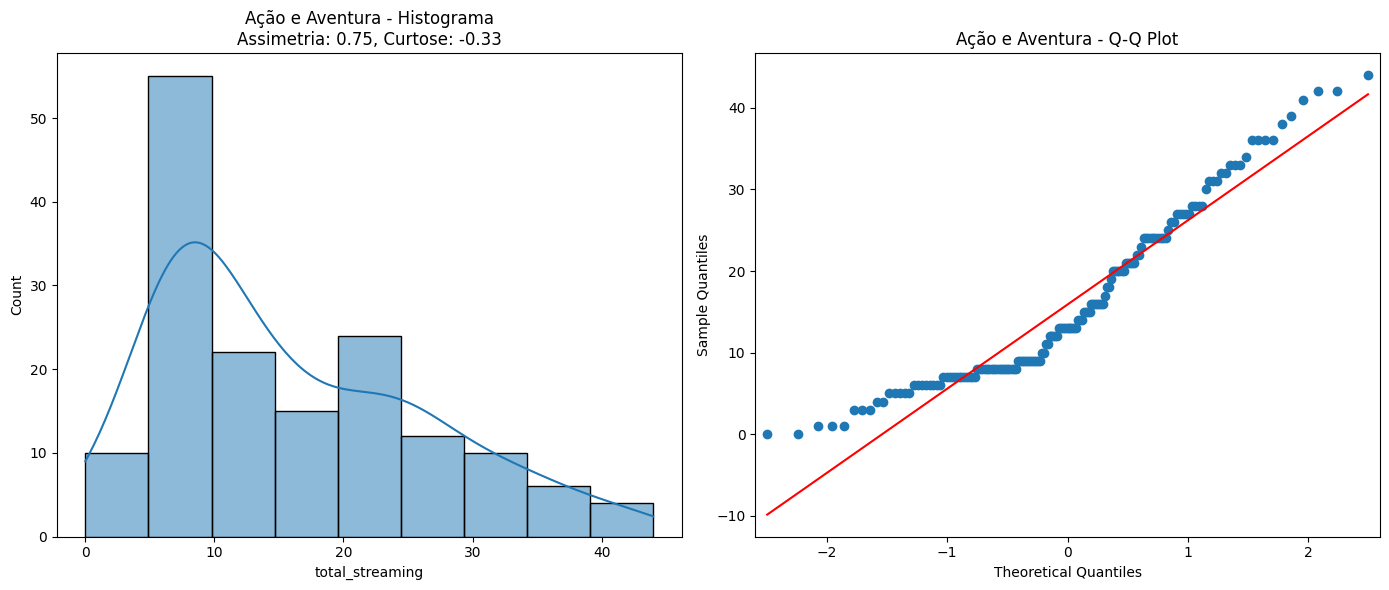

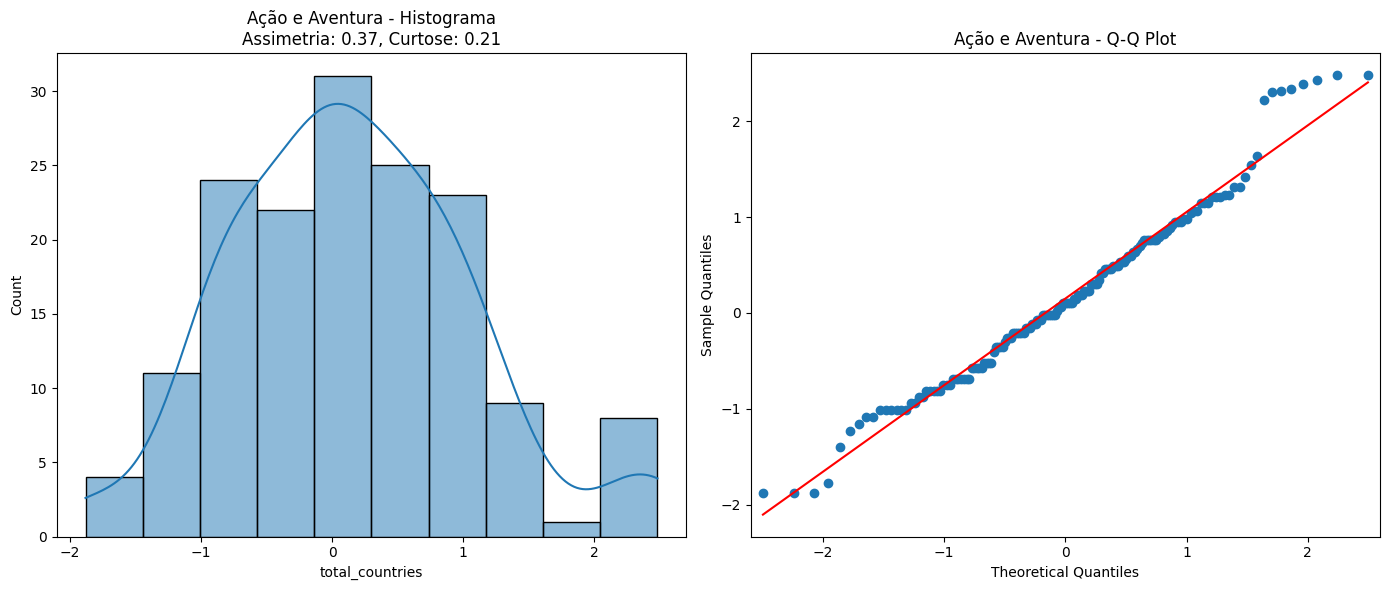

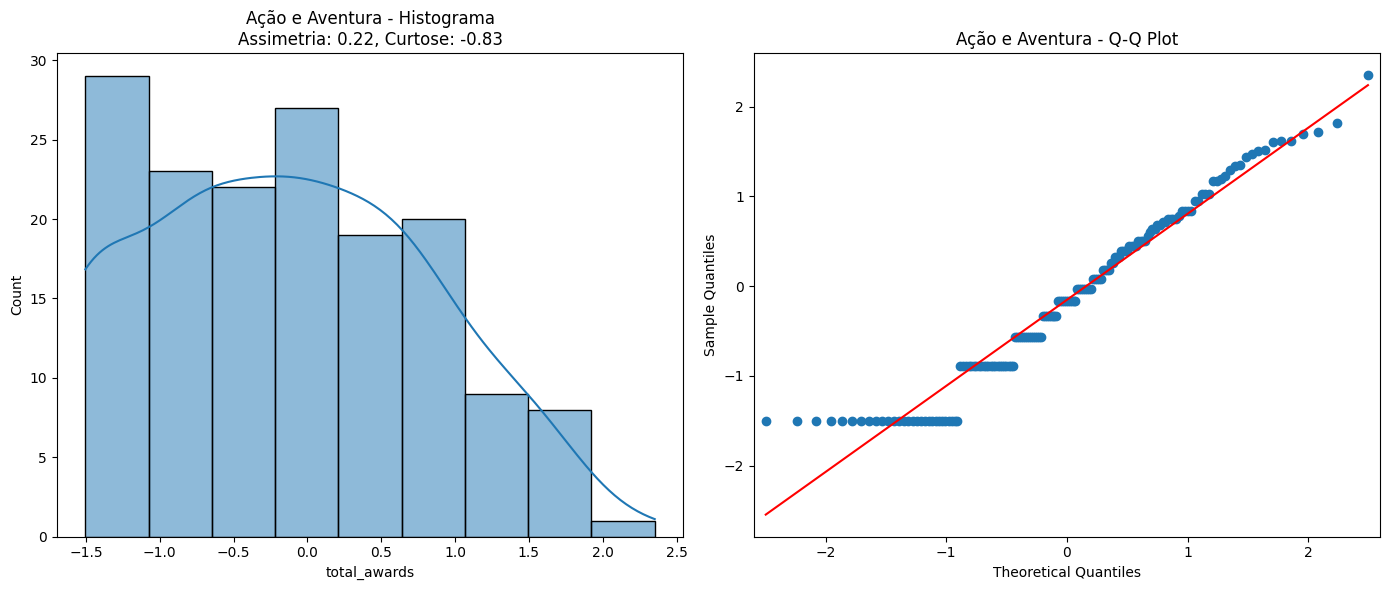

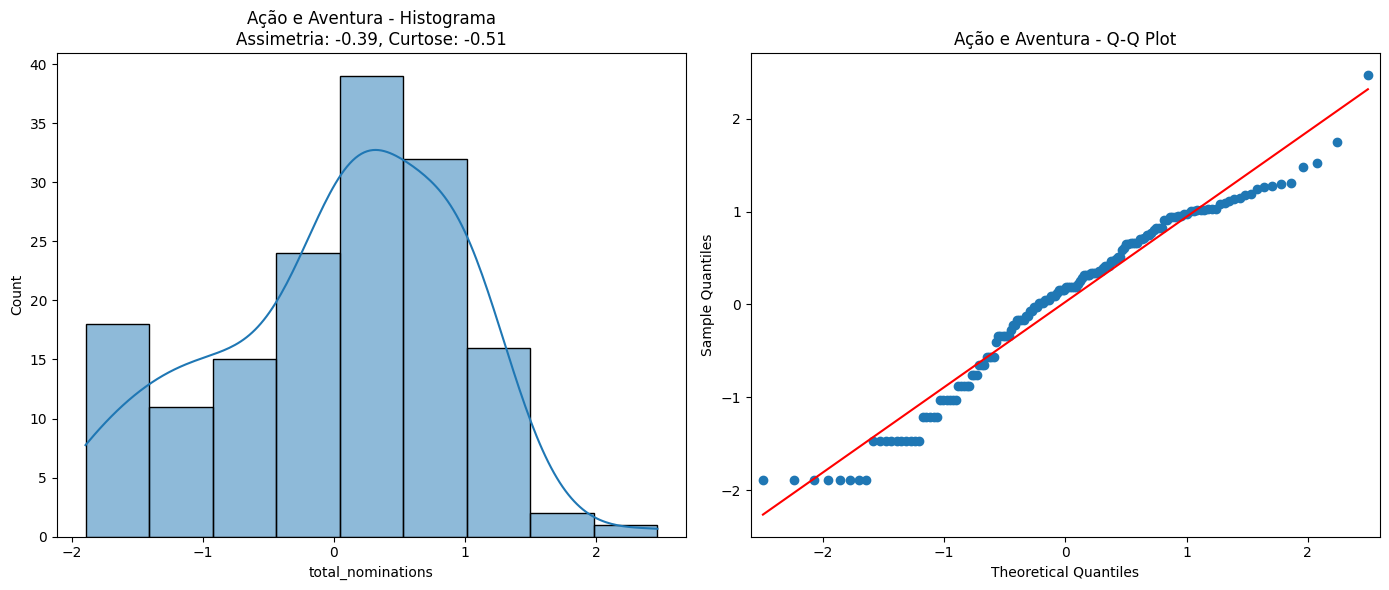

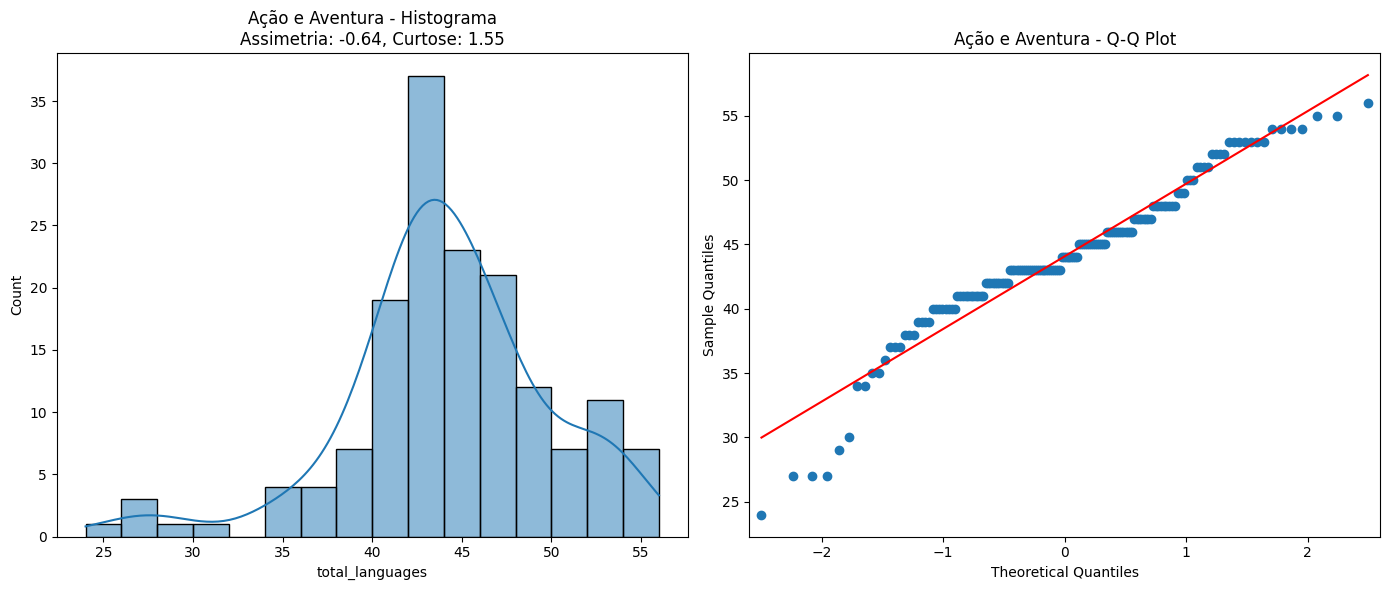

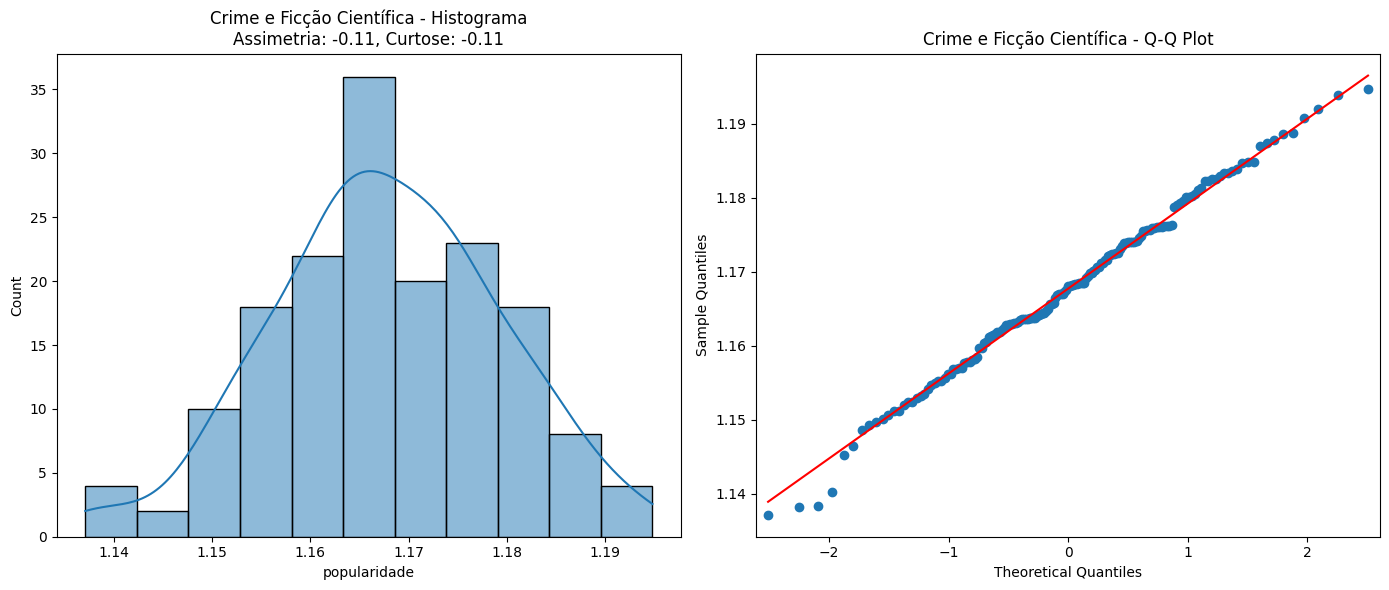

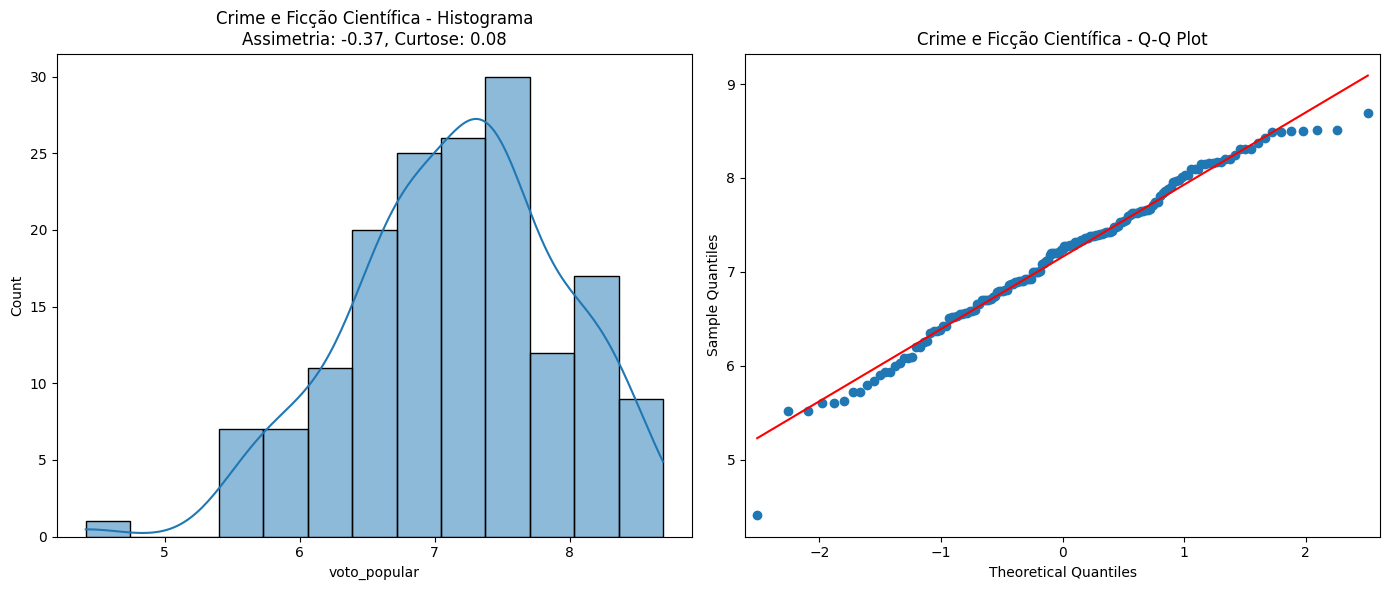

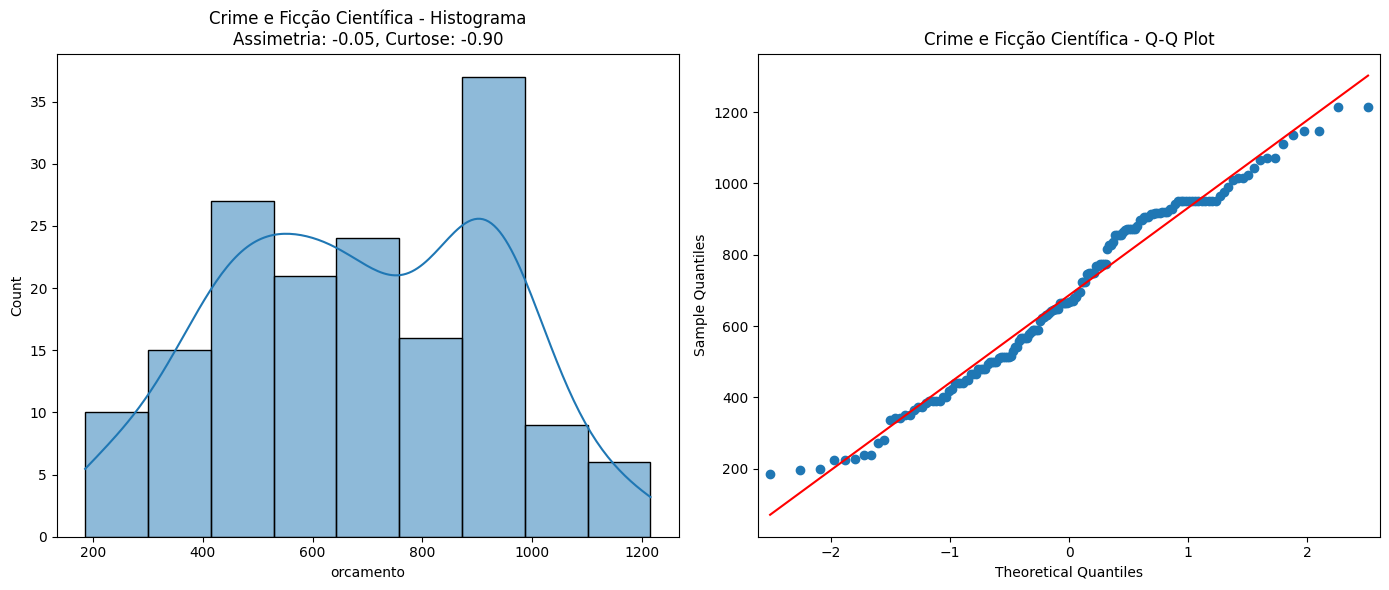

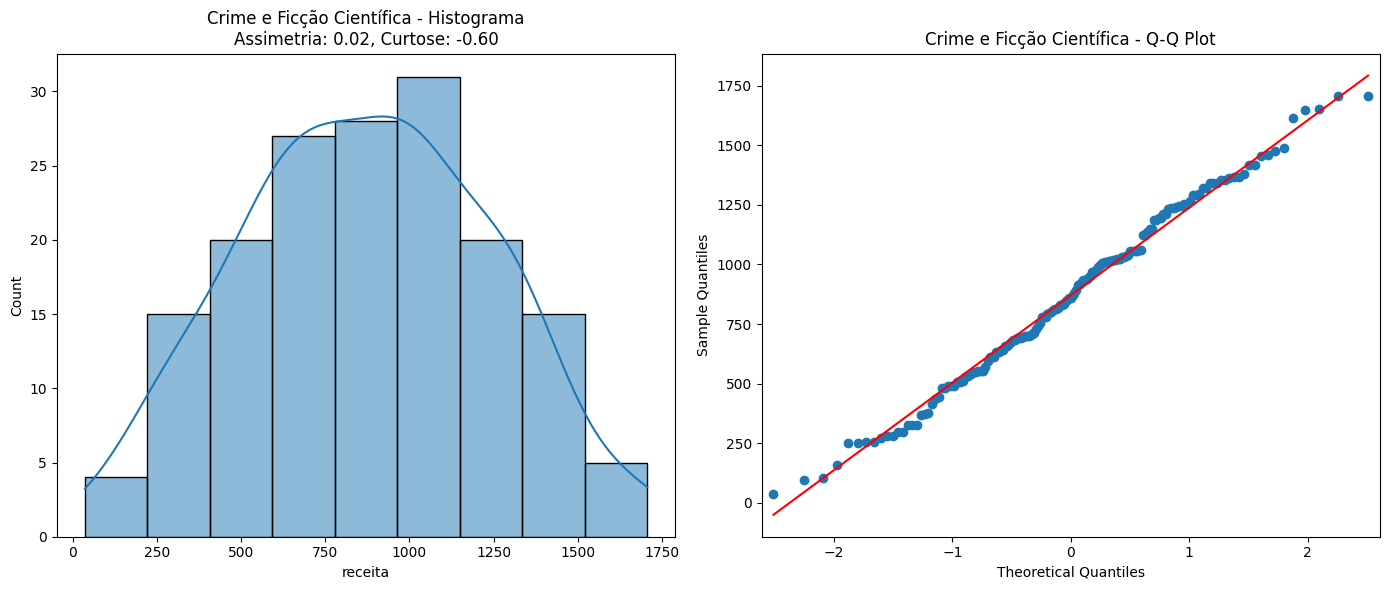

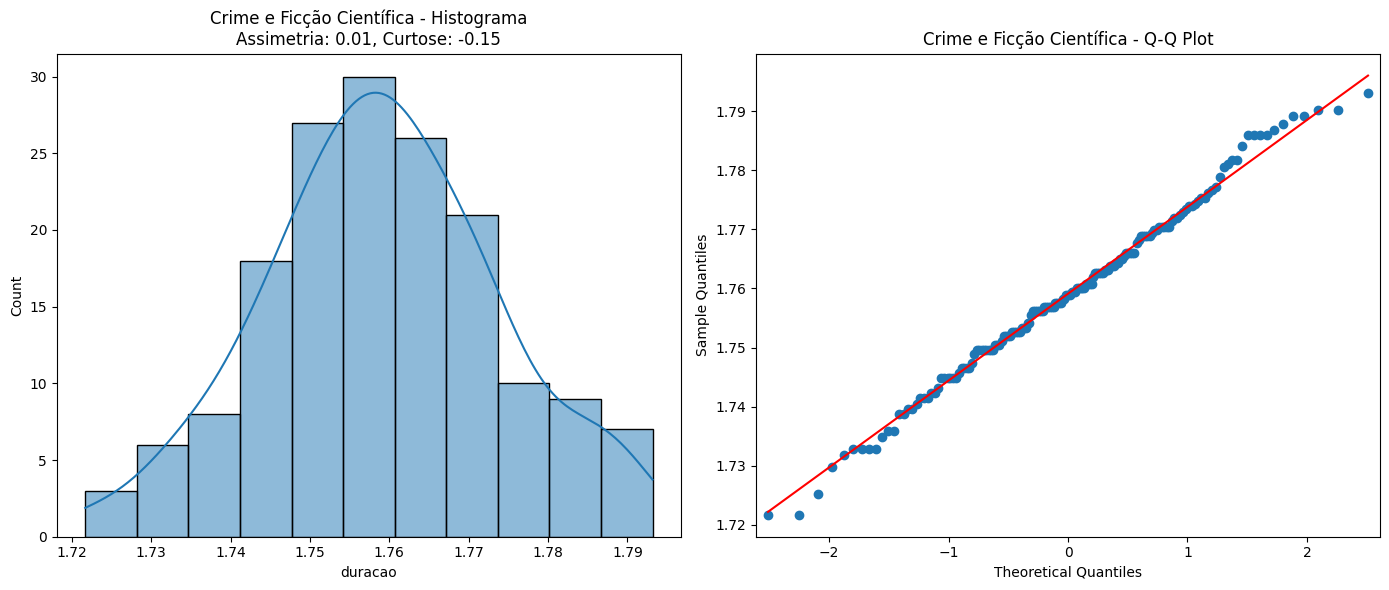

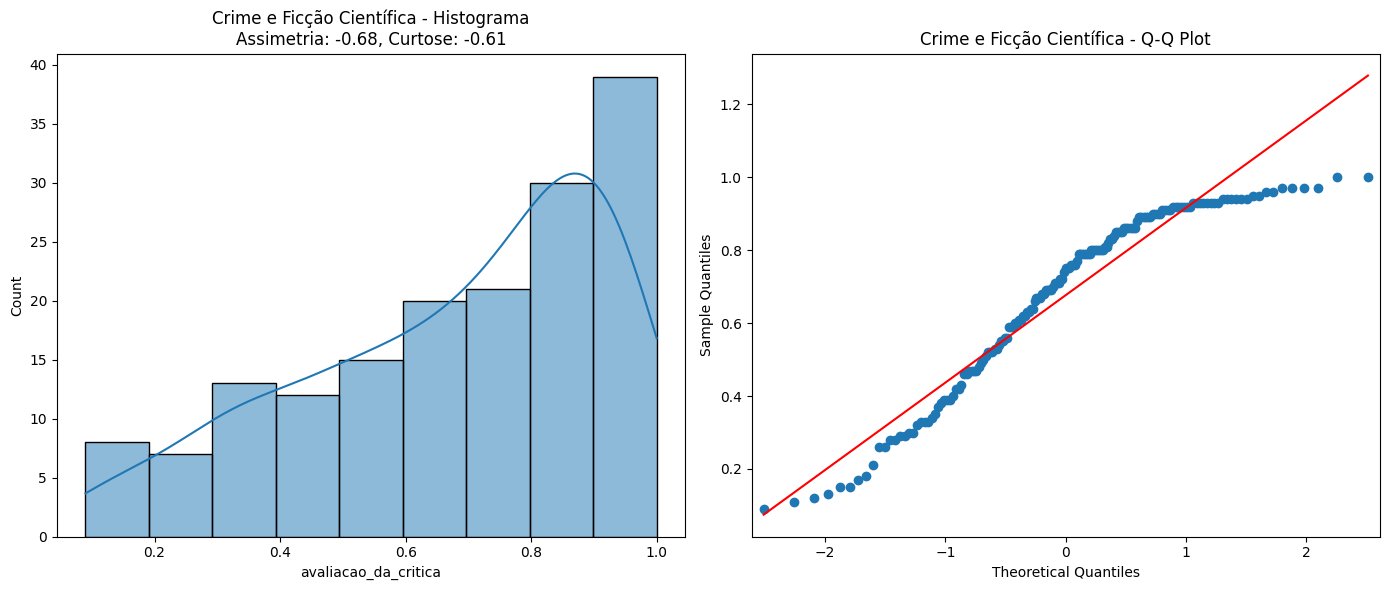

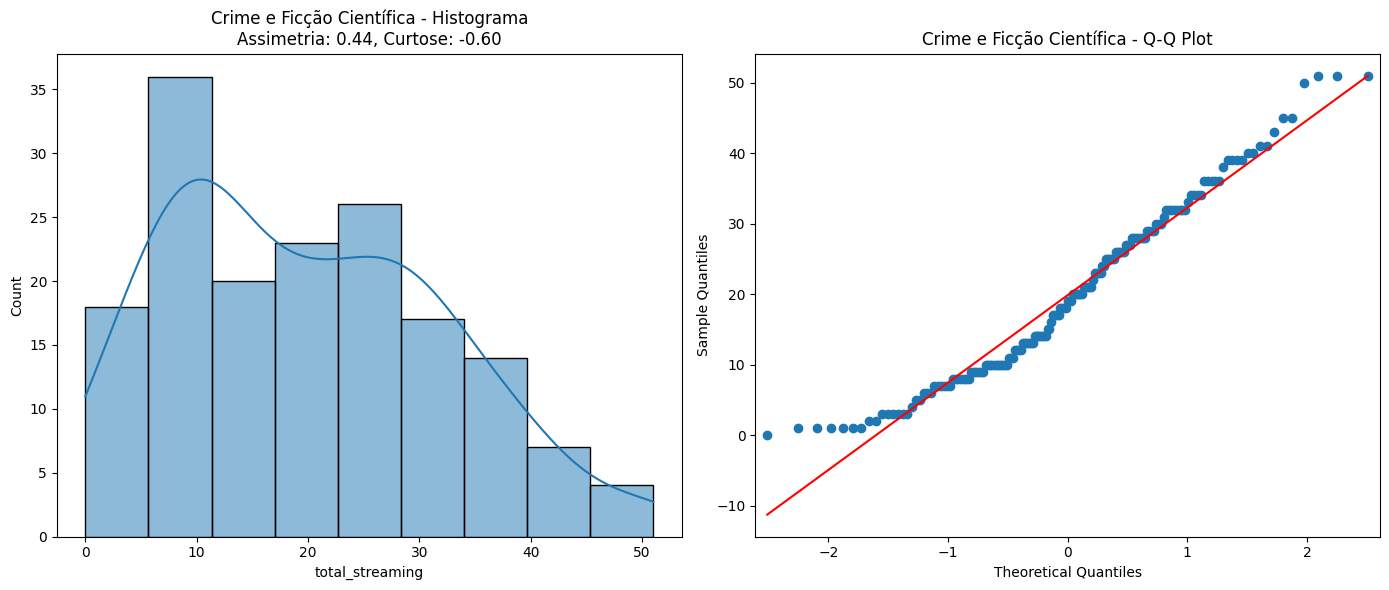

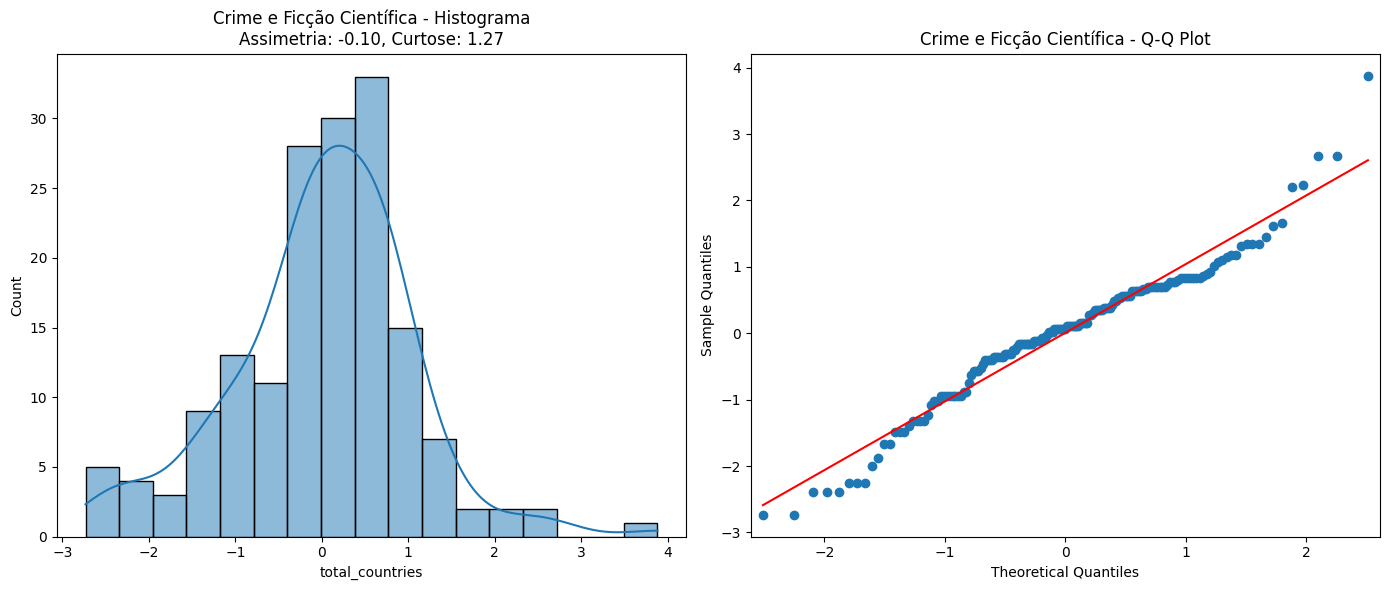

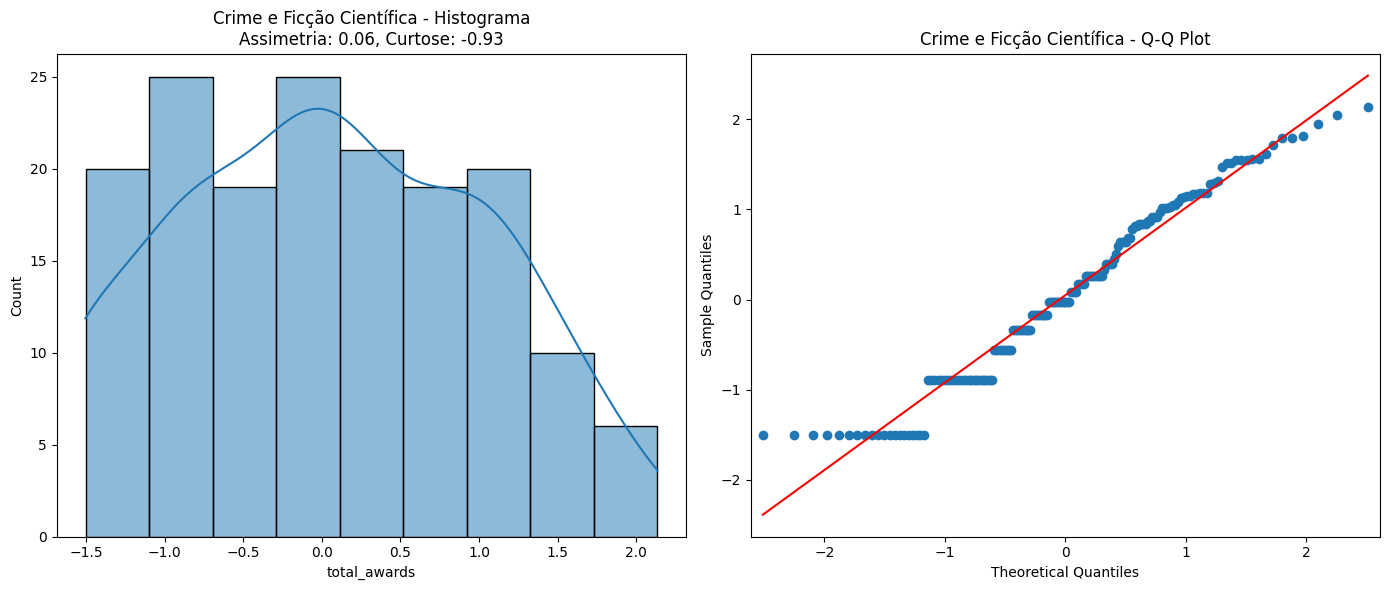

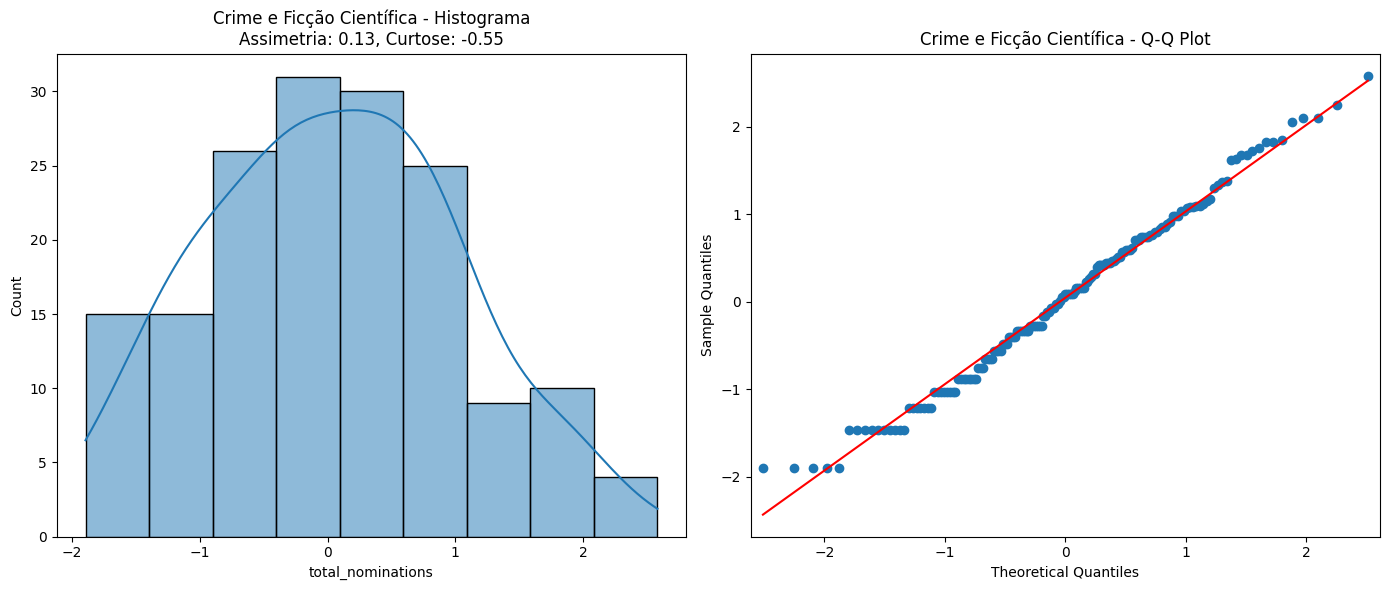

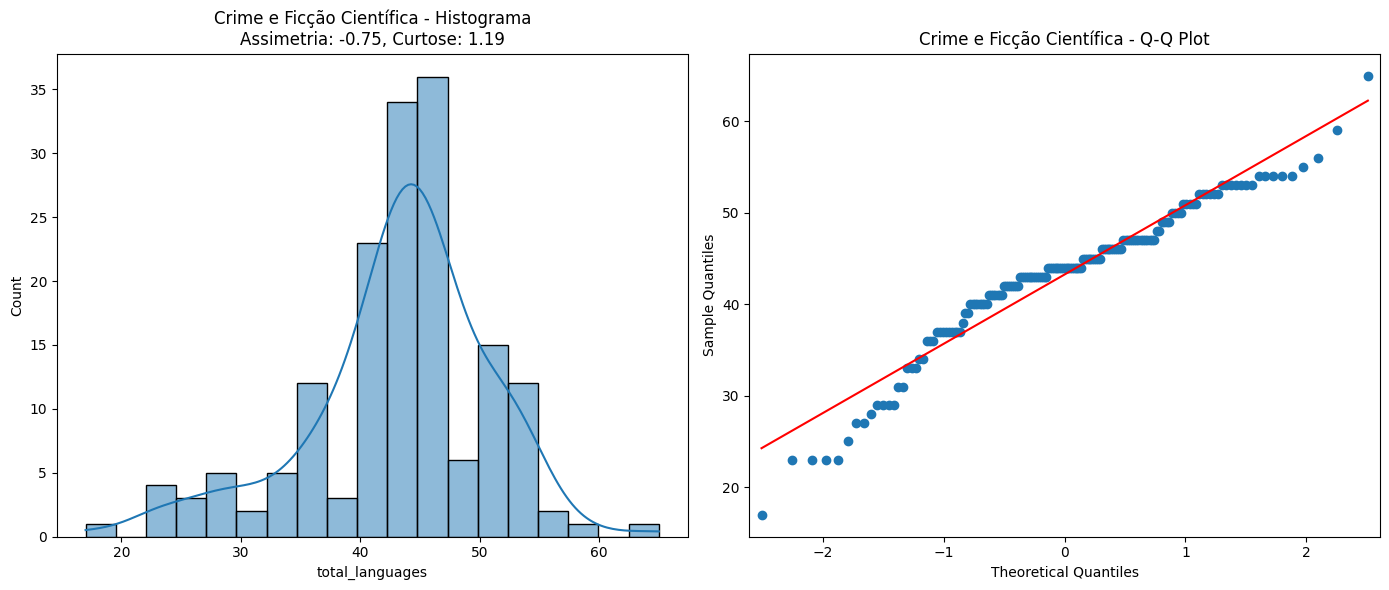

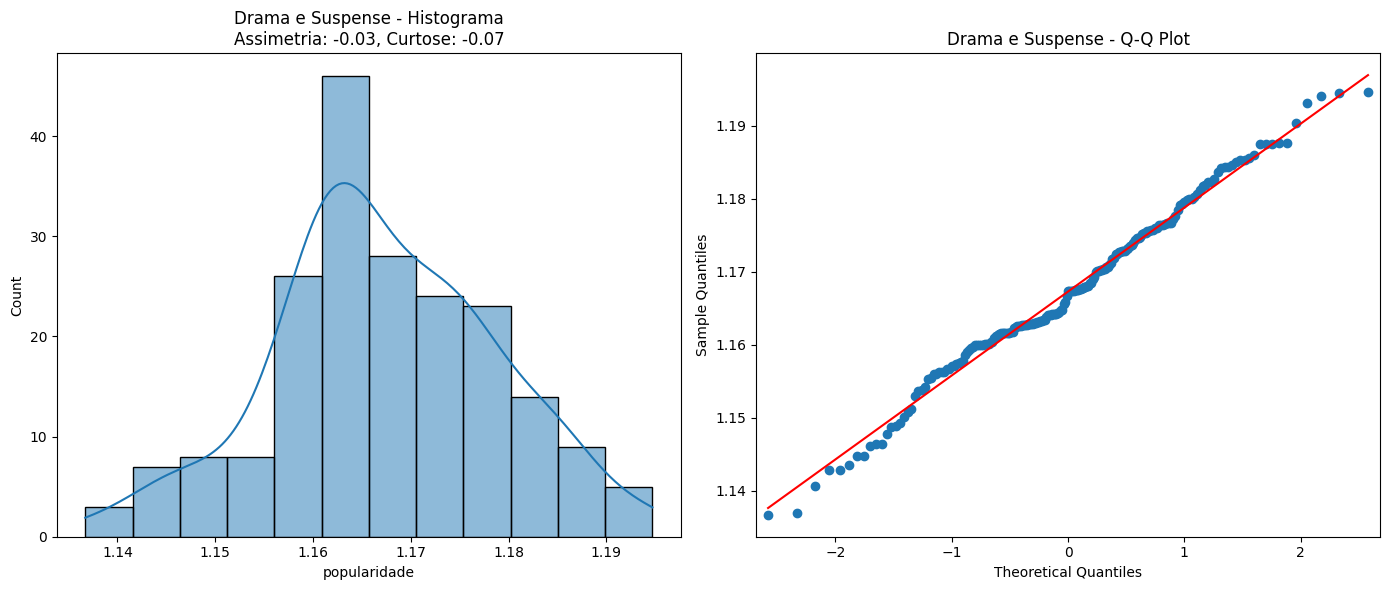

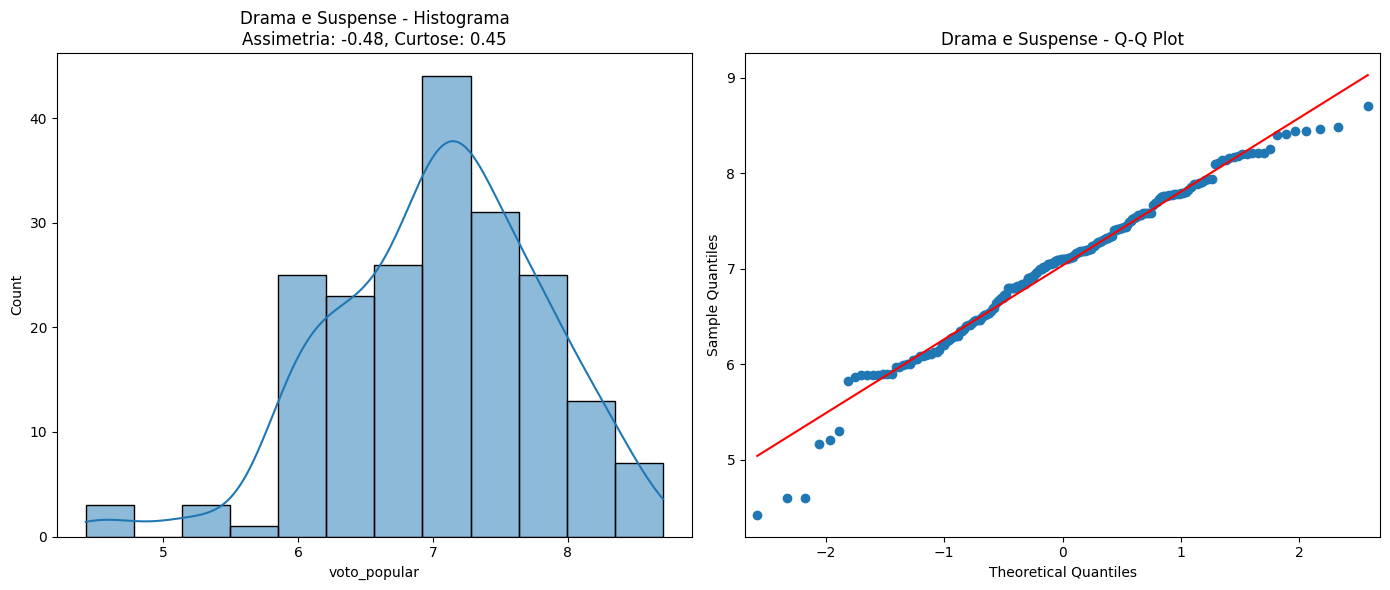

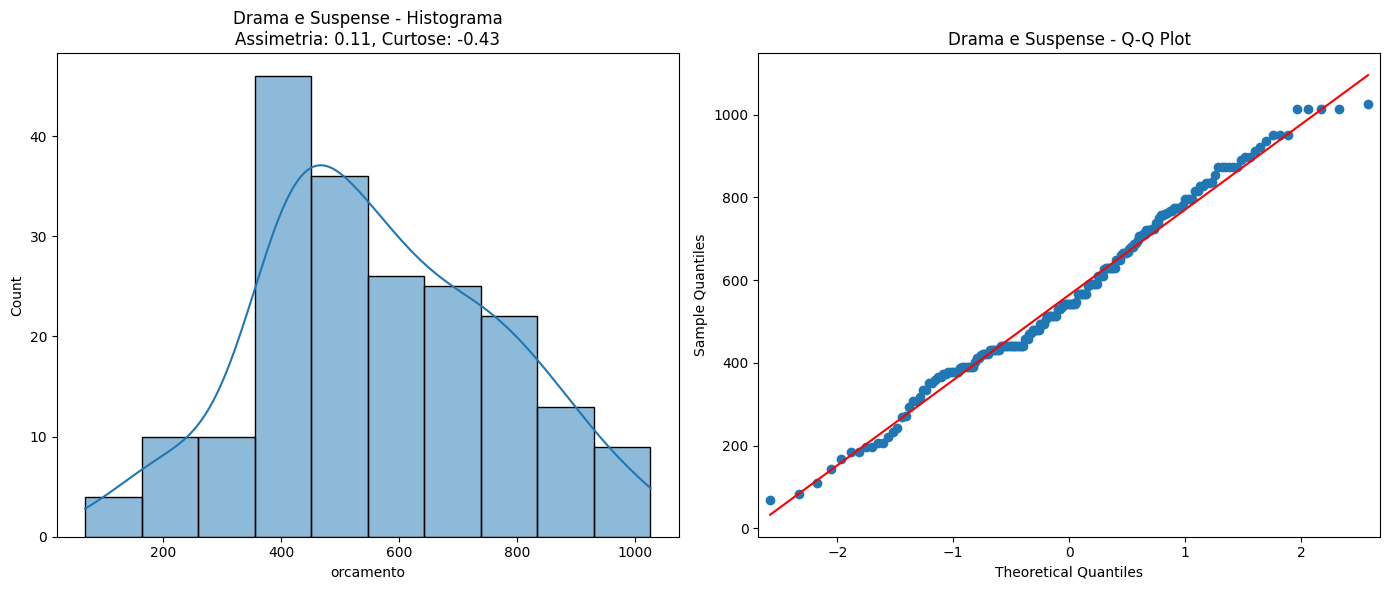

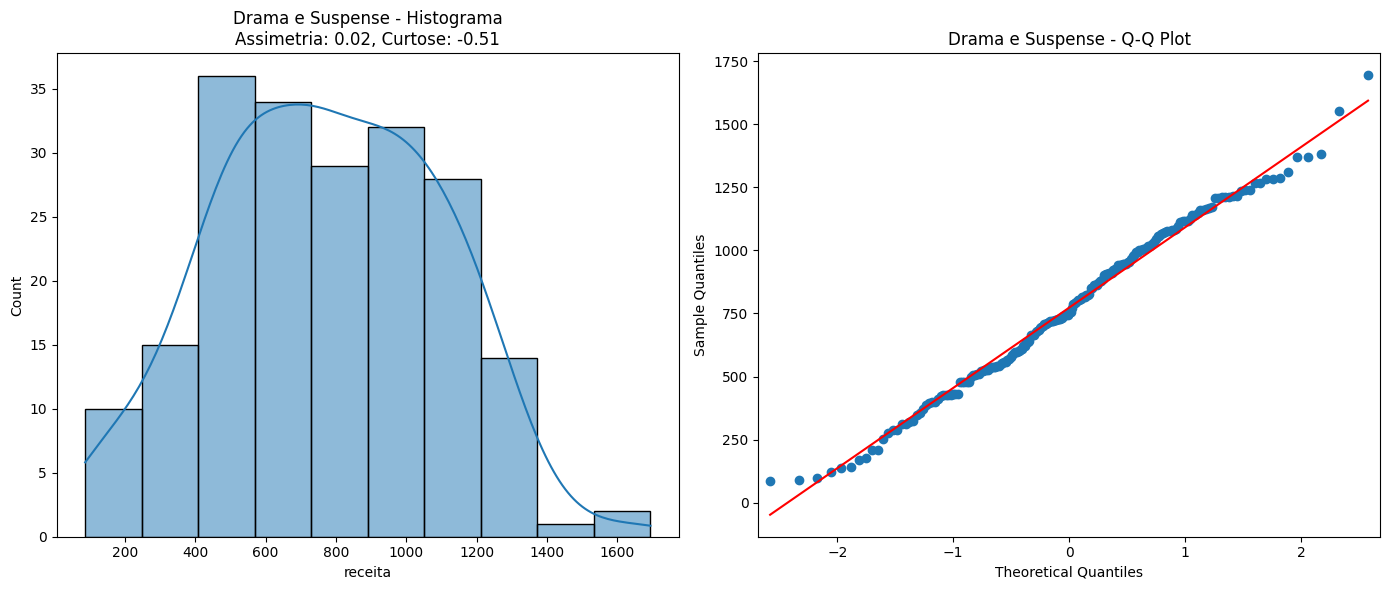

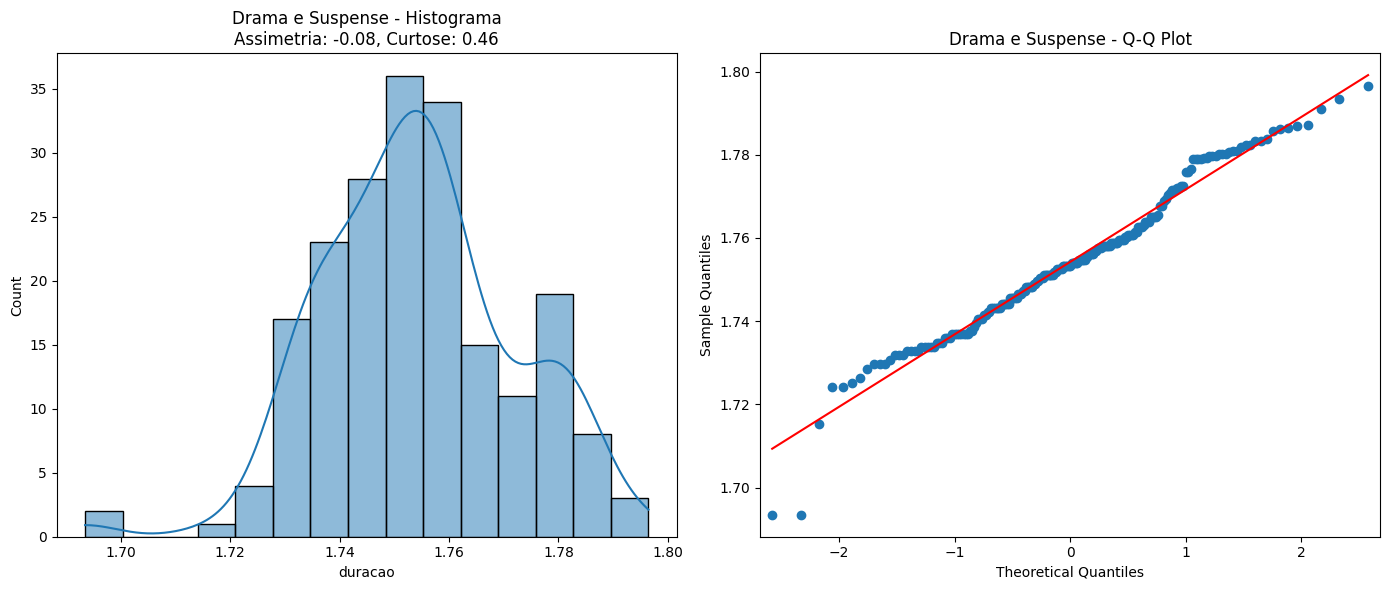

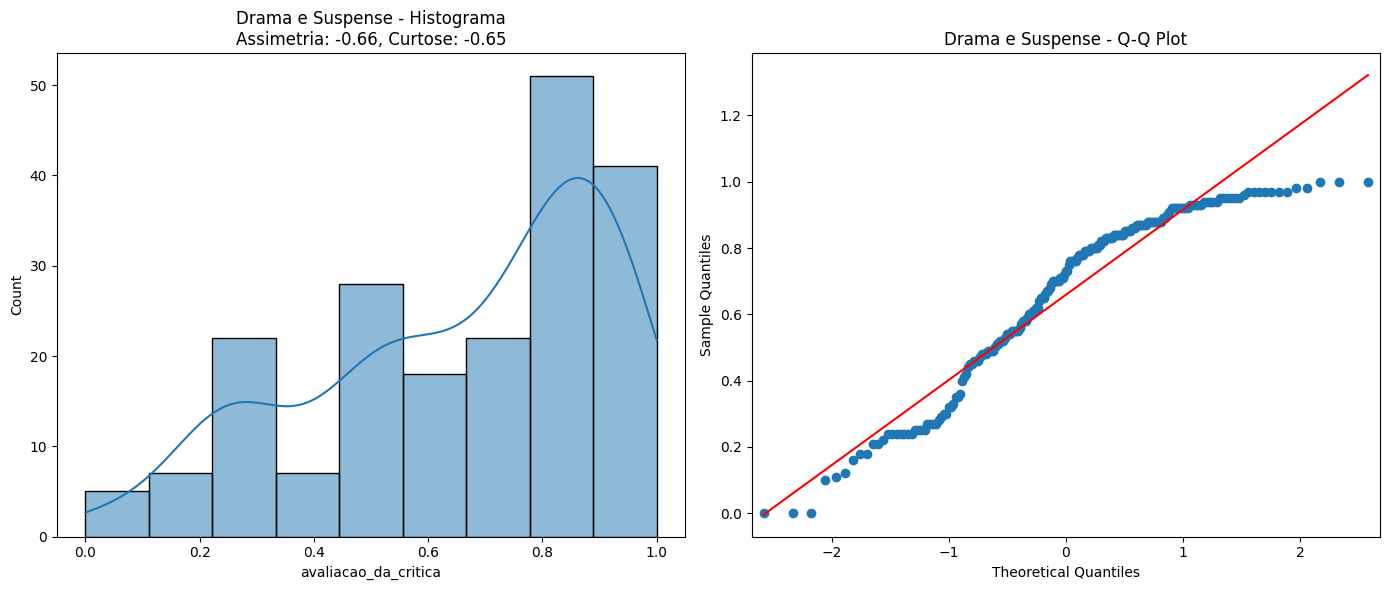

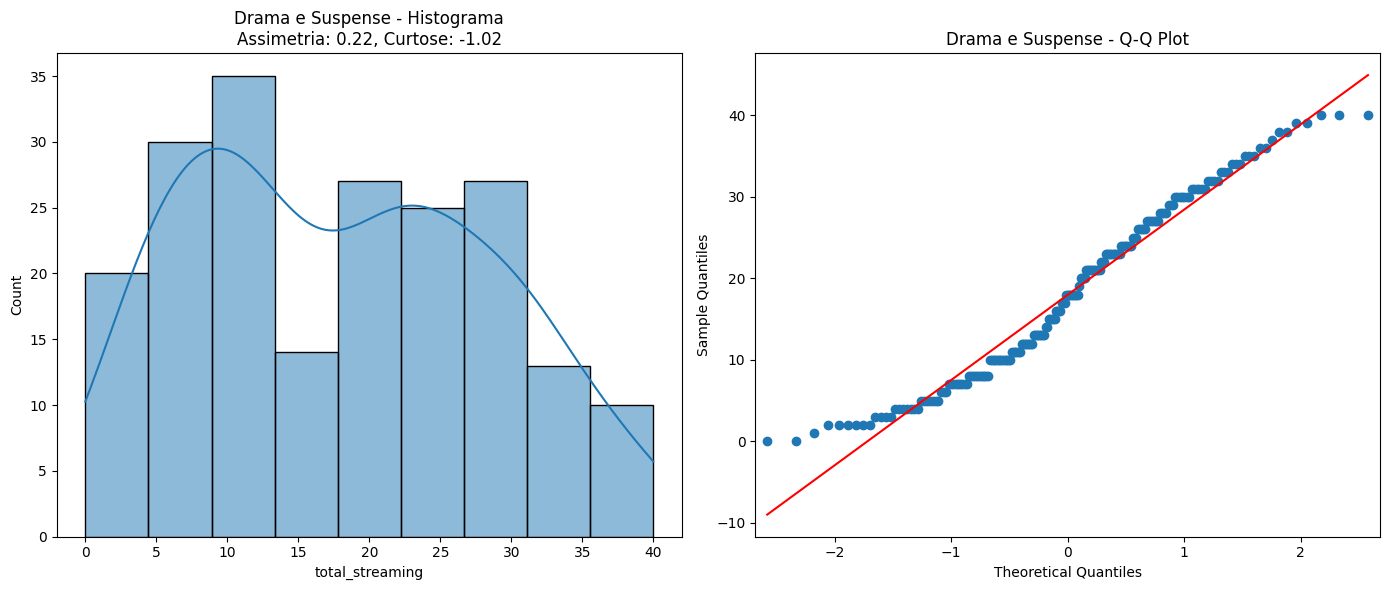

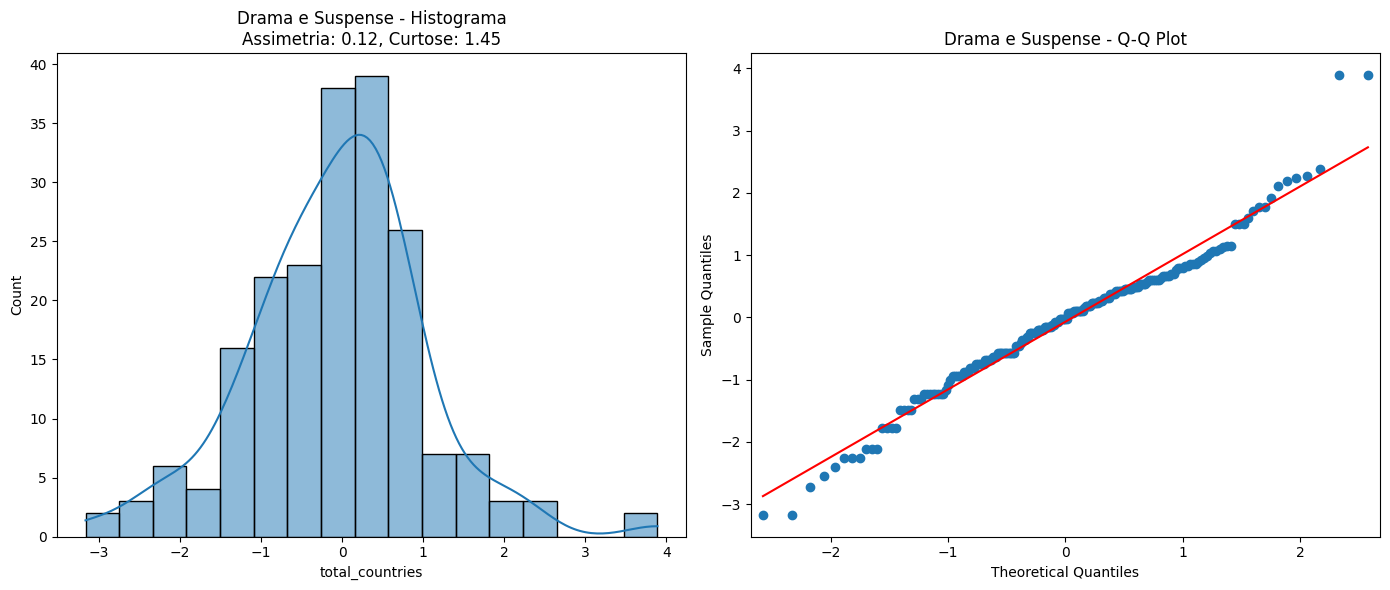

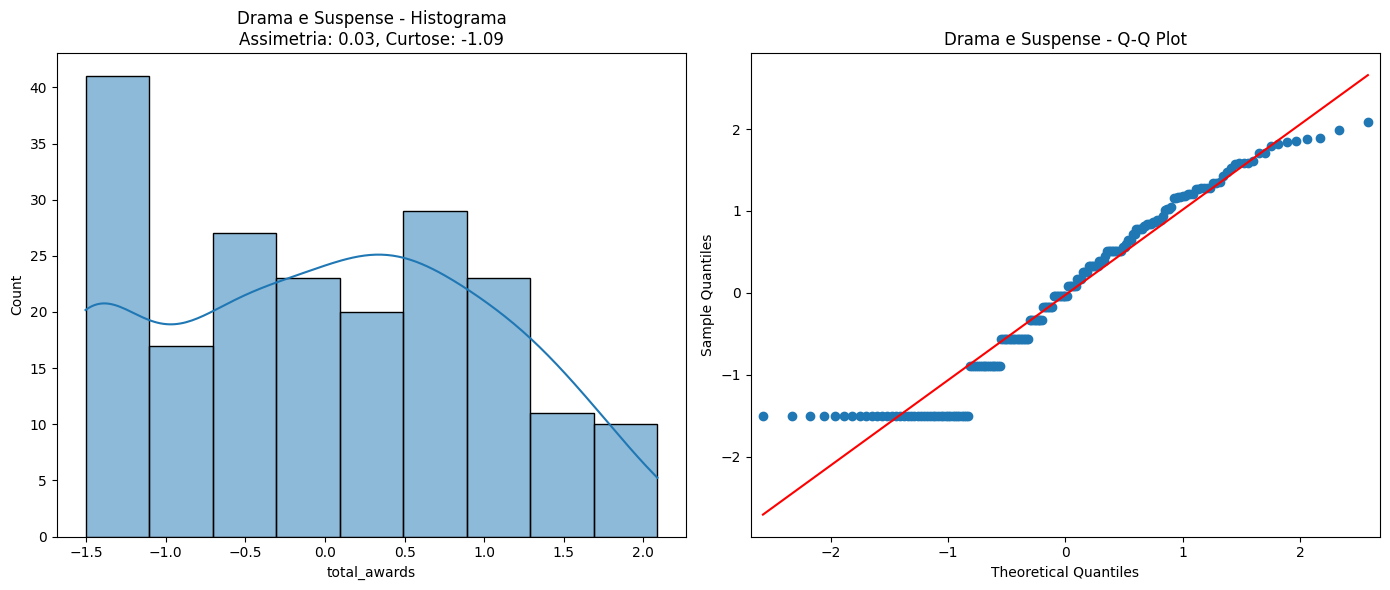

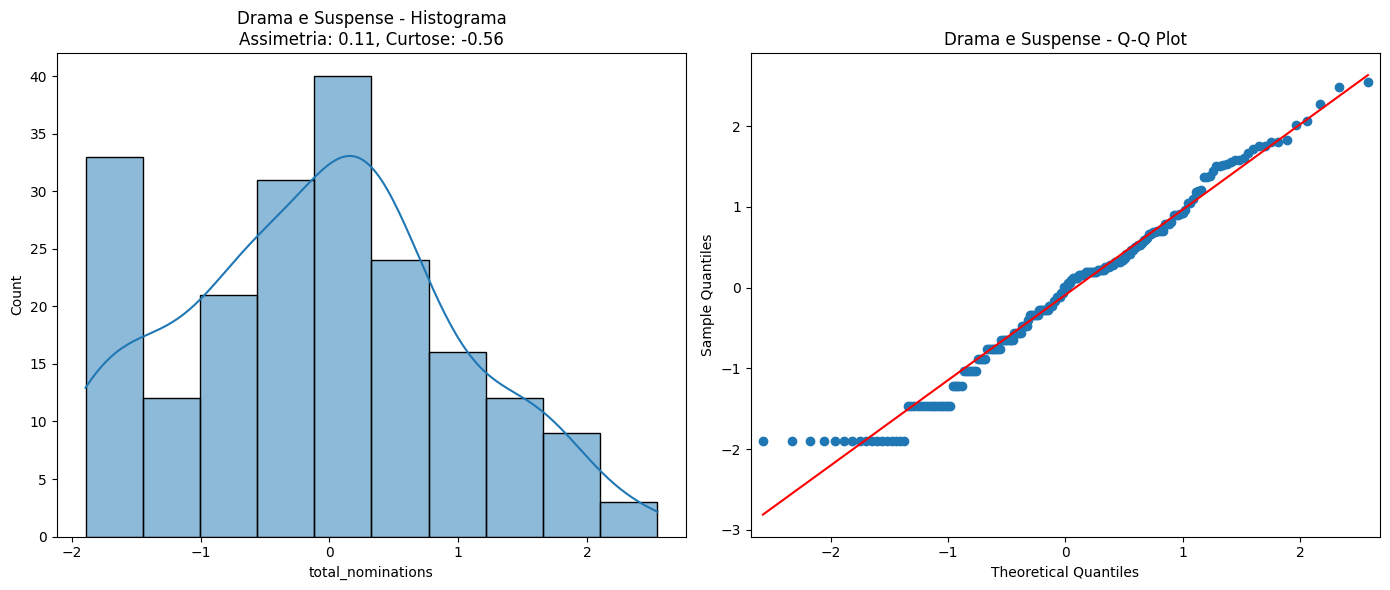

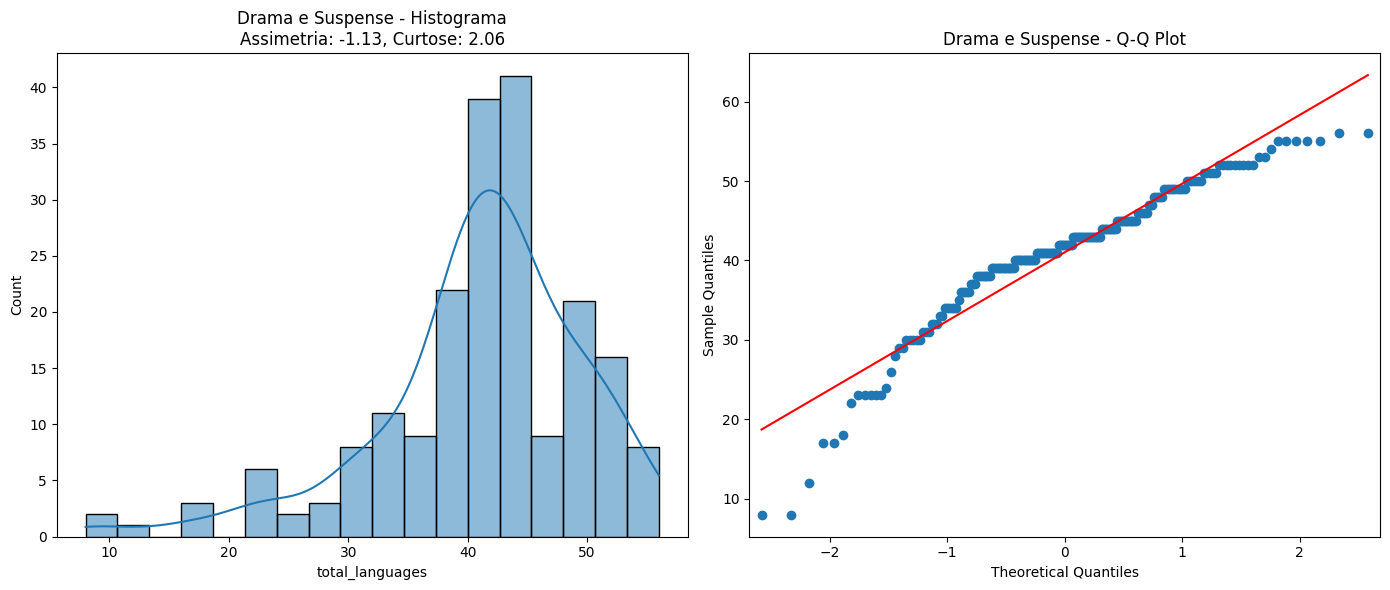

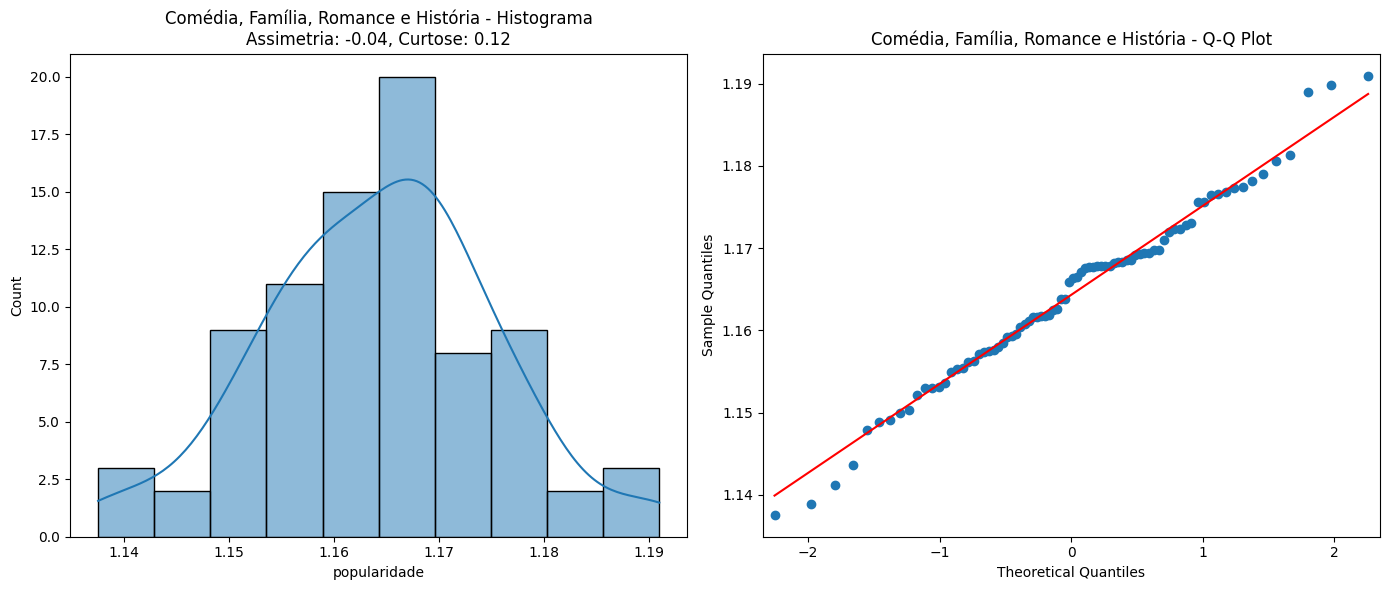

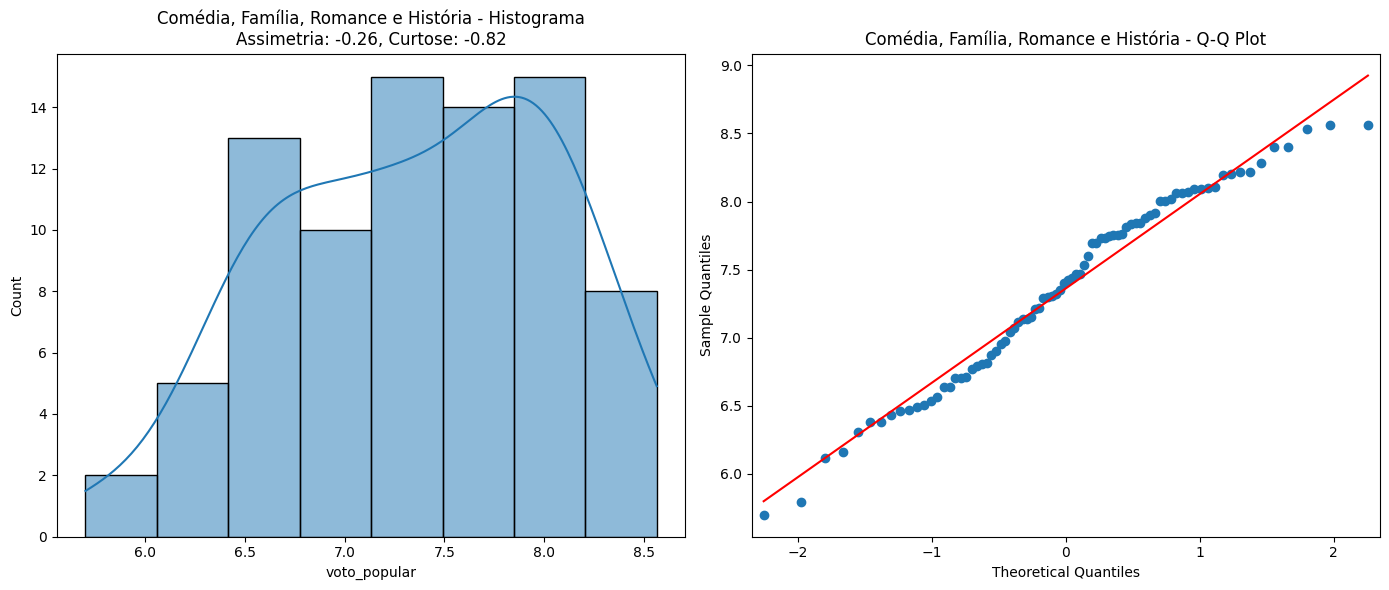

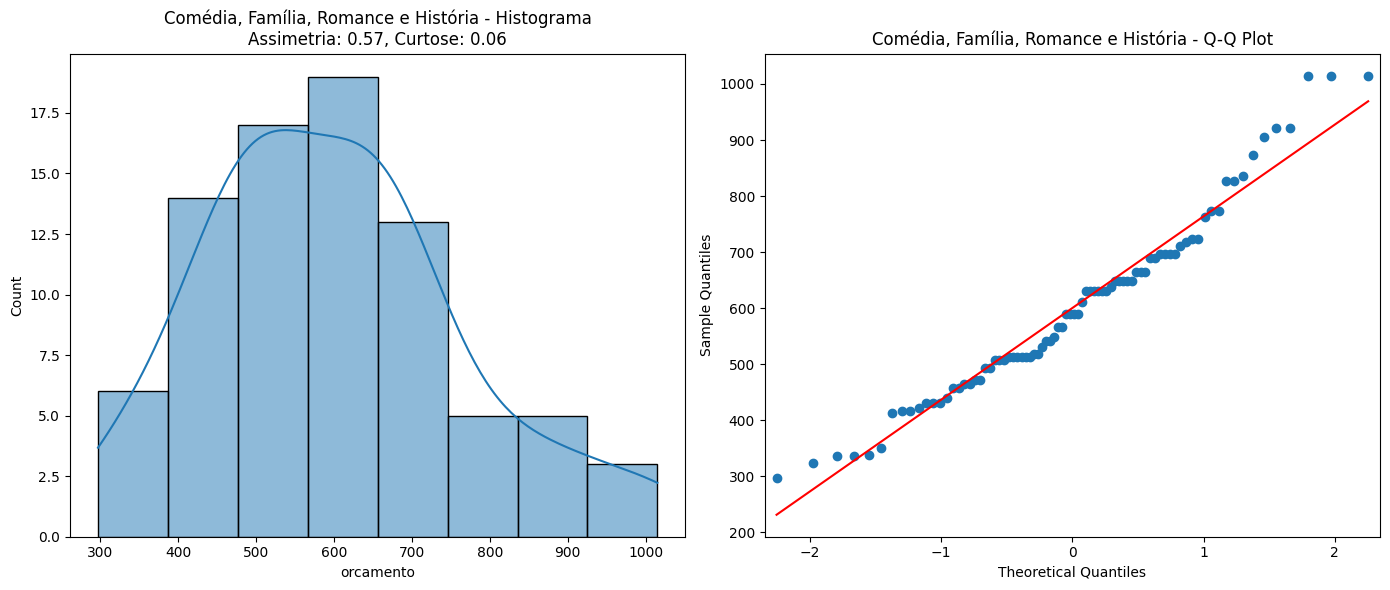

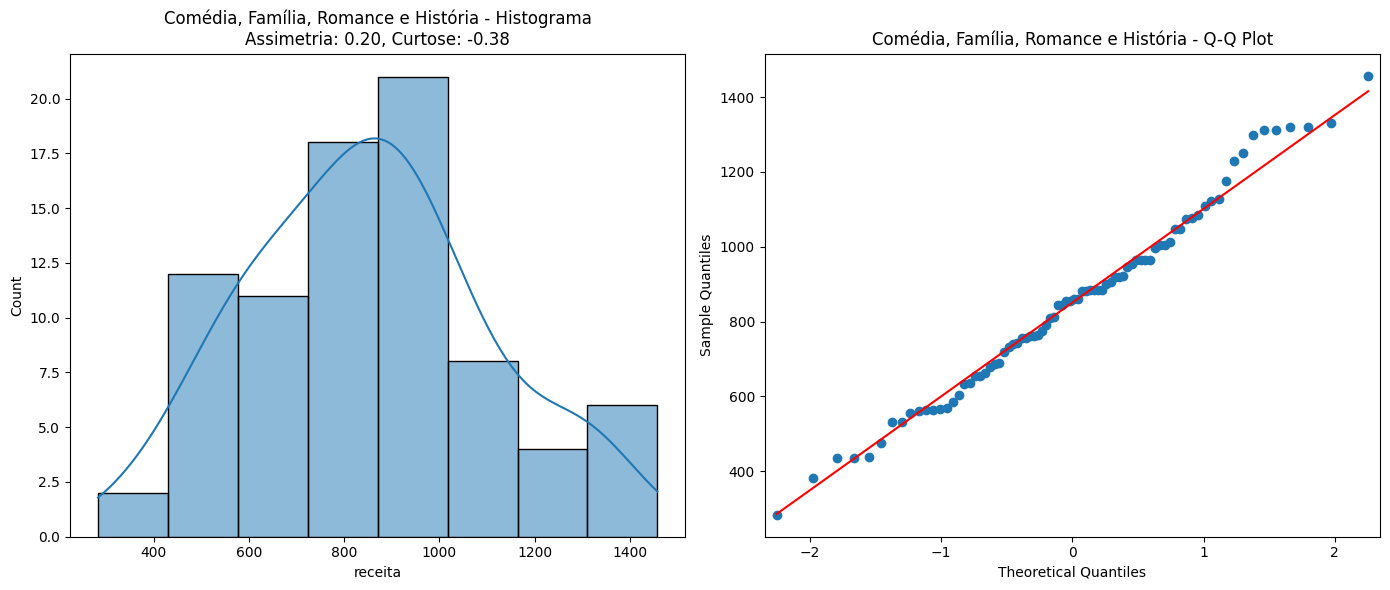

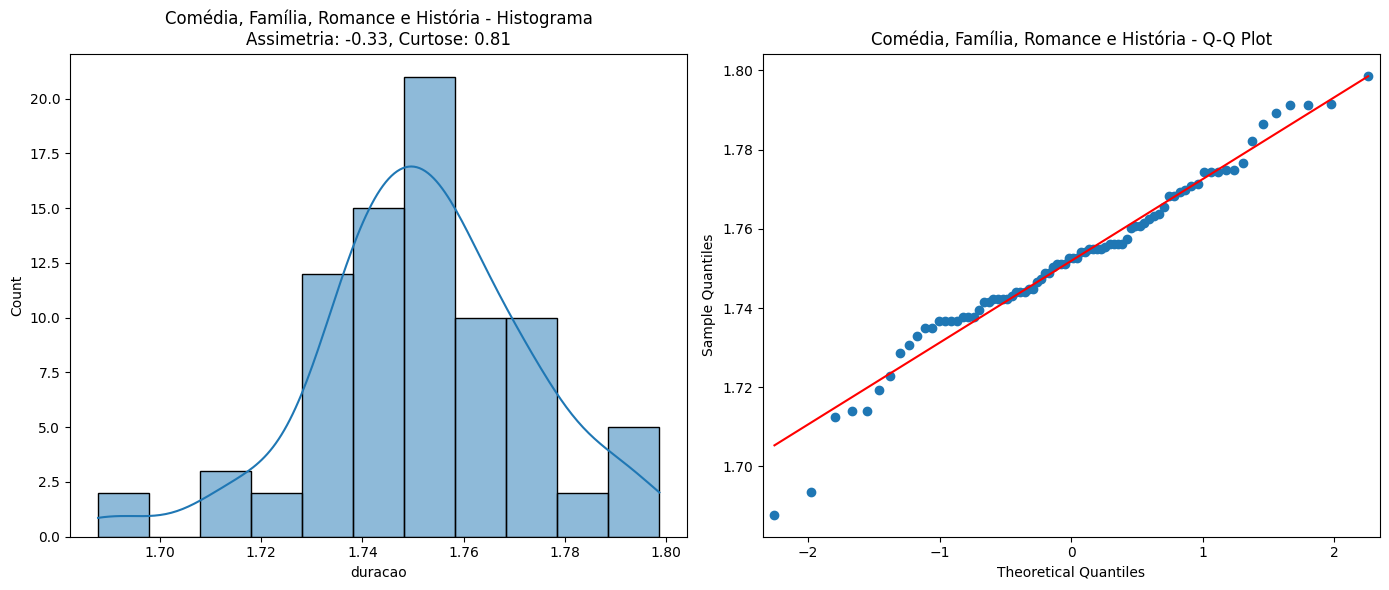

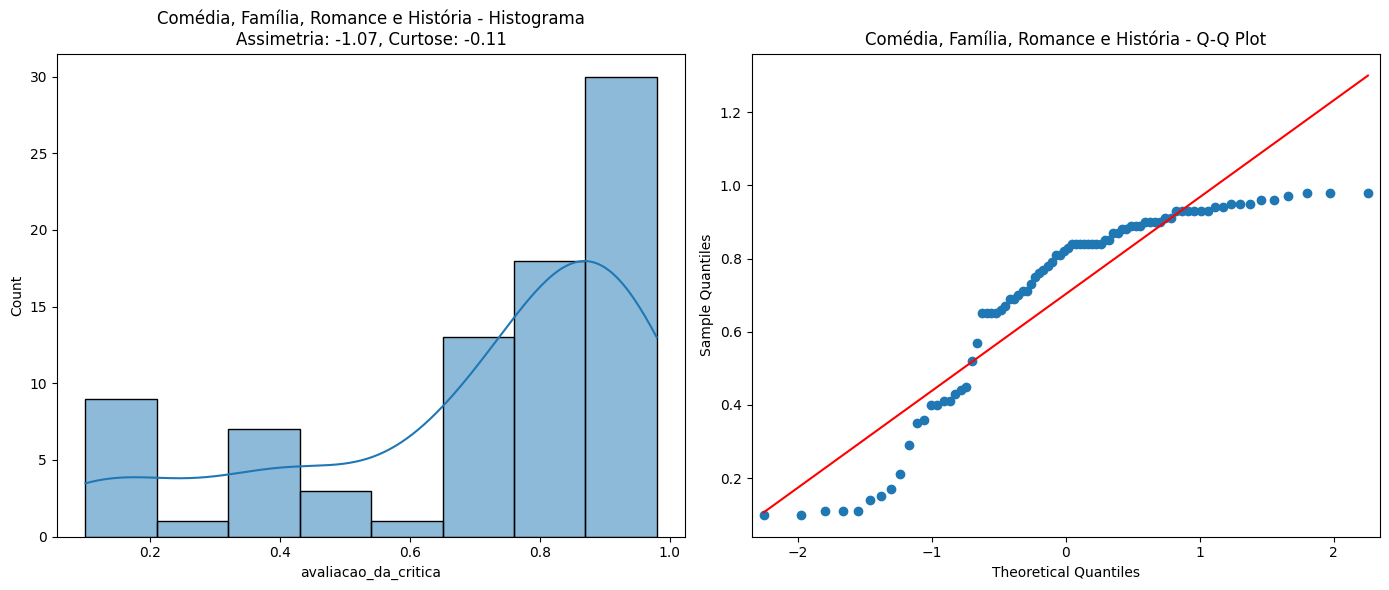

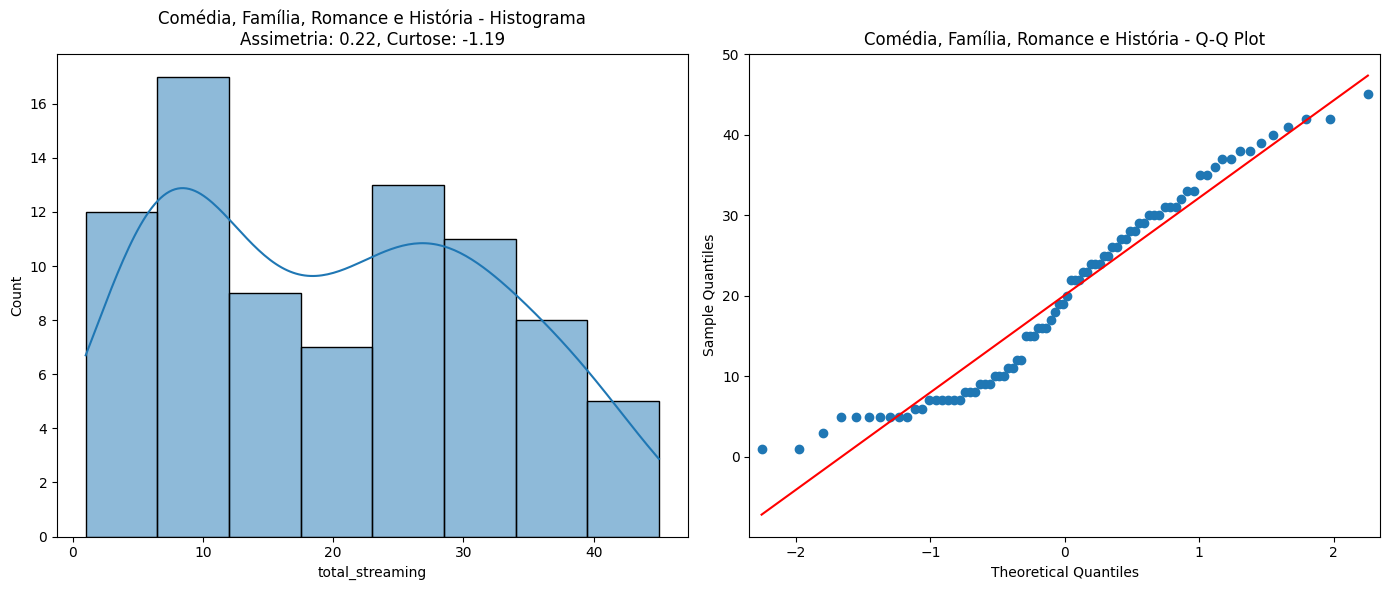

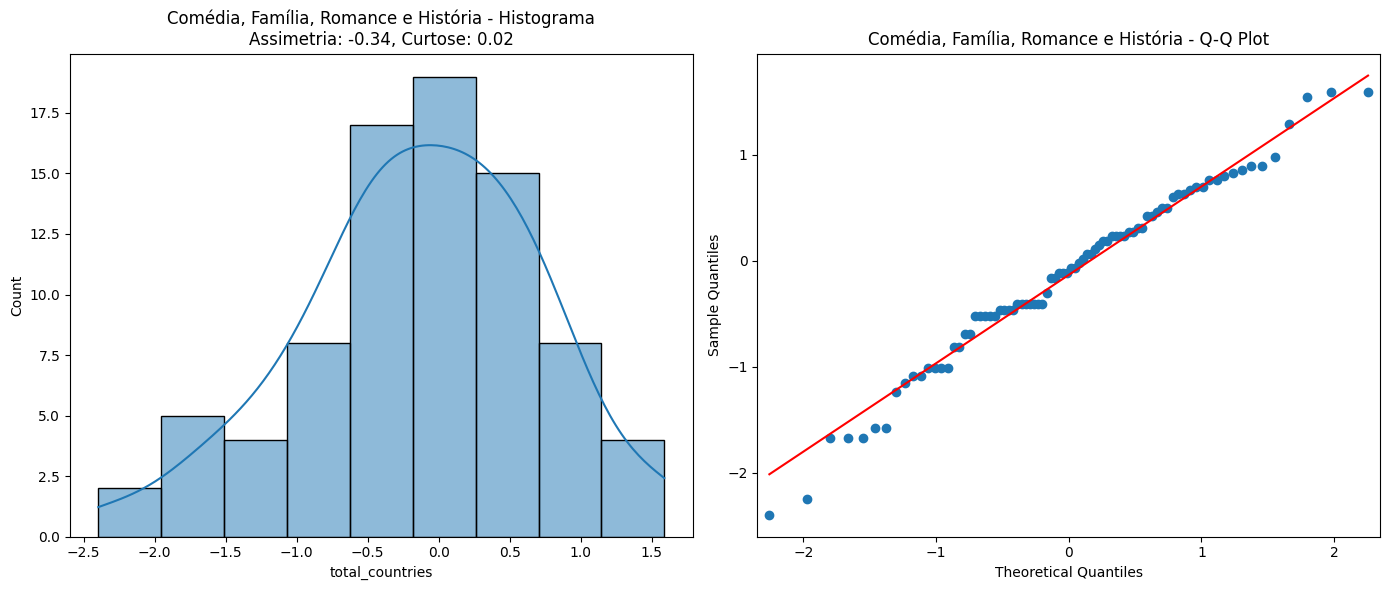

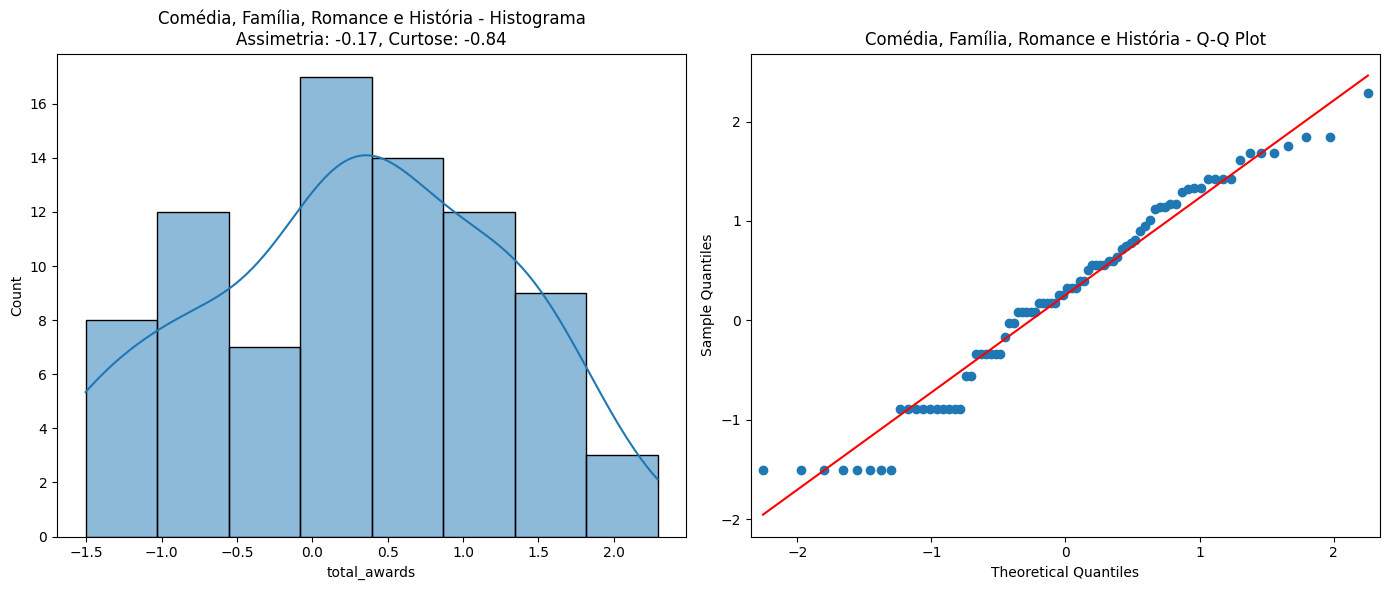

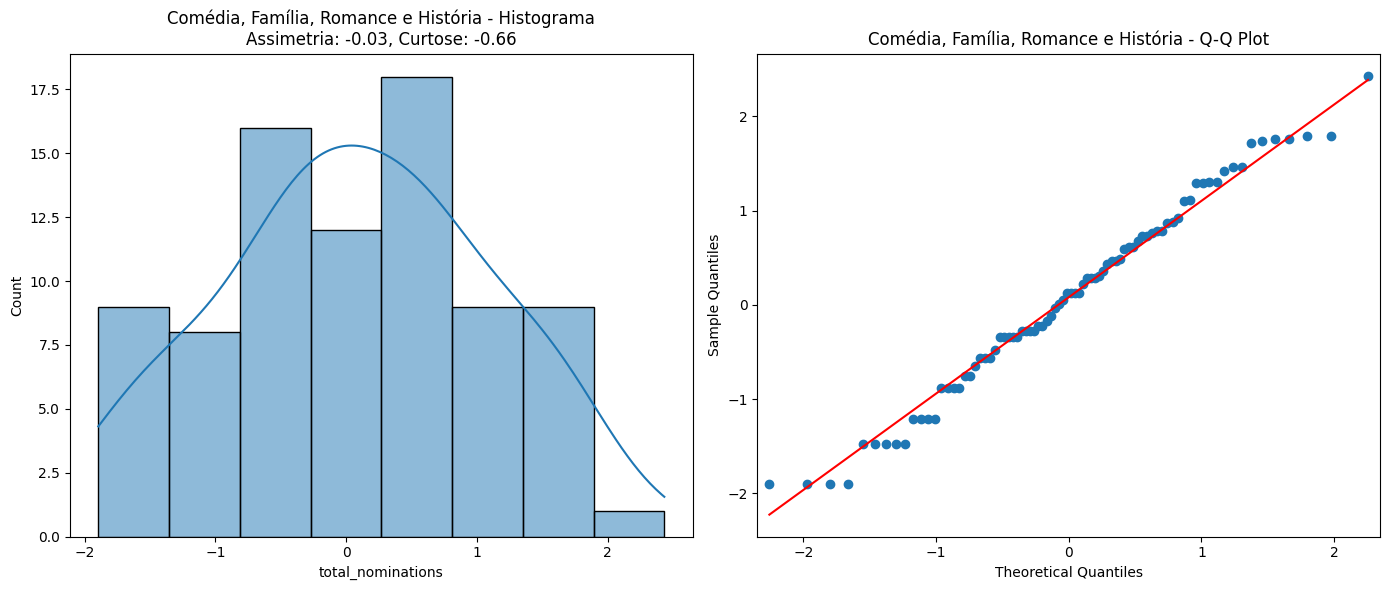

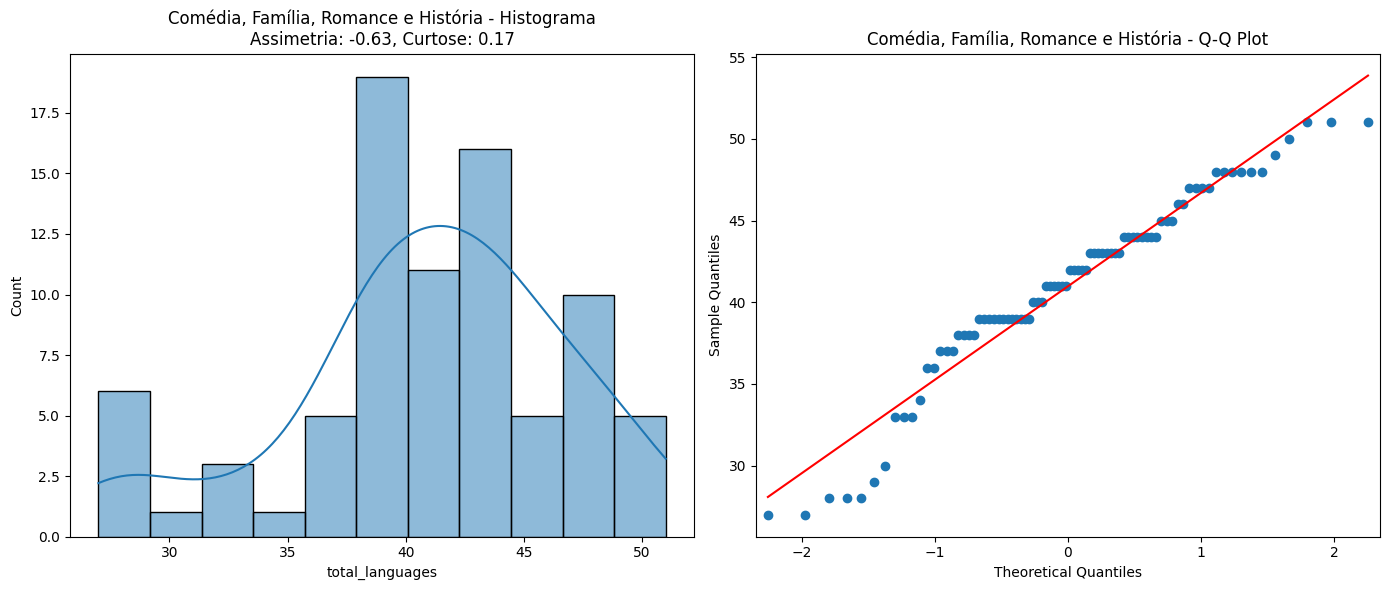

In [23]:
X = df.drop(columns=['genero', 'genero_representativo', 'genero_categoria', 'id', 'titulo', 'ano', 'diretor', 'pais', 'produtoras', 'oscar_wins'])
X = X.astype({col: 'int' for col in X.select_dtypes('bool').columns})
Y = df['genero_categoria']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

for category in Y.unique():
    for column in X.columns:
        aux = X[Y == category]
        plot(aux, column, category)

In [25]:
for column in X.columns:
    print(column)
    group1 = df[df['genero_categoria'] == 'Ação e Aventura'][column]
    group2 = df[df['genero_categoria'] == 'Drama e Suspense'][column]
    group3 = df[df['genero_categoria'] == 'Crime e Ficção Científica'][column]
    group4 = df[df['genero_categoria'] == 'Comédia, Família, Romance e História'][column]
    stat, p = levene(group1, group2, group3, group4)
    print(f'Estatística de Levene: {stat:.4f}, valor p: {p:.4f}')

popularidade
Estatística de Levene: 0.1362, valor p: 0.9384
voto_popular
Estatística de Levene: 4.5454, valor p: 0.0037
orcamento
Estatística de Levene: 14.1052, valor p: 0.0000
receita
Estatística de Levene: 7.2658, valor p: 0.0001
duracao
Estatística de Levene: 5.1759, valor p: 0.0015
avaliacao_da_critica
Estatística de Levene: 1.5974, valor p: 0.1889
total_streaming
Estatística de Levene: 4.4672, valor p: 0.0041
total_countries
Estatística de Levene: 1.3661, valor p: 0.2521
total_awards
Estatística de Levene: 0.9838, valor p: 0.3999
total_nominations
Estatística de Levene: 1.3294, valor p: 0.2638
total_languages
Estatística de Levene: 5.6257, valor p: 0.0008


<p>Analisando os resultados do teste de Levene, observou-se que nem todas as variáveis possui a homogeneidade de variância entre os grupos. Logo, para fins didáticos, trabalharemos apenas com as variáveis que satisfizeram a suposição, as quais são: 'popularidade', 'avaliação_da_critica', 'total_countries', 'total_awards', 'total_nominations'</p>

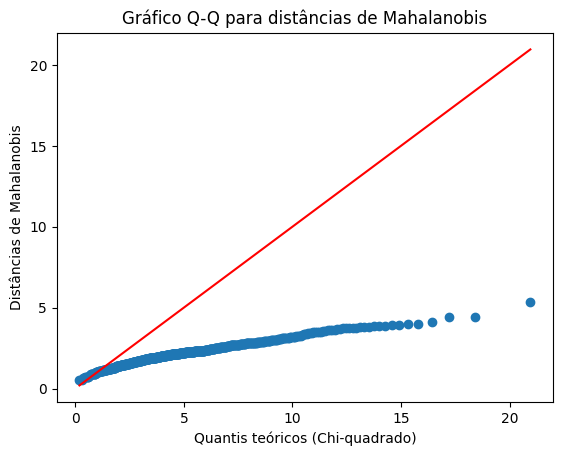

In [45]:
X = df[['popularidade', 'avaliacao_da_critica', 'total_countries', 'total_awards', 'total_nominations']]
X_transformed = pd.DataFrame(pt.fit_transform(X), columns=X.columns)
mean_vec = np.mean(X_transformed, axis=0)
cov_matrix = np.cov(X_transformed, rowvar=False)

#distancia de Mahalanobis para verificar a normalidade multivariada
def mahalanobis_dist(x, mean_vec, cov_matrix):
    diff = x - mean_vec
    inv_cov = np.linalg.inv(cov_matrix)
    return np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))

# Aplicar a distância de Mahalanobis
mahal_dist = [mahalanobis_dist(row, mean_vec, cov_matrix) for row in X_transformed.values]

# Plotar as distâncias de Mahalanobis contra a distribuição qui-quadrado
chi2_vals = chi2.ppf((np.arange(1, len(mahal_dist)+1) - 0.5) / len(mahal_dist), df=X_transformed.shape[1])
mahal_dist_sorted = sorted(mahal_dist)


plt.scatter(chi2_vals, mahal_dist_sorted)
plt.plot([min(chi2_vals), max(chi2_vals)], [min(chi2_vals), max(chi2_vals)], color='red')
plt.xlabel('Quantis teóricos (Chi-quadrado)')
plt.ylabel('Distâncias de Mahalanobis')
plt.title('Gráfico Q-Q para distâncias de Mahalanobis')
plt.show()

In [34]:
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['Variável'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                Variável           VIF
0                  const  24188.640692
1           popularidade      1.177932
2           voto_popular      2.152071
3              orcamento      2.894856
4                receita      3.376269
5                duracao      1.341639
6   avaliacao_da_critica      2.166491
7        total_streaming      1.522213
8        total_countries      1.665246
9           total_awards      4.004938
10     total_nominations      4.591050
11       total_languages      2.440415


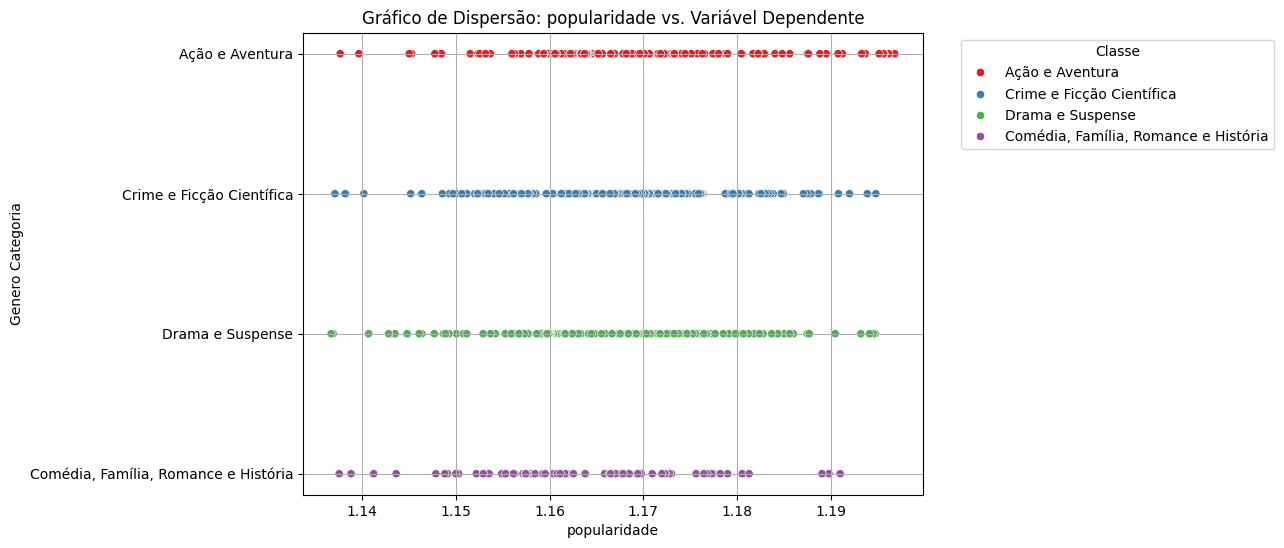

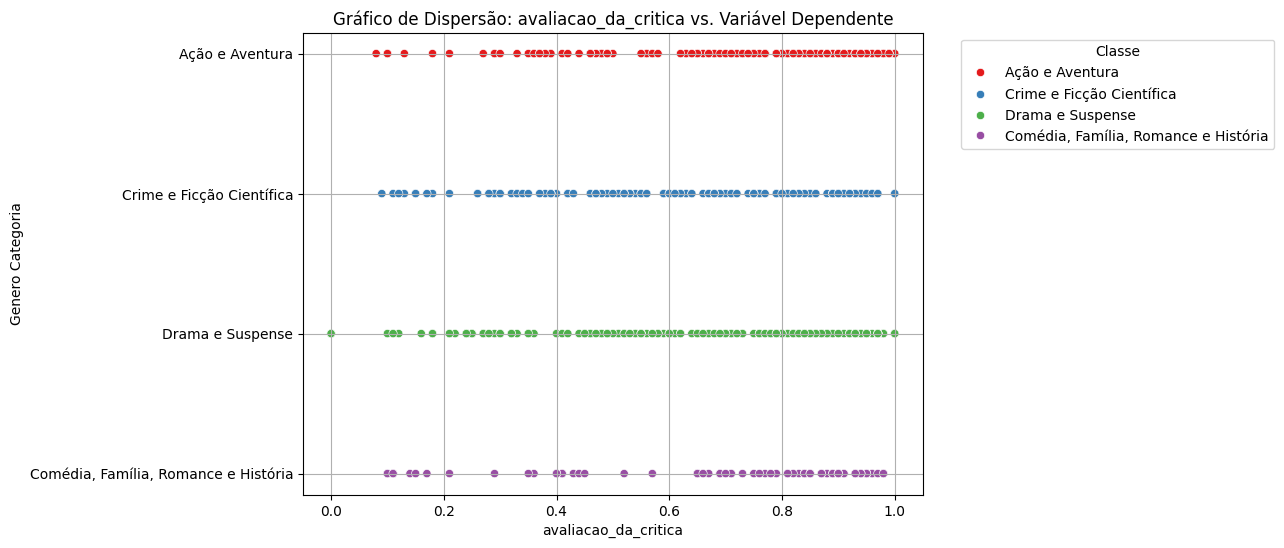

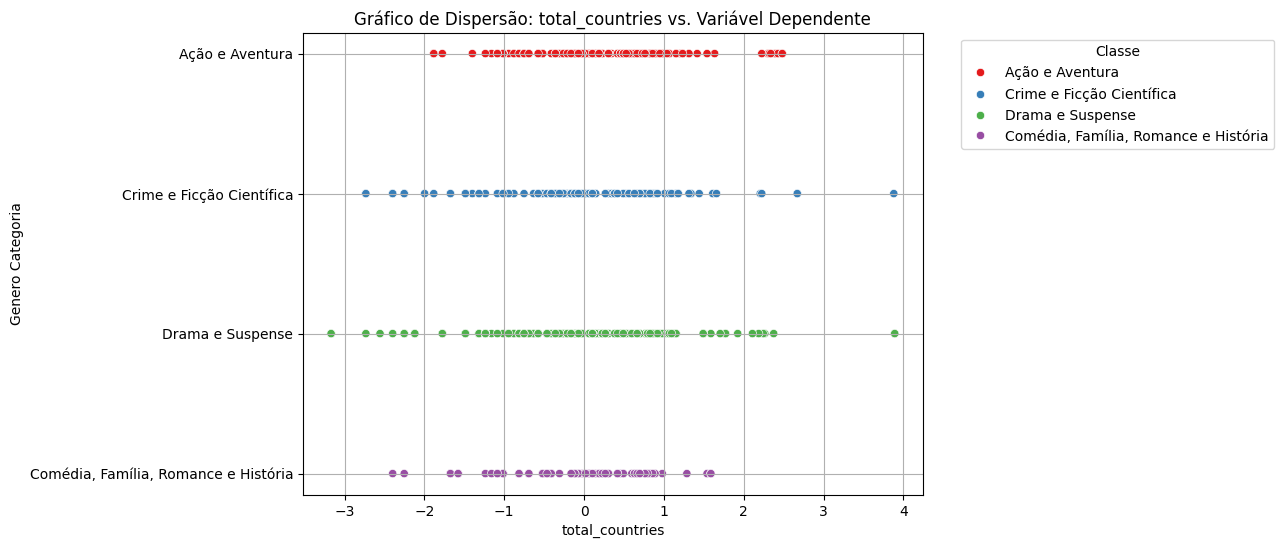

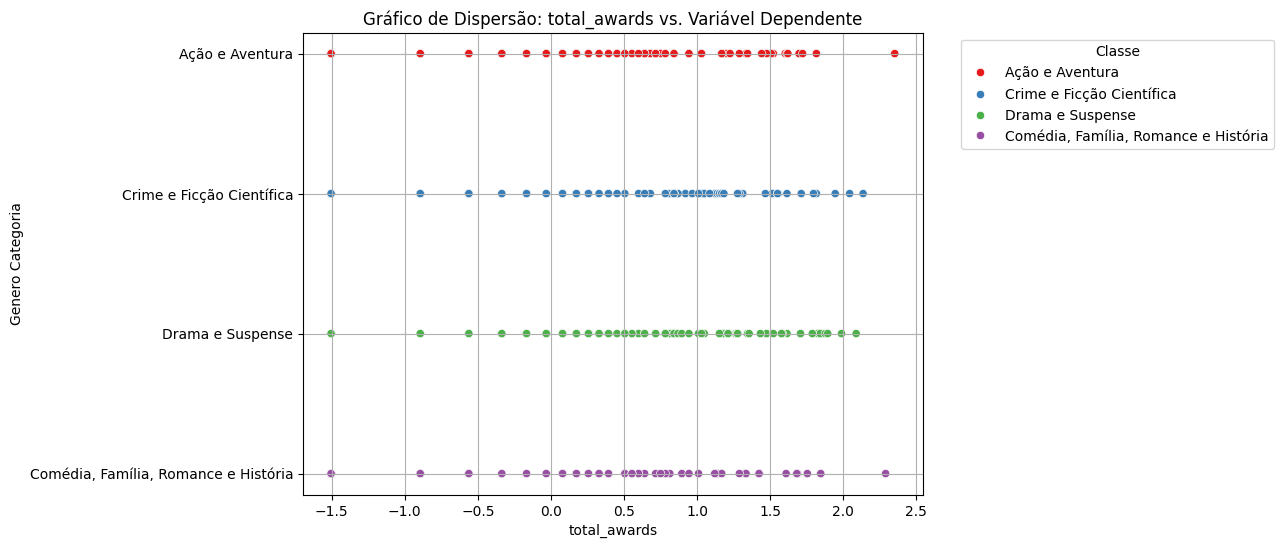

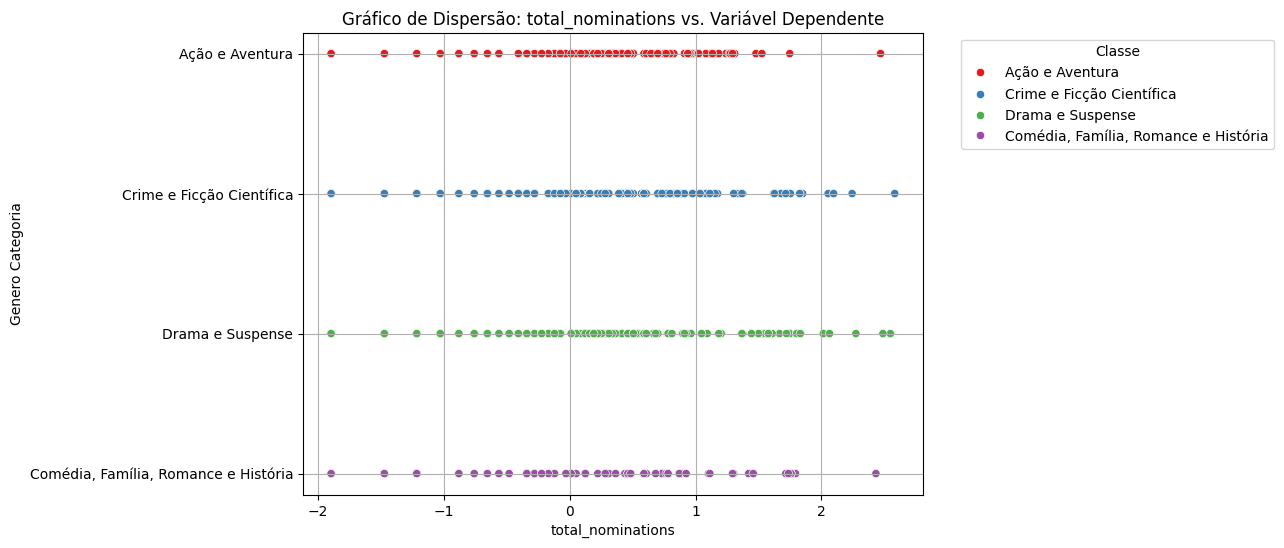

In [47]:
X = df[['popularidade', 'avaliacao_da_critica', 'total_countries', 'total_awards', 'total_nominations']]
for column in X.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=column, y='genero_categoria', hue='genero_categoria', palette='Set1')
    plt.title(f'Gráfico de Dispersão: {column} vs. Variável Dependente')
    plt.xlabel(column)
    plt.ylabel('Genero Categoria')
    plt.legend(title='Classe', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.show()

<p>Analisando os gráficos, observa-se que não há como discriminar bem baseado nessa variáveis e não há a confirmação da linearidade</p>

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [51]:
lda = LDA()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

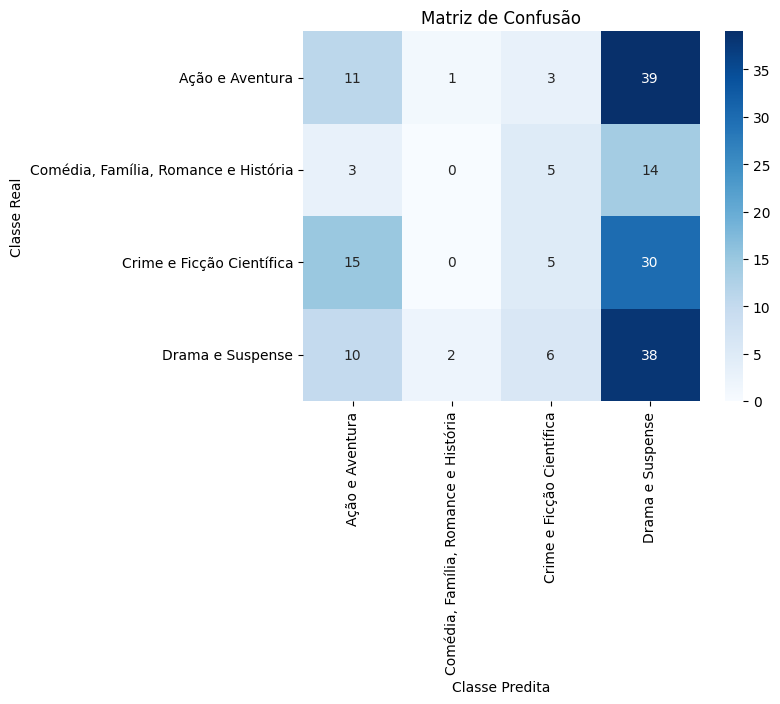

                                      precision    recall  f1-score   support

                     Ação e Aventura       0.28      0.20      0.24        54
Comédia, Família, Romance e História       0.00      0.00      0.00        22
           Crime e Ficção Científica       0.26      0.10      0.14        50
                    Drama e Suspense       0.31      0.68      0.43        56

                            accuracy                           0.30       182
                           macro avg       0.21      0.25      0.20       182
                        weighted avg       0.25      0.30      0.24       182

Acurácia: 0.2967


In [52]:
y_pred = lda.predict(X_test)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lda.classes_, yticklabels=lda.classes_)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.4f}')

## Analisando os resultados, observa-se que não se obteve um modelo bom, visto que não houve como atingir as suposições da técnica de Análise discriminante